In [274]:
import keras
import os, shutil
# load jute and maize images

# Directories for training, validation, and test sets
train_dir = './train'
valid_dir ='./validation'
test_dir = './test'

### The below is not necessary
# Directory with the training jute and maize pictures
train_jute_dir = os.path.join(train_dir, 'jute')
train_maize_dir = os.path.join(train_dir, 'maize')

# Directory with the validation jute and maize pictures
valid_jute_dir = os.path.join(valid_dir, 'jute')
valid_maize_dir = os.path.join(valid_dir, 'maize')

# Directory with the test jute and maize pictures
test_jute_dir = os.path.join(test_dir, 'jute')
test_maize_dir = os.path.join(test_dir, 'maize')

print('Total training jute images:', len(os.listdir(train_jute_dir)))
print('Total training maize images:', len(os.listdir(train_maize_dir)))
print('Total validation jute images:', len(os.listdir(valid_jute_dir)))
print('Total validation maize images:', len(os.listdir(valid_maize_dir)))
print('Total test jute images:', len(os.listdir(test_jute_dir)))
print('Total test maize images:', len(os.listdir(test_maize_dir)))


Total training jute images: 14
Total training maize images: 19
Total validation jute images: 4
Total validation maize images: 6
Total test jute images: 5
Total test maize images: 5


In [275]:
# Preprocess the images: read the image files; 
# decode the jpg to RBG grids of pixels (150x150); 
# convert to float point tensors; rescale the pixel values

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
print('\n')
print('Preprocess the training set')
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        directory = train_dir,      # The target directory
        target_size=(150, 150),     # Being resized to 150x150
        batch_size=12,
        class_mode='binary',        # Binary classification
        seed = 63
        )

# Each batch has 20 samples, and each sample is an 150x150 RGB image 
# (shape 150,150,3) and binary labels.
print('\n')
print('In the first batch')
(data_batch, labels_batch) = train_generator[0]
print('Data batch shape:', data_batch.shape)
print('Labels batch shape:', labels_batch.shape)



Preprocess the training set
Found 33 images belonging to 2 classes.


In the first batch
Data batch shape: (12, 150, 150, 3)
Labels batch shape: (12,)


In [276]:
# preprocess the validation set
print('\n')
print('Preprocess the validation set')
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        directory = valid_dir,      
        target_size=(150, 150),     
        batch_size=20,
        class_mode='binary',        
        seed = 63
        )

# preprocess the test set
print('\n')
print('Preprocess the test set')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        directory = test_dir,      
        target_size=(150, 150),     
        batch_size=1,
        class_mode='binary',  
        shuffle = False,
        seed = 63
        )




Preprocess the validation set
Found 10 images belonging to 2 classes.


Preprocess the test set
Found 10 images belonging to 2 classes.


In [277]:
# build a CNN
from keras import layers
from keras import models
from keras import optimizers

def createModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                                input_shape=(150, 150, 3)))  
    model.add(layers.MaxPooling2D((2, 2))) # stride 2 (downsampled by a factor of 2)
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
        
    model.add(layers.Flatten()) # Flatten the 3D outputs to 1D before adding a few Dense layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # binary classificaiton

    model.compile(loss='binary_crossentropy',
         optimizer=optimizers.RMSprop(1e-4),
                metrics=['acc'])

    return model;

# configure the model
# train the model
def trainModel(model):
    history = model.fit(
              train_generator,
              steps_per_epoch=100,      # 2000/20
              epochs=50,
              validation_data=valid_generator,
              validation_steps=50       # 1000/20
        )
    return history


#save 10 models
save_dir = "./saved_model/"
histories = []
for i in range(10):
    model = createModel()
    histories.append(trainModel(model))
    model.save(save_dir + "model_jute_maize_{}.keras".format(i+1))


Epoch 1/50


C:\PyIDE\envs\myTF\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\PyIDE\envs\myTF\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.5759 - loss: 0.6761 - val_acc: 0.6000 - val_loss: 0.6491
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.4835 - loss: 0.6868 - val_acc: 0.6000 - val_loss: 0.6444
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5755 - loss: 0.6453 - val_acc: 0.6000 - val_loss: 0.6430
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5763 - loss: 0.6538 - val_acc: 0.6000 - val_loss: 0.6522
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6946 - loss: 0.6322 - val_acc: 0.6000 - val_loss: 0.6361
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5759 - loss: 0.6165 - val_acc: 0.6000 - val_loss: 0.6324
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6348 - loss: 0.6003 - val_acc: 0.6000 - val_loss: 0.6240
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6057 - loss: 0.5909 - val_acc: 0.8000 - val_loss: 0.6487
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.6696 -

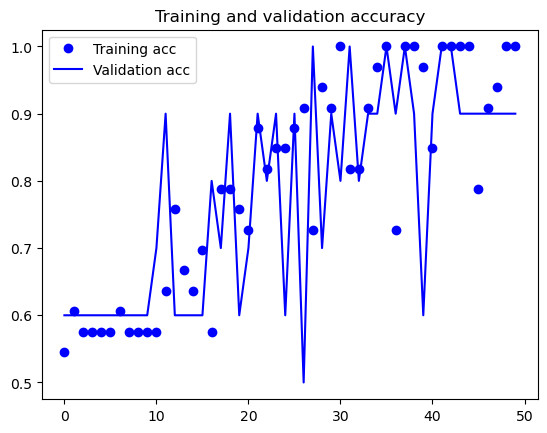

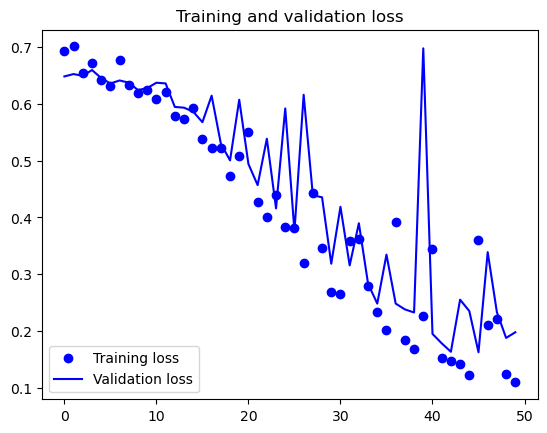

In [324]:
# plot the training and validation scores for a model
import matplotlib.pyplot as plt
import tensorflow as tf

model = tf.keras.models.load_model("./saved_model/model_jute_maize_2.keras")
history = histories[9]
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


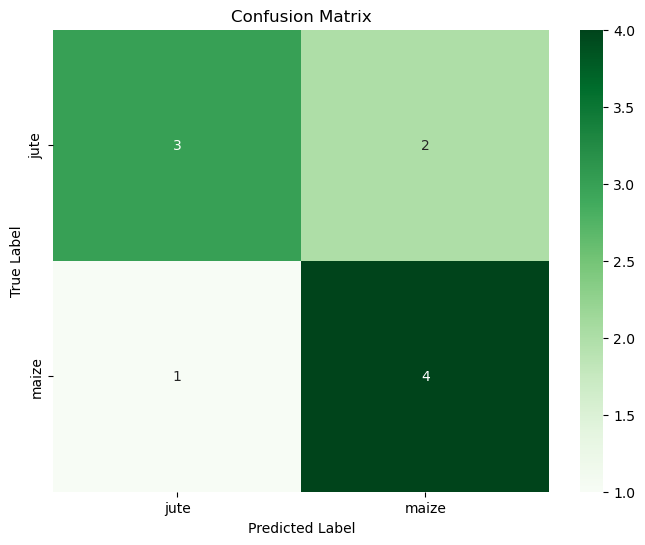

In [323]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

model = tf.keras.models.load_model("./saved_model/model_jute_maize_2.keras")
# Get the true labels from the test generator
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
pred = model.predict(test_generator, steps = 10, verbose = 1)
predicted_class_indices = (pred > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(true_labels, predicted_class_indices)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

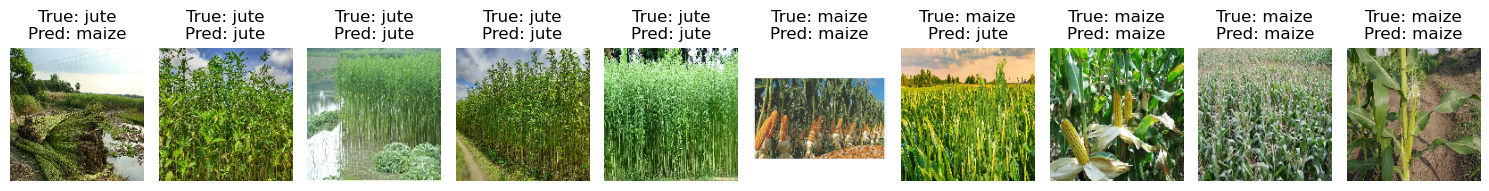

In [280]:
import matplotlib.pyplot as plt
# Display images with their true and predicted labels
num_images_to_show = 10

plt.figure(figsize=(15, 15))

for i in range(num_images_to_show):
    # Get image and label from the generator
    img, true_label = test_generator[i]
    img = img[0] # Get the single image from the batch
    true_label = int(true_label[0]) # Get the single label

    # Get the predicted label
    predicted_label = predicted_class_indices[i]

    # Map the integer labels back to class names
    true_class_name = class_labels[true_label]
    predicted_class_name = class_labels[predicted_label]

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f'True: {true_class_name}\nPred: {predicted_class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [322]:
# evaludate the model
# Evaluation
model = tf.keras.models.load_model("./saved_model/model_jute_maize_2.keras")
eval_test = model.evaluate(test_generator, steps=10)
print("The test score (accuracy) is {}%".format(eval_test[1]*100))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.5330 - loss: 1.2348 
The test score (accuracy) is 69.9999988079071%


In [315]:
print('\nPreprocess the training set')
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    seed=63
)

print('\nIn the first batch')
(data_batch, labels_batch) = train_generator[0]
print('Data batch shape:', data_batch.shape)
print('Labels batch shape:', labels_batch.shape)

print('\nPreprocess the validation set')
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    seed=63
)

print('\nPreprocess the test set')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False,
    seed=63
)


Preprocess the training set
Found 33 images belonging to 2 classes.

In the first batch
Data batch shape: (20, 150, 150, 3)
Labels batch shape: (20,)

Preprocess the validation set
Found 10 images belonging to 2 classes.

Preprocess the test set
Found 10 images belonging to 2 classes.


In [316]:
model = createModel()
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=50
)

# Save the model
model.save('model_jute_maize.keras')



Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.5145 - loss: 0.6839 - val_acc: 0.6000 - val_loss: 0.6450
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5755 - loss: 0.6735 - val_acc: 0.6000 - val_loss: 0.6450
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5762 - loss: 0.6598 - val_acc: 0.6000 - val_loss: 0.6441
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5755 - loss: 0.6571 - val_acc: 0.6000 - val_loss: 0.6435
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5760 - loss: 0.6555 - val_acc: 0.6000 - val_loss: 0.6592
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5762 - loss: 0.6601 - val_acc: 0.6000 - val_loss: 0.6452
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5777 - loss: 0.7100 - val_acc: 0.6000 - val_loss: 0.6432
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.5760 - loss: 0.6465 - val_acc: 0.6000 - val_loss: 0.6450
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ac

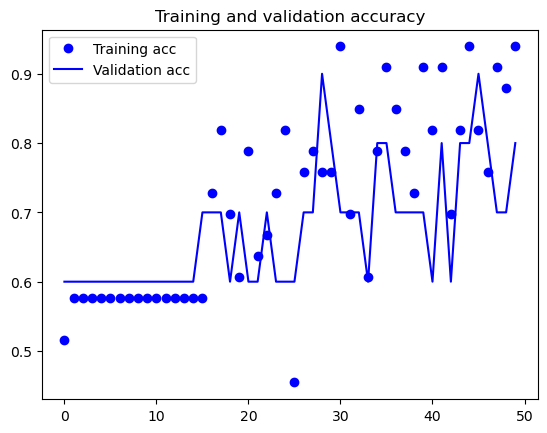

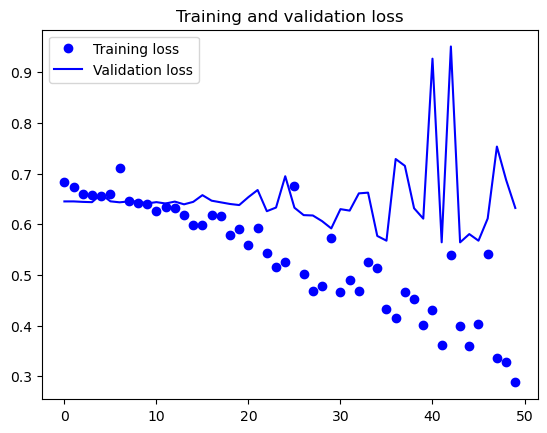

In [317]:
# plot the training and validation scores for a model
import matplotlib.pyplot as plt
import tensorflow as tf

model = tf.keras.models.load_model("model_jute_maize.keras")
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


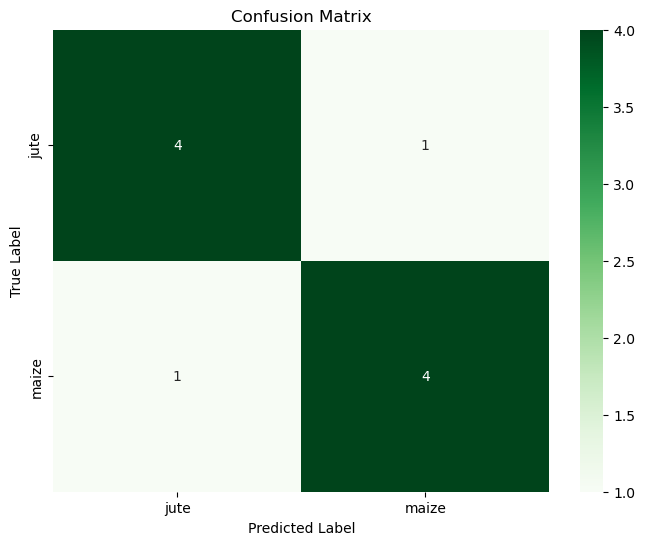

In [318]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

model = tf.keras.models.load_model("model_jute_maize.keras")
# Get the true labels from the test generator
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
pred = model.predict(test_generator, steps = 10, verbose = 1)
predicted_class_indices = (pred > 0.5).astype(int).reshape(-1)
cm = confusion_matrix(true_labels, predicted_class_indices)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

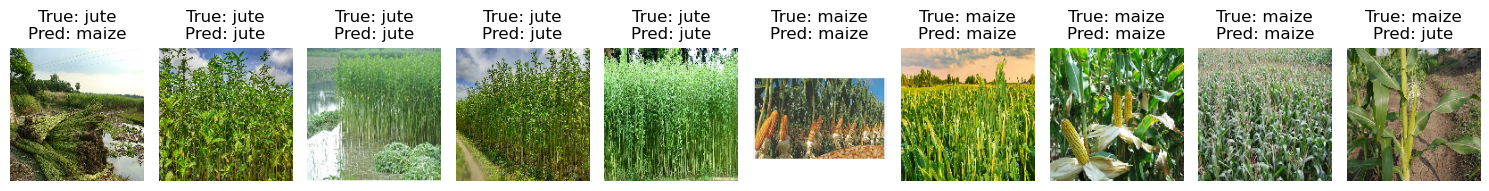

In [319]:
import matplotlib.pyplot as plt
# Display images with their true and predicted labels
num_images_to_show = 10

plt.figure(figsize=(15, 15))

for i in range(num_images_to_show):
    # Get image and label from the generator
    img, true_label = test_generator[i]
    img = img[0] # Get the single image from the batch
    true_label = int(true_label[0]) # Get the single label

    # Get the predicted label
    predicted_label = predicted_class_indices[i]

    # Map the integer labels back to class names
    true_class_name = class_labels[true_label]
    predicted_class_name = class_labels[predicted_label]

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(f'True: {true_class_name}\nPred: {predicted_class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [320]:
# evaludate the model with Data Augmentation
# Evaluation
model = tf.keras.models.load_model("model_jute_maize.keras")
eval_test = model.evaluate(test_generator, steps=10)
print("The test score (accuracy) is {}%".format(eval_test[1]*100))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.7065 - loss: 0.5583 
The test score (accuracy) is 80.0000011920929%


In [288]:
from keras.applications import VGG16

conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (150, 150, 3)
    )
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_100 (InputLayer)    │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [289]:
# build the network
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [290]:
# unfreeze the top block of convolutional base
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.summary()

# fine-tuning
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=10,
      epochs=5,
      validation_data=valid_generator,
      validation_steps=50)

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_92 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,910,017 (72.14 MB)

 Trainable params: 11,274,753 (43.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - acc: 0.5286 - loss: 0.7905 - val_acc: 0.7000 - val_loss: 0.6077
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - acc: 0.6700 - loss: 0.6418 - val_acc: 0.7000 - val_loss: 0.5747
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - acc: 0.6377 - loss: 0.6568 - val_acc: 0.8000 - val_loss: 0.5526
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - acc: 0.5448 - loss: 0.6389 - val_acc: 0.8000 - val_loss: 0.5215
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - acc: 0.6573 - loss: 0.6482 - val_acc: 0.9000 - val_loss: 0.4994


In [291]:
# evaludate the model with Data Augmentation
# Evaluation
eval_test = model.evaluate(test_generator, steps=20)
print("The test score (accuracy) is {}%".format(eval_test[1]*100))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.6571 - loss: 0.7095 
The test score (accuracy) is 80.0000011920929%


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
from tqdm import tqdm

# === Parameters ===
IMAGE_SIZE = 150
CHANNELS = 3
BATCH_SIZE = 4
BUFFER_SIZE = 19
EPOCHS = 3000
NOISE_DIM = 100
SAVE_DIR = "generated_images"
os.makedirs(SAVE_DIR, exist_ok=True)

# === Load and preprocess images ===
def load_images(path_pattern):
    images = []
    for file_path in glob.glob(path_pattern):
        img = Image.open(file_path).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
        img = np.asarray(img).astype(np.float32)
        images.append(img)
    return np.array(images)

imgs = load_images("./train/maize/*.jpg")  # <-- locate the file path
imgs = (imgs - 127.5) / 127.5  # Normalize to [-1, 1]

# === Data augmentation ===
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image

dataset = tf.data.Dataset.from_tensor_slices(imgs)
dataset = dataset.map(lambda x: augment_image(x), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Generator ===
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding='same',
                                     use_bias=False, activation='tanh'))
    model.add(layers.Resizing(150, 150))
    return model

# === Discriminator ===
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[IMAGE_SIZE, IMAGE_SIZE, CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    for filters in [128, 256, 512]:
        model.add(layers.Conv2D(filters, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

# === Loss and optimizers ===
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# === Training Step ===
@tf.function
def train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

# === Save images ===
def save_generated_images(model, epoch, seed):
    predictions = model(seed, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = (predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')

    filename = os.path.join(SAVE_DIR, f"epoch_{epoch:04d}.png")
    plt.savefig(filename)
    plt.close()

# === Training Loop ===
def train(dataset, epochs):
    seed = tf.random.normal([16, NOISE_DIM])
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for batch in tqdm(dataset, desc="Training", leave=False):
            gen_loss, disc_loss = train_step(batch)

        print(f"Gen loss: {gen_loss:.4f}, Disc loss: {disc_loss:.4f}")

        if (epoch + 1) % 200 == 0:
            save_generated_images(generator, epoch + 1, seed)

# === Run training ===
train(dataset, EPOCHS)


C:\PyIDE\envs\myTF\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\PyIDE\envs\myTF\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3000


Gen loss: 0.5316, Disc loss: 1.4270
Epoch 2/3000


Gen loss: 0.5356, Disc loss: 1.2596
Epoch 3/3000


Gen loss: 0.5762, Disc loss: 0.9308
Epoch 4/3000


Gen loss: 0.7546, Disc loss: 0.9024
Epoch 5/3000


Gen loss: 0.9236, Disc loss: 0.9652
Epoch 6/3000


Gen loss: 0.8744, Disc loss: 1.0451
Epoch 7/3000


Gen loss: 0.5360, Disc loss: 0.9342
Epoch 8/3000


Gen loss: 0.9646, Disc loss: 0.4804
Epoch 9/3000


Gen loss: 0.1291, Disc loss: 2.1111
Epoch 10/3000


Gen loss: 0.9208, Disc loss: 0.9047
Epoch 11/3000


Gen loss: 0.9796, Disc loss: 1.5515
Epoch 12/3000


Gen loss: 0.4571, Disc loss: 1.0027
Epoch 13/3000


Gen loss: 0.7429, Disc loss: 0.6550
Epoch 14/3000


Gen loss: 1.5081, Disc loss: 0.2823
Epoch 15/3000


Gen loss: 1.4442, Disc loss: 0.6712
Epoch 16/3000


Gen loss: 0.3777, Disc loss: 1.1869
Epoch 17/3000


Gen loss: 0.1590, Disc loss: 1.9171
Epoch 18/3000


Gen loss: 0.8136, Disc loss: 0.5858
Epoch 19/3000


Gen loss: 1.4286, Disc loss: 0.2740
Epoch 20/3000


Gen loss: 0.4076, Disc loss: 1.0964
Epoch 21/3000


Gen loss: 1.0716, Disc loss: 0.6402
Epoch 22/3000


Gen loss: 0.5707, Disc loss: 0.9279
Epoch 23/3000


Gen loss: 0.9855, Disc loss: 0.4675
Epoch 24/3000


Gen loss: 0.7460, Disc loss: 0.6717
Epoch 25/3000


Gen loss: 1.1138, Disc loss: 0.7597
Epoch 26/3000


Gen loss: 0.4030, Disc loss: 1.1303
Epoch 27/3000


Gen loss: 0.8164, Disc loss: 0.6134
Epoch 28/3000


Gen loss: 1.3857, Disc loss: 0.2919
Epoch 29/3000


Gen loss: 1.5203, Disc loss: 1.4447
Epoch 30/3000


Gen loss: 0.4557, Disc loss: 1.0300
Epoch 31/3000


Gen loss: 0.4800, Disc loss: 1.0732
Epoch 32/3000


Gen loss: 2.0742, Disc loss: 1.3139
Epoch 33/3000


Gen loss: 0.3718, Disc loss: 1.5222
Epoch 34/3000


Gen loss: 0.6080, Disc loss: 1.1892
Epoch 35/3000


Gen loss: 0.7072, Disc loss: 1.0117
Epoch 36/3000


Gen loss: 0.7821, Disc loss: 0.7227
Epoch 37/3000


Gen loss: 0.5727, Disc loss: 1.0903
Epoch 38/3000


Gen loss: 0.9711, Disc loss: 0.7925
Epoch 39/3000


Gen loss: 1.6369, Disc loss: 0.3998
Epoch 40/3000


Gen loss: 1.5860, Disc loss: 0.2810
Epoch 41/3000


Gen loss: 1.1657, Disc loss: 1.3031
Epoch 42/3000


Gen loss: 0.6283, Disc loss: 0.7901
Epoch 43/3000


Gen loss: 0.8626, Disc loss: 1.6551
Epoch 44/3000


Gen loss: 0.4529, Disc loss: 1.1139
Epoch 45/3000


Gen loss: 0.8523, Disc loss: 0.6399
Epoch 46/3000


Gen loss: 1.0923, Disc loss: 0.4706
Epoch 47/3000


Gen loss: 0.9756, Disc loss: 0.6651
Epoch 48/3000


Gen loss: 1.4752, Disc loss: 0.2727
Epoch 49/3000


Gen loss: 1.8857, Disc loss: 0.1691
Epoch 50/3000


Gen loss: 1.8858, Disc loss: 0.1872
Epoch 51/3000


Gen loss: 0.1227, Disc loss: 2.1589
Epoch 52/3000


Gen loss: 1.3123, Disc loss: 0.3850
Epoch 53/3000


Gen loss: 1.0945, Disc loss: 1.3006
Epoch 54/3000


Gen loss: 0.1797, Disc loss: 4.6291
Epoch 55/3000


Gen loss: 0.3684, Disc loss: 1.3304
Epoch 56/3000


Gen loss: 1.0383, Disc loss: 0.5834
Epoch 57/3000


Gen loss: 1.6098, Disc loss: 0.2574
Epoch 58/3000


Gen loss: 1.3130, Disc loss: 0.3240
Epoch 59/3000


Gen loss: 2.3769, Disc loss: 0.3091
Epoch 60/3000


Gen loss: 1.6684, Disc loss: 0.2948
Epoch 61/3000


Gen loss: 1.6195, Disc loss: 0.6504
Epoch 62/3000


Gen loss: 0.7940, Disc loss: 0.6299
Epoch 63/3000


Gen loss: 0.2072, Disc loss: 1.6821
Epoch 64/3000


Gen loss: 1.3645, Disc loss: 0.4316
Epoch 65/3000


Gen loss: 1.4862, Disc loss: 0.2817
Epoch 66/3000


Gen loss: 1.1185, Disc loss: 0.4372
Epoch 67/3000


Gen loss: 1.5242, Disc loss: 0.2734
Epoch 68/3000


Gen loss: 1.1534, Disc loss: 0.4680
Epoch 69/3000


Gen loss: 1.3042, Disc loss: 0.3310
Epoch 70/3000


Gen loss: 0.9884, Disc loss: 0.8478
Epoch 71/3000


Gen loss: 1.2006, Disc loss: 3.9724
Epoch 72/3000


Gen loss: 0.8072, Disc loss: 0.6011
Epoch 73/3000


Gen loss: 0.0748, Disc loss: 2.7642
Epoch 74/3000


Gen loss: 1.2765, Disc loss: 0.3710
Epoch 75/3000


Gen loss: 1.3233, Disc loss: 0.3282
Epoch 76/3000


Gen loss: 1.1131, Disc loss: 0.6434
Epoch 77/3000


Gen loss: 1.4575, Disc loss: 0.5561
Epoch 78/3000


Gen loss: 0.8758, Disc loss: 0.7282
Epoch 79/3000


Gen loss: 1.3338, Disc loss: 0.3684
Epoch 80/3000


Gen loss: 0.4892, Disc loss: 1.1142
Epoch 81/3000


Gen loss: 0.9232, Disc loss: 0.6163
Epoch 82/3000


Gen loss: 0.9719, Disc loss: 0.6324
Epoch 83/3000


Gen loss: 0.1806, Disc loss: 1.8078
Epoch 84/3000


Gen loss: 0.8777, Disc loss: 0.6025
Epoch 85/3000


Gen loss: 0.7145, Disc loss: 0.6946
Epoch 86/3000


Gen loss: 1.4758, Disc loss: 0.4788
Epoch 87/3000


Gen loss: 0.8805, Disc loss: 1.2599
Epoch 88/3000


Gen loss: 0.5431, Disc loss: 0.8792
Epoch 89/3000


Gen loss: 0.3747, Disc loss: 1.1955
Epoch 90/3000


Gen loss: 3.5579, Disc loss: 0.1413
Epoch 91/3000


Gen loss: 0.3582, Disc loss: 2.3041
Epoch 92/3000


Gen loss: 0.8443, Disc loss: 0.6416
Epoch 93/3000


Gen loss: 0.9525, Disc loss: 0.8603
Epoch 94/3000


Gen loss: 1.3575, Disc loss: 2.0719
Epoch 95/3000


Gen loss: 0.5144, Disc loss: 1.3804
Epoch 96/3000


Gen loss: 0.2506, Disc loss: 1.5810
Epoch 97/3000


Gen loss: 1.3974, Disc loss: 0.4228
Epoch 98/3000


Gen loss: 1.4629, Disc loss: 0.5394
Epoch 99/3000


Gen loss: 0.6046, Disc loss: 0.8628
Epoch 100/3000


Gen loss: 0.9718, Disc loss: 0.5486
Epoch 101/3000


Gen loss: 0.8878, Disc loss: 0.5937
Epoch 102/3000


Gen loss: 0.8175, Disc loss: 0.7110
Epoch 103/3000


Gen loss: 1.2551, Disc loss: 0.3618
Epoch 104/3000


Gen loss: 0.6319, Disc loss: 0.8443
Epoch 105/3000


Gen loss: 0.7672, Disc loss: 0.8140
Epoch 106/3000


Gen loss: 0.5672, Disc loss: 0.8714
Epoch 107/3000


Gen loss: 0.4849, Disc loss: 0.9812
Epoch 108/3000


Gen loss: 1.3201, Disc loss: 0.6103
Epoch 109/3000


Gen loss: 0.5637, Disc loss: 0.8941
Epoch 110/3000


Gen loss: 0.9345, Disc loss: 0.6183
Epoch 111/3000


Gen loss: 1.0516, Disc loss: 0.5794
Epoch 112/3000


Gen loss: 1.3435, Disc loss: 0.6694
Epoch 113/3000


Gen loss: 0.3239, Disc loss: 1.6709
Epoch 114/3000


Gen loss: 0.5164, Disc loss: 2.2130
Epoch 115/3000


Gen loss: 1.0207, Disc loss: 0.8623
Epoch 116/3000


Gen loss: 0.3173, Disc loss: 1.3245
Epoch 117/3000


Gen loss: 0.5160, Disc loss: 0.9381
Epoch 118/3000


Gen loss: 2.0550, Disc loss: 0.6385
Epoch 119/3000


Gen loss: 0.7229, Disc loss: 0.8802
Epoch 120/3000


Gen loss: 0.5990, Disc loss: 1.4561
Epoch 121/3000


Gen loss: 0.1903, Disc loss: 1.7836
Epoch 122/3000


Gen loss: 1.4150, Disc loss: 0.6279
Epoch 123/3000


Gen loss: 1.1136, Disc loss: 1.3618
Epoch 124/3000


Gen loss: 0.3712, Disc loss: 1.2053
Epoch 125/3000


Gen loss: 0.7978, Disc loss: 0.9765
Epoch 126/3000


Gen loss: 0.4684, Disc loss: 1.1760
Epoch 127/3000


Gen loss: 0.9895, Disc loss: 0.8527
Epoch 128/3000


Gen loss: 0.4588, Disc loss: 1.0660
Epoch 129/3000


Gen loss: 0.6453, Disc loss: 0.7601
Epoch 130/3000


Gen loss: 1.4011, Disc loss: 0.6654
Epoch 131/3000


Gen loss: 0.2518, Disc loss: 1.5791
Epoch 132/3000


Gen loss: 0.7256, Disc loss: 0.6779
Epoch 133/3000


Gen loss: 1.3924, Disc loss: 0.3591
Epoch 134/3000


Gen loss: 0.2809, Disc loss: 1.4579
Epoch 135/3000


Gen loss: 0.5105, Disc loss: 1.2503
Epoch 136/3000


Gen loss: 1.3060, Disc loss: 0.5037
Epoch 137/3000


Gen loss: 0.4265, Disc loss: 1.0819
Epoch 138/3000


Gen loss: 1.1499, Disc loss: 0.7968
Epoch 139/3000


Gen loss: 0.4257, Disc loss: 1.1009
Epoch 140/3000


Gen loss: 0.8512, Disc loss: 0.5915
Epoch 141/3000


Gen loss: 1.4116, Disc loss: 0.6442
Epoch 142/3000


Gen loss: 0.5782, Disc loss: 1.2392
Epoch 143/3000


Gen loss: 0.8073, Disc loss: 0.6237
Epoch 144/3000


Gen loss: 0.9529, Disc loss: 0.7290
Epoch 145/3000


Gen loss: 0.5261, Disc loss: 2.2479
Epoch 146/3000


Gen loss: 0.9925, Disc loss: 0.8466
Epoch 147/3000


Gen loss: 0.2200, Disc loss: 1.6367
Epoch 148/3000


Gen loss: 1.4468, Disc loss: 0.3214
Epoch 149/3000


Gen loss: 2.1576, Disc loss: 0.8985
Epoch 150/3000


Gen loss: 0.5256, Disc loss: 2.0160
Epoch 151/3000


Gen loss: 0.5743, Disc loss: 1.2031
Epoch 152/3000


Gen loss: 0.3030, Disc loss: 1.7477
Epoch 153/3000


Gen loss: 0.8946, Disc loss: 0.7874
Epoch 154/3000


Gen loss: 1.2695, Disc loss: 0.5329
Epoch 155/3000


Gen loss: 0.2527, Disc loss: 1.7527
Epoch 156/3000


Gen loss: 0.3722, Disc loss: 1.4768
Epoch 157/3000


Gen loss: 1.7657, Disc loss: 0.3191
Epoch 158/3000


Gen loss: 0.4750, Disc loss: 1.0340
Epoch 159/3000


Gen loss: 1.0149, Disc loss: 1.0189
Epoch 160/3000


Gen loss: 0.5799, Disc loss: 1.2252
Epoch 161/3000


Gen loss: 0.5232, Disc loss: 1.1085
Epoch 162/3000


Gen loss: 1.1106, Disc loss: 0.7293
Epoch 163/3000


Gen loss: 0.3075, Disc loss: 1.6209
Epoch 164/3000


Gen loss: 0.4418, Disc loss: 1.0539
Epoch 165/3000


Gen loss: 0.7600, Disc loss: 1.0300
Epoch 166/3000


Gen loss: 0.2551, Disc loss: 1.6545
Epoch 167/3000


Gen loss: 1.0035, Disc loss: 0.5612
Epoch 168/3000


Gen loss: 0.5164, Disc loss: 1.7877
Epoch 169/3000


Gen loss: 0.0998, Disc loss: 2.7676
Epoch 170/3000


Gen loss: 1.2498, Disc loss: 1.0978
Epoch 171/3000


Gen loss: 0.4653, Disc loss: 1.0905
Epoch 172/3000


Gen loss: 0.8156, Disc loss: 0.7165
Epoch 173/3000


Gen loss: 0.5820, Disc loss: 0.8776
Epoch 174/3000


Gen loss: 1.1766, Disc loss: 0.5951
Epoch 175/3000


Gen loss: 0.5883, Disc loss: 1.3018
Epoch 176/3000


Gen loss: 0.8035, Disc loss: 0.6714
Epoch 177/3000


Gen loss: 0.5577, Disc loss: 1.0019
Epoch 178/3000


Gen loss: 1.0339, Disc loss: 0.5628
Epoch 179/3000


Gen loss: 0.5877, Disc loss: 1.2594
Epoch 180/3000


Gen loss: 0.6248, Disc loss: 0.8496
Epoch 181/3000


Gen loss: 0.8922, Disc loss: 0.6713
Epoch 182/3000


Gen loss: 0.9118, Disc loss: 0.6607
Epoch 183/3000


Gen loss: 0.4192, Disc loss: 1.3862
Epoch 184/3000


Gen loss: 0.5236, Disc loss: 1.8760
Epoch 185/3000


Gen loss: 0.5824, Disc loss: 0.8811
Epoch 186/3000


Gen loss: 0.8239, Disc loss: 1.8325
Epoch 187/3000


Gen loss: 0.5926, Disc loss: 0.8491
Epoch 188/3000


Gen loss: 0.5280, Disc loss: 1.0896
Epoch 189/3000


Gen loss: 0.5089, Disc loss: 1.1859
Epoch 190/3000


Gen loss: 0.9182, Disc loss: 0.7294
Epoch 191/3000


Gen loss: 0.4494, Disc loss: 1.0563
Epoch 192/3000


Gen loss: 1.2391, Disc loss: 0.5109
Epoch 193/3000


Gen loss: 0.3758, Disc loss: 1.3811
Epoch 194/3000


Gen loss: 0.9287, Disc loss: 0.7147
Epoch 195/3000


Gen loss: 0.7261, Disc loss: 2.0020
Epoch 196/3000


Gen loss: 0.3913, Disc loss: 1.2965
Epoch 197/3000


Gen loss: 1.0440, Disc loss: 0.4642
Epoch 198/3000


Gen loss: 1.1373, Disc loss: 0.7780
Epoch 199/3000


Gen loss: 0.6896, Disc loss: 0.8295
Epoch 200/3000


Gen loss: 0.8174, Disc loss: 0.7255
Epoch 201/3000


Gen loss: 0.7490, Disc loss: 0.7315
Epoch 202/3000


Gen loss: 1.0858, Disc loss: 0.6540
Epoch 203/3000


Gen loss: 0.8412, Disc loss: 1.0693
Epoch 204/3000


Gen loss: 1.0457, Disc loss: 0.8052
Epoch 205/3000


Gen loss: 0.4538, Disc loss: 1.6472
Epoch 206/3000


Gen loss: 1.4451, Disc loss: 0.6635
Epoch 207/3000


Gen loss: 0.0674, Disc loss: 2.8954
Epoch 208/3000


Gen loss: 0.9791, Disc loss: 1.5456
Epoch 209/3000


Gen loss: 0.3804, Disc loss: 1.3768
Epoch 210/3000


Gen loss: 0.9223, Disc loss: 1.2640
Epoch 211/3000


Gen loss: 0.2850, Disc loss: 1.4120
Epoch 212/3000


Gen loss: 1.4907, Disc loss: 0.7025
Epoch 213/3000


Gen loss: 0.7237, Disc loss: 0.9003
Epoch 214/3000


Gen loss: 0.7196, Disc loss: 1.4167
Epoch 215/3000


Gen loss: 0.7934, Disc loss: 0.7574
Epoch 216/3000


Gen loss: 1.0323, Disc loss: 0.9289
Epoch 217/3000


Gen loss: 1.0813, Disc loss: 0.5355
Epoch 218/3000


Gen loss: 0.7240, Disc loss: 1.1799
Epoch 219/3000


Gen loss: 0.2837, Disc loss: 1.4055
Epoch 220/3000


Gen loss: 0.8350, Disc loss: 0.6695
Epoch 221/3000


Gen loss: 0.8109, Disc loss: 1.1902
Epoch 222/3000


Gen loss: 0.4988, Disc loss: 2.1292
Epoch 223/3000


Gen loss: 0.6434, Disc loss: 1.0531
Epoch 224/3000


Gen loss: 0.8265, Disc loss: 0.5896
Epoch 225/3000


Gen loss: 0.5521, Disc loss: 0.8805
Epoch 226/3000


Gen loss: 1.3390, Disc loss: 0.9398
Epoch 227/3000


Gen loss: 0.5770, Disc loss: 1.8825
Epoch 228/3000


Gen loss: 0.3470, Disc loss: 1.2771
Epoch 229/3000


Gen loss: 1.8473, Disc loss: 0.2964
Epoch 230/3000


Gen loss: 0.9548, Disc loss: 0.9974
Epoch 231/3000


Gen loss: 0.4391, Disc loss: 1.0771
Epoch 232/3000


Gen loss: 1.1917, Disc loss: 0.6184
Epoch 233/3000


Gen loss: 0.6982, Disc loss: 0.8207
Epoch 234/3000


Gen loss: 0.7731, Disc loss: 0.9489
Epoch 235/3000


Gen loss: 1.7681, Disc loss: 0.3333
Epoch 236/3000


Gen loss: 0.1242, Disc loss: 2.5378
Epoch 237/3000


Gen loss: 1.3744, Disc loss: 0.6605
Epoch 238/3000


Gen loss: 0.3284, Disc loss: 1.2867
Epoch 239/3000


Gen loss: 0.7519, Disc loss: 0.6942
Epoch 240/3000


Gen loss: 0.3472, Disc loss: 1.5884
Epoch 241/3000


Gen loss: 0.5297, Disc loss: 0.9688
Epoch 242/3000


Gen loss: 0.5518, Disc loss: 1.3970
Epoch 243/3000


Gen loss: 0.6698, Disc loss: 1.4395
Epoch 244/3000


Gen loss: 0.9029, Disc loss: 0.7637
Epoch 245/3000


Gen loss: 0.5751, Disc loss: 0.8333
Epoch 246/3000


Gen loss: 1.5096, Disc loss: 0.4559
Epoch 247/3000


Gen loss: 0.9986, Disc loss: 0.4831
Epoch 248/3000


Gen loss: 1.3524, Disc loss: 0.8589
Epoch 249/3000


Gen loss: 0.2532, Disc loss: 1.4986
Epoch 250/3000


Gen loss: 0.8639, Disc loss: 1.1706
Epoch 251/3000


Gen loss: 0.4197, Disc loss: 2.1564
Epoch 252/3000


Gen loss: 1.1364, Disc loss: 0.3879
Epoch 253/3000


Gen loss: 0.8417, Disc loss: 0.7618
Epoch 254/3000


Gen loss: 0.7116, Disc loss: 1.2637
Epoch 255/3000


Gen loss: 0.7730, Disc loss: 0.6736
Epoch 256/3000


Gen loss: 0.9842, Disc loss: 0.8774
Epoch 257/3000


Gen loss: 0.6923, Disc loss: 0.7190
Epoch 258/3000


Gen loss: 0.4038, Disc loss: 1.5483
Epoch 259/3000


Gen loss: 1.2015, Disc loss: 0.7185
Epoch 260/3000


Gen loss: 0.8686, Disc loss: 0.6331
Epoch 261/3000


Gen loss: 0.3807, Disc loss: 1.3688
Epoch 262/3000


Gen loss: 1.0183, Disc loss: 1.0520
Epoch 263/3000


Gen loss: 0.2367, Disc loss: 1.5816
Epoch 264/3000


Gen loss: 1.5278, Disc loss: 0.5248
Epoch 265/3000


Gen loss: 0.3671, Disc loss: 1.7579
Epoch 266/3000


Gen loss: 1.1961, Disc loss: 0.5925
Epoch 267/3000


Gen loss: 0.5196, Disc loss: 1.1129
Epoch 268/3000


Gen loss: 1.2766, Disc loss: 0.5691
Epoch 269/3000


Gen loss: 0.7496, Disc loss: 0.6936
Epoch 270/3000


Gen loss: 2.0992, Disc loss: 0.8995
Epoch 271/3000


Gen loss: 0.4039, Disc loss: 1.8363
Epoch 272/3000


Gen loss: 1.1520, Disc loss: 0.7078
Epoch 273/3000


Gen loss: 0.2965, Disc loss: 1.6613
Epoch 274/3000


Gen loss: 1.4756, Disc loss: 1.4249
Epoch 275/3000


Gen loss: 0.3543, Disc loss: 1.3185
Epoch 276/3000


Gen loss: 1.8085, Disc loss: 0.9851
Epoch 277/3000


Gen loss: 0.3547, Disc loss: 1.2709
Epoch 278/3000


Gen loss: 1.8092, Disc loss: 1.1498
Epoch 279/3000


Gen loss: 1.1659, Disc loss: 0.3933
Epoch 280/3000


Gen loss: 0.9327, Disc loss: 0.6314
Epoch 281/3000


Gen loss: 0.9966, Disc loss: 1.0153
Epoch 282/3000


Gen loss: 0.5733, Disc loss: 0.9644
Epoch 283/3000


Gen loss: 1.0886, Disc loss: 1.0315
Epoch 284/3000


Gen loss: 0.1537, Disc loss: 2.0725
Epoch 285/3000


Gen loss: 1.5500, Disc loss: 0.2836
Epoch 286/3000


Gen loss: 0.8027, Disc loss: 1.1547
Epoch 287/3000


Gen loss: 0.3332, Disc loss: 1.2932
Epoch 288/3000


Gen loss: 1.2881, Disc loss: 0.6119
Epoch 289/3000


Gen loss: 1.2990, Disc loss: 0.4959
Epoch 290/3000


Gen loss: 0.5347, Disc loss: 1.5465
Epoch 291/3000


Gen loss: 1.0837, Disc loss: 1.2838
Epoch 292/3000


Gen loss: 0.1870, Disc loss: 2.3864
Epoch 293/3000


Gen loss: 1.5247, Disc loss: 0.3642
Epoch 294/3000


Gen loss: 0.6283, Disc loss: 1.1087
Epoch 295/3000


Gen loss: 0.6431, Disc loss: 2.0776
Epoch 296/3000


Gen loss: 1.0554, Disc loss: 0.4471
Epoch 297/3000


Gen loss: 1.4001, Disc loss: 0.4119
Epoch 298/3000


Gen loss: 0.7659, Disc loss: 0.7961
Epoch 299/3000


Gen loss: 0.3855, Disc loss: 1.3767
Epoch 300/3000


Gen loss: 1.1066, Disc loss: 0.4123
Epoch 301/3000


Gen loss: 0.6488, Disc loss: 1.1888
Epoch 302/3000


Gen loss: 1.7667, Disc loss: 0.2327
Epoch 303/3000


Gen loss: 0.4347, Disc loss: 1.6444
Epoch 304/3000


Gen loss: 1.3550, Disc loss: 0.3280
Epoch 305/3000


Gen loss: 1.0258, Disc loss: 0.6731
Epoch 306/3000


Gen loss: 0.6866, Disc loss: 0.7797
Epoch 307/3000


Gen loss: 0.4088, Disc loss: 1.2023
Epoch 308/3000


Gen loss: 0.9547, Disc loss: 0.6411
Epoch 309/3000


Gen loss: 0.8149, Disc loss: 0.8092
Epoch 310/3000


Gen loss: 0.4731, Disc loss: 1.0384
Epoch 311/3000


Gen loss: 1.6841, Disc loss: 1.2279
Epoch 312/3000


Gen loss: 0.5610, Disc loss: 0.9416
Epoch 313/3000


Gen loss: 1.9309, Disc loss: 0.3703
Epoch 314/3000


Gen loss: 0.1734, Disc loss: 1.9401
Epoch 315/3000


Gen loss: 2.2476, Disc loss: 0.4020
Epoch 316/3000


Gen loss: 0.2851, Disc loss: 1.4281
Epoch 317/3000


Gen loss: 1.6727, Disc loss: 0.3294
Epoch 318/3000


Gen loss: 0.4010, Disc loss: 1.1535
Epoch 319/3000


Gen loss: 0.8201, Disc loss: 0.6859
Epoch 320/3000


Gen loss: 1.3088, Disc loss: 0.9426
Epoch 321/3000


Gen loss: 0.3375, Disc loss: 1.3979
Epoch 322/3000


Gen loss: 2.3799, Disc loss: 0.5348
Epoch 323/3000


Gen loss: 0.4731, Disc loss: 1.2885
Epoch 324/3000


Gen loss: 2.2907, Disc loss: 0.5652
Epoch 325/3000


Gen loss: 0.4360, Disc loss: 1.1250
Epoch 326/3000


Gen loss: 1.4477, Disc loss: 0.8599
Epoch 327/3000


Gen loss: 0.7913, Disc loss: 1.2252
Epoch 328/3000


Gen loss: 0.8069, Disc loss: 1.1488
Epoch 329/3000


Gen loss: 0.8912, Disc loss: 0.5415
Epoch 330/3000


Gen loss: 0.6986, Disc loss: 0.7407
Epoch 331/3000


Gen loss: 1.4348, Disc loss: 1.0538
Epoch 332/3000


Gen loss: 0.5962, Disc loss: 1.0361
Epoch 333/3000


Gen loss: 1.6041, Disc loss: 1.3578
Epoch 334/3000


Gen loss: 0.4062, Disc loss: 1.3037
Epoch 335/3000


Gen loss: 1.4667, Disc loss: 0.5850
Epoch 336/3000


Gen loss: 0.4158, Disc loss: 1.2547
Epoch 337/3000


Gen loss: 1.4375, Disc loss: 0.7721
Epoch 338/3000


Gen loss: 0.5145, Disc loss: 0.9613
Epoch 339/3000


Gen loss: 1.3752, Disc loss: 1.2268
Epoch 340/3000


Gen loss: 0.3685, Disc loss: 1.7001
Epoch 341/3000


Gen loss: 1.6134, Disc loss: 0.6301
Epoch 342/3000


Gen loss: 0.3023, Disc loss: 1.3736
Epoch 343/3000


Gen loss: 1.0339, Disc loss: 0.9221
Epoch 344/3000


Gen loss: 0.9443, Disc loss: 0.7254
Epoch 345/3000


Gen loss: 0.6324, Disc loss: 1.0325
Epoch 346/3000


Gen loss: 0.6264, Disc loss: 0.9761
Epoch 347/3000


Gen loss: 1.2015, Disc loss: 0.5899
Epoch 348/3000


Gen loss: 0.9047, Disc loss: 0.6566
Epoch 349/3000


Gen loss: 0.8428, Disc loss: 1.3357
Epoch 350/3000


Gen loss: 0.8986, Disc loss: 0.6206
Epoch 351/3000


Gen loss: 0.9022, Disc loss: 1.0043
Epoch 352/3000


Gen loss: 0.8421, Disc loss: 0.7673
Epoch 353/3000


Gen loss: 0.5088, Disc loss: 0.9845
Epoch 354/3000


Gen loss: 1.8312, Disc loss: 0.3031
Epoch 355/3000


Gen loss: 0.5770, Disc loss: 1.0657
Epoch 356/3000


Gen loss: 1.3560, Disc loss: 0.4783
Epoch 357/3000


Gen loss: 0.4953, Disc loss: 1.1987
Epoch 358/3000


Gen loss: 2.2060, Disc loss: 0.3056
Epoch 359/3000


Gen loss: 0.8550, Disc loss: 0.5823
Epoch 360/3000


Gen loss: 0.8300, Disc loss: 0.5940
Epoch 361/3000


Gen loss: 1.2056, Disc loss: 0.9345
Epoch 362/3000


Gen loss: 0.4571, Disc loss: 1.0842
Epoch 363/3000


Gen loss: 0.9491, Disc loss: 0.8707
Epoch 364/3000


Gen loss: 1.2596, Disc loss: 0.8028
Epoch 365/3000


Gen loss: 0.2257, Disc loss: 2.4651
Epoch 366/3000


Gen loss: 1.4841, Disc loss: 0.2599
Epoch 367/3000


Gen loss: 0.9767, Disc loss: 0.5127
Epoch 368/3000


Gen loss: 0.7935, Disc loss: 0.8985
Epoch 369/3000


Gen loss: 1.3196, Disc loss: 0.5198
Epoch 370/3000


Gen loss: 1.6365, Disc loss: 0.4821
Epoch 371/3000


Gen loss: 0.6340, Disc loss: 0.9922
Epoch 372/3000


Gen loss: 1.1696, Disc loss: 0.7267
Epoch 373/3000


Gen loss: 0.7911, Disc loss: 1.4380
Epoch 374/3000


Gen loss: 1.1520, Disc loss: 0.6467
Epoch 375/3000


Gen loss: 0.9094, Disc loss: 0.6382
Epoch 376/3000


Gen loss: 0.9231, Disc loss: 1.0220
Epoch 377/3000


Gen loss: 0.8974, Disc loss: 0.5588
Epoch 378/3000


Gen loss: 1.3050, Disc loss: 0.3493
Epoch 379/3000


Gen loss: 0.5885, Disc loss: 0.8195
Epoch 380/3000


Gen loss: 2.1771, Disc loss: 0.5890
Epoch 381/3000


Gen loss: 0.8438, Disc loss: 0.7197
Epoch 382/3000


Gen loss: 0.6932, Disc loss: 0.7280
Epoch 383/3000


Gen loss: 1.8902, Disc loss: 0.5595
Epoch 384/3000


Gen loss: 0.3224, Disc loss: 1.3482
Epoch 385/3000


Gen loss: 1.9657, Disc loss: 0.4073
Epoch 386/3000


Gen loss: 0.8640, Disc loss: 0.5954
Epoch 387/3000


Gen loss: 1.0298, Disc loss: 0.5200
Epoch 388/3000


Gen loss: 1.0703, Disc loss: 0.5749
Epoch 389/3000


Gen loss: 1.2401, Disc loss: 0.9017
Epoch 390/3000


Gen loss: 0.4566, Disc loss: 1.0388
Epoch 391/3000


Gen loss: 2.6502, Disc loss: 0.1144
Epoch 392/3000


Gen loss: 0.7779, Disc loss: 0.7800
Epoch 393/3000


Gen loss: 0.6585, Disc loss: 0.9269
Epoch 394/3000


Gen loss: 1.2754, Disc loss: 0.3483
Epoch 395/3000


Gen loss: 0.6089, Disc loss: 1.0094
Epoch 396/3000


Gen loss: 1.9056, Disc loss: 0.1928
Epoch 397/3000


Gen loss: 1.2525, Disc loss: 0.6412
Epoch 398/3000


Gen loss: 0.7577, Disc loss: 0.9391
Epoch 399/3000


Gen loss: 1.2995, Disc loss: 0.7877
Epoch 400/3000


Gen loss: 0.6831, Disc loss: 0.7371
Epoch 401/3000


Gen loss: 2.5979, Disc loss: 0.2132
Epoch 402/3000


Gen loss: 1.1376, Disc loss: 0.8552
Epoch 403/3000


Gen loss: 1.0129, Disc loss: 1.1870
Epoch 404/3000


Gen loss: 1.1103, Disc loss: 0.4491
Epoch 405/3000


Gen loss: 1.1817, Disc loss: 1.1703
Epoch 406/3000


Gen loss: 1.1586, Disc loss: 0.7415
Epoch 407/3000


Gen loss: 0.9112, Disc loss: 0.5179
Epoch 408/3000


Gen loss: 0.5749, Disc loss: 0.8927
Epoch 409/3000


Gen loss: 2.4342, Disc loss: 0.7369
Epoch 410/3000


Gen loss: 0.2901, Disc loss: 2.1401
Epoch 411/3000


Gen loss: 2.2957, Disc loss: 0.7149
Epoch 412/3000


Gen loss: 0.6164, Disc loss: 0.8418
Epoch 413/3000


Gen loss: 0.2979, Disc loss: 1.3659
Epoch 414/3000


Gen loss: 3.6106, Disc loss: 0.2730
Epoch 415/3000


Gen loss: 0.5882, Disc loss: 0.9444
Epoch 416/3000


Gen loss: 2.2573, Disc loss: 0.3499
Epoch 417/3000


Gen loss: 0.8720, Disc loss: 0.6060
Epoch 418/3000


Gen loss: 1.8790, Disc loss: 0.5587
Epoch 419/3000


Gen loss: 0.7204, Disc loss: 1.2615
Epoch 420/3000


Gen loss: 1.2387, Disc loss: 0.8828
Epoch 421/3000


Gen loss: 1.9454, Disc loss: 0.6515
Epoch 422/3000


Gen loss: 0.7444, Disc loss: 0.7948
Epoch 423/3000


Gen loss: 1.8838, Disc loss: 0.1818
Epoch 424/3000


Gen loss: 1.4426, Disc loss: 0.2880
Epoch 425/3000


Gen loss: 0.8325, Disc loss: 0.7019
Epoch 426/3000


Gen loss: 2.4596, Disc loss: 0.6158
Epoch 427/3000


Gen loss: 0.5359, Disc loss: 0.9812
Epoch 428/3000


Gen loss: 1.6992, Disc loss: 0.6567
Epoch 429/3000


Gen loss: 1.2038, Disc loss: 0.4496
Epoch 430/3000


Gen loss: 0.4359, Disc loss: 1.3072
Epoch 431/3000


Gen loss: 2.4497, Disc loss: 0.1473
Epoch 432/3000


Gen loss: 1.2580, Disc loss: 0.9805
Epoch 433/3000


Gen loss: 0.4940, Disc loss: 1.0001
Epoch 434/3000


Gen loss: 2.0549, Disc loss: 0.2119
Epoch 435/3000


Gen loss: 1.4391, Disc loss: 0.3011
Epoch 436/3000


Gen loss: 0.5605, Disc loss: 1.0807
Epoch 437/3000


Gen loss: 2.2352, Disc loss: 0.2835
Epoch 438/3000


Gen loss: 1.6741, Disc loss: 0.8348
Epoch 439/3000


Gen loss: 0.3109, Disc loss: 1.3729
Epoch 440/3000


Gen loss: 2.8293, Disc loss: 0.3294
Epoch 441/3000


Gen loss: 0.1997, Disc loss: 1.7102
Epoch 442/3000


Gen loss: 4.2654, Disc loss: 1.8237
Epoch 443/3000


Gen loss: 0.5374, Disc loss: 0.9175
Epoch 444/3000


Gen loss: 2.1174, Disc loss: 0.3505
Epoch 445/3000


Gen loss: 0.5880, Disc loss: 0.9023
Epoch 446/3000


Gen loss: 3.2337, Disc loss: 2.0944
Epoch 447/3000


Gen loss: 0.4129, Disc loss: 2.2576
Epoch 448/3000


Gen loss: 0.9738, Disc loss: 0.4752
Epoch 449/3000


Gen loss: 1.4587, Disc loss: 0.2673
Epoch 450/3000


Gen loss: 0.9171, Disc loss: 0.5180
Epoch 451/3000


Gen loss: 1.3722, Disc loss: 0.4410
Epoch 452/3000


Gen loss: 0.8703, Disc loss: 0.6393
Epoch 453/3000


Gen loss: 1.6650, Disc loss: 0.2620
Epoch 454/3000


Gen loss: 0.9137, Disc loss: 0.7773
Epoch 455/3000


Gen loss: 0.5189, Disc loss: 1.0252
Epoch 456/3000


Gen loss: 3.4055, Disc loss: 0.2750
Epoch 457/3000


Gen loss: 0.5652, Disc loss: 0.8453
Epoch 458/3000


Gen loss: 1.8911, Disc loss: 0.4451
Epoch 459/3000


Gen loss: 0.6436, Disc loss: 0.8635
Epoch 460/3000


Gen loss: 2.5991, Disc loss: 0.3466
Epoch 461/3000


Gen loss: 0.2992, Disc loss: 1.3796
Epoch 462/3000


Gen loss: 2.3765, Disc loss: 1.4381
Epoch 463/3000


Gen loss: 0.5173, Disc loss: 0.9876
Epoch 464/3000


Gen loss: 2.1465, Disc loss: 0.4141
Epoch 465/3000


Gen loss: 0.7872, Disc loss: 0.6125
Epoch 466/3000


Gen loss: 1.6493, Disc loss: 0.9110
Epoch 467/3000


Gen loss: 0.5000, Disc loss: 0.9431
Epoch 468/3000


Gen loss: 2.5747, Disc loss: 0.5017
Epoch 469/3000


Gen loss: 0.9690, Disc loss: 0.4954
Epoch 470/3000


Gen loss: 1.5953, Disc loss: 0.4137
Epoch 471/3000


Gen loss: 0.7927, Disc loss: 0.6783
Epoch 472/3000


Gen loss: 2.4437, Disc loss: 0.2302
Epoch 473/3000


Gen loss: 0.4861, Disc loss: 1.5036
Epoch 474/3000


Gen loss: 1.5823, Disc loss: 0.2428
Epoch 475/3000


Gen loss: 2.3846, Disc loss: 0.3327
Epoch 476/3000


Gen loss: 0.3431, Disc loss: 1.2751
Epoch 477/3000


Gen loss: 2.1868, Disc loss: 0.1979
Epoch 478/3000


Gen loss: 1.1676, Disc loss: 0.6786
Epoch 479/3000


Gen loss: 0.9172, Disc loss: 0.5226
Epoch 480/3000


Gen loss: 1.1987, Disc loss: 0.4580
Epoch 481/3000


Gen loss: 1.2560, Disc loss: 0.7447
Epoch 482/3000


Gen loss: 1.2100, Disc loss: 0.7477
Epoch 483/3000


Gen loss: 0.6685, Disc loss: 0.8011
Epoch 484/3000


Gen loss: 2.3145, Disc loss: 0.5064
Epoch 485/3000


Gen loss: 1.1780, Disc loss: 0.4491
Epoch 486/3000


Gen loss: 1.2836, Disc loss: 0.3292
Epoch 487/3000


Gen loss: 1.7898, Disc loss: 0.4128
Epoch 488/3000


Gen loss: 0.2788, Disc loss: 1.8254
Epoch 489/3000


Gen loss: 3.5903, Disc loss: 0.2285
Epoch 490/3000


Gen loss: 1.1912, Disc loss: 0.4565
Epoch 491/3000


Gen loss: 1.9545, Disc loss: 0.1897
Epoch 492/3000


Gen loss: 0.9735, Disc loss: 0.5109
Epoch 493/3000


Gen loss: 2.1157, Disc loss: 0.7376
Epoch 494/3000


Gen loss: 0.3150, Disc loss: 1.4025
Epoch 495/3000


Gen loss: 3.6083, Disc loss: 0.0436
Epoch 496/3000


Gen loss: 1.6017, Disc loss: 0.2936
Epoch 497/3000


Gen loss: 0.8090, Disc loss: 0.6018
Epoch 498/3000


Gen loss: 1.2866, Disc loss: 0.3809
Epoch 499/3000


Gen loss: 1.8825, Disc loss: 1.2987
Epoch 500/3000


Gen loss: 0.2792, Disc loss: 1.8654
Epoch 501/3000


Gen loss: 2.7090, Disc loss: 0.0783
Epoch 502/3000


Gen loss: 1.3247, Disc loss: 0.3759
Epoch 503/3000


Gen loss: 1.3561, Disc loss: 0.4965
Epoch 504/3000


Gen loss: 1.1133, Disc loss: 0.4091
Epoch 505/3000


Gen loss: 1.7036, Disc loss: 0.3271
Epoch 506/3000


Gen loss: 0.8407, Disc loss: 0.7989
Epoch 507/3000


Gen loss: 1.8028, Disc loss: 0.3138
Epoch 508/3000


Gen loss: 1.6046, Disc loss: 0.2872
Epoch 509/3000


Gen loss: 1.2939, Disc loss: 0.3464
Epoch 510/3000


Gen loss: 1.3160, Disc loss: 0.3612
Epoch 511/3000


Gen loss: 1.2934, Disc loss: 0.3706
Epoch 512/3000


Gen loss: 2.2167, Disc loss: 0.1599
Epoch 513/3000


Gen loss: 1.7013, Disc loss: 0.2646
Epoch 514/3000


Gen loss: 1.6894, Disc loss: 1.0433
Epoch 515/3000


Gen loss: 0.2357, Disc loss: 1.6726
Epoch 516/3000


Gen loss: 5.1044, Disc loss: 0.4577
Epoch 517/3000


Gen loss: 0.9240, Disc loss: 0.5322
Epoch 518/3000


Gen loss: 3.3543, Disc loss: 0.5368
Epoch 519/3000


Gen loss: 0.7174, Disc loss: 0.6904
Epoch 520/3000


Gen loss: 4.0540, Disc loss: 0.3916
Epoch 521/3000


Gen loss: 0.6260, Disc loss: 0.7880
Epoch 522/3000


Gen loss: 3.8120, Disc loss: 0.0907
Epoch 523/3000


Gen loss: 0.2898, Disc loss: 1.3818
Epoch 524/3000


Gen loss: 3.3313, Disc loss: 0.1842
Epoch 525/3000


Gen loss: 1.4562, Disc loss: 0.3063
Epoch 526/3000


Gen loss: 1.2910, Disc loss: 0.3508
Epoch 527/3000


Gen loss: 0.9182, Disc loss: 0.5854
Epoch 528/3000


Gen loss: 3.3715, Disc loss: 0.6300
Epoch 529/3000


Gen loss: 0.1983, Disc loss: 1.7626
Epoch 530/3000


Gen loss: 3.7992, Disc loss: 0.1763
Epoch 531/3000


Gen loss: 2.1040, Disc loss: 0.5193
Epoch 532/3000


Gen loss: 0.6149, Disc loss: 0.9654
Epoch 533/3000


Gen loss: 3.0071, Disc loss: 0.1677
Epoch 534/3000


Gen loss: 0.7627, Disc loss: 0.6390
Epoch 535/3000


Gen loss: 3.3935, Disc loss: 0.4591
Epoch 536/3000


Gen loss: 0.8618, Disc loss: 0.7608
Epoch 537/3000


Gen loss: 2.3656, Disc loss: 0.1410
Epoch 538/3000


Gen loss: 2.2176, Disc loss: 0.3327
Epoch 539/3000


Gen loss: 0.3775, Disc loss: 1.3944
Epoch 540/3000


Gen loss: 3.7045, Disc loss: 0.1307
Epoch 541/3000


Gen loss: 1.1163, Disc loss: 0.4109
Epoch 542/3000


Gen loss: 3.1254, Disc loss: 0.1078
Epoch 543/3000


Gen loss: 0.5368, Disc loss: 0.9800
Epoch 544/3000


Gen loss: 2.7826, Disc loss: 0.1172
Epoch 545/3000


Gen loss: 0.8230, Disc loss: 0.6491
Epoch 546/3000


Gen loss: 2.7972, Disc loss: 0.0729
Epoch 547/3000


Gen loss: 0.9770, Disc loss: 0.6058
Epoch 548/3000


Gen loss: 2.1177, Disc loss: 0.4095
Epoch 549/3000


Gen loss: 0.3215, Disc loss: 1.5587
Epoch 550/3000


Gen loss: 5.0933, Disc loss: 0.1648
Epoch 551/3000


Gen loss: 1.9961, Disc loss: 0.1843
Epoch 552/3000


Gen loss: 0.7624, Disc loss: 0.7090
Epoch 553/3000


Gen loss: 1.7703, Disc loss: 0.1886
Epoch 554/3000


Gen loss: 1.6837, Disc loss: 0.2157
Epoch 555/3000


Gen loss: 1.3353, Disc loss: 0.3222
Epoch 556/3000


Gen loss: 1.7245, Disc loss: 0.6038
Epoch 557/3000


Gen loss: 1.3113, Disc loss: 0.3528
Epoch 558/3000


Gen loss: 1.7714, Disc loss: 0.1913
Epoch 559/3000


Gen loss: 0.8234, Disc loss: 0.5865
Epoch 560/3000


Gen loss: 3.1643, Disc loss: 0.0680
Epoch 561/3000


Gen loss: 0.7171, Disc loss: 0.6747
Epoch 562/3000


Gen loss: 4.2701, Disc loss: 0.1030
Epoch 563/3000


Gen loss: 1.8346, Disc loss: 0.1896
Epoch 564/3000


Gen loss: 1.8085, Disc loss: 0.6526
Epoch 565/3000


Gen loss: 0.1352, Disc loss: 2.0922
Epoch 566/3000


Gen loss: 5.5415, Disc loss: 0.8479
Epoch 567/3000


Gen loss: 0.7182, Disc loss: 0.6810
Epoch 568/3000


Gen loss: 4.0624, Disc loss: 0.2204
Epoch 569/3000


Gen loss: 1.4297, Disc loss: 0.3076
Epoch 570/3000


Gen loss: 2.4048, Disc loss: 0.7248
Epoch 571/3000


Gen loss: 0.2725, Disc loss: 2.0578
Epoch 572/3000


Gen loss: 3.3854, Disc loss: 0.0585
Epoch 573/3000


Gen loss: 2.9489, Disc loss: 0.2291
Epoch 574/3000


Gen loss: 1.1438, Disc loss: 1.4077
Epoch 575/3000


Gen loss: 1.7305, Disc loss: 0.2163
Epoch 576/3000


Gen loss: 1.0709, Disc loss: 1.4501
Epoch 577/3000


Gen loss: 2.1793, Disc loss: 0.1201
Epoch 578/3000


Gen loss: 0.4211, Disc loss: 1.1672
Epoch 579/3000


Gen loss: 3.8358, Disc loss: 0.3445
Epoch 580/3000


Gen loss: 0.9484, Disc loss: 0.5000
Epoch 581/3000


Gen loss: 2.9153, Disc loss: 0.1701
Epoch 582/3000


Gen loss: 1.2781, Disc loss: 0.3345
Epoch 583/3000


Gen loss: 2.0392, Disc loss: 0.4413
Epoch 584/3000


Gen loss: 0.6517, Disc loss: 0.8394
Epoch 585/3000


Gen loss: 3.4109, Disc loss: 0.0463
Epoch 586/3000


Gen loss: 1.3980, Disc loss: 0.5406
Epoch 587/3000


Gen loss: 2.1326, Disc loss: 1.2447
Epoch 588/3000


Gen loss: 0.2464, Disc loss: 2.3347
Epoch 589/3000


Gen loss: 5.3677, Disc loss: 0.0540
Epoch 590/3000


Gen loss: 3.0029, Disc loss: 0.1262
Epoch 591/3000


Gen loss: 0.7717, Disc loss: 0.6285
Epoch 592/3000


Gen loss: 3.9933, Disc loss: 0.4786
Epoch 593/3000


Gen loss: 0.5170, Disc loss: 0.9239
Epoch 594/3000


Gen loss: 3.9564, Disc loss: 0.2306
Epoch 595/3000


Gen loss: 1.3105, Disc loss: 0.3690
Epoch 596/3000


Gen loss: 1.6073, Disc loss: 0.3712
Epoch 597/3000


Gen loss: 2.0133, Disc loss: 0.1759
Epoch 598/3000


Gen loss: 1.4520, Disc loss: 0.6357
Epoch 599/3000


Gen loss: 1.6526, Disc loss: 0.2153
Epoch 600/3000


Gen loss: 0.9666, Disc loss: 0.4790
Epoch 601/3000


Gen loss: 2.8449, Disc loss: 1.2271
Epoch 602/3000


Gen loss: 0.4341, Disc loss: 1.0441
Epoch 603/3000


Gen loss: 5.5222, Disc loss: 0.0063
Epoch 604/3000


Gen loss: 2.6978, Disc loss: 0.1333
Epoch 605/3000


Gen loss: 1.2780, Disc loss: 0.3578
Epoch 606/3000


Gen loss: 1.5795, Disc loss: 0.3466
Epoch 607/3000


Gen loss: 2.3960, Disc loss: 0.2535
Epoch 608/3000


Gen loss: 0.6332, Disc loss: 0.9459
Epoch 609/3000


Gen loss: 2.9475, Disc loss: 0.0754
Epoch 610/3000


Gen loss: 2.2933, Disc loss: 0.1393
Epoch 611/3000


Gen loss: 1.3860, Disc loss: 0.4000
Epoch 612/3000


Gen loss: 2.7048, Disc loss: 0.0873
Epoch 613/3000


Gen loss: 0.6754, Disc loss: 0.7295
Epoch 614/3000


Gen loss: 2.6856, Disc loss: 0.0975
Epoch 615/3000


Gen loss: 2.4283, Disc loss: 0.3303
Epoch 616/3000


Gen loss: 1.2860, Disc loss: 0.3295
Epoch 617/3000


Gen loss: 2.1408, Disc loss: 0.2556
Epoch 618/3000


Gen loss: 1.0845, Disc loss: 0.4233
Epoch 619/3000


Gen loss: 3.7764, Disc loss: 0.0542
Epoch 620/3000


Gen loss: 1.5554, Disc loss: 0.4639
Epoch 621/3000


Gen loss: 2.3175, Disc loss: 0.1464
Epoch 622/3000


Gen loss: 1.6622, Disc loss: 0.3680
Epoch 623/3000


Gen loss: 1.6475, Disc loss: 0.2475
Epoch 624/3000


Gen loss: 2.1844, Disc loss: 0.1867
Epoch 625/3000


Gen loss: 1.9923, Disc loss: 0.1791
Epoch 626/3000


Gen loss: 1.5189, Disc loss: 0.2586
Epoch 627/3000


Gen loss: 3.2035, Disc loss: 0.8911
Epoch 628/3000


Gen loss: 0.1542, Disc loss: 1.9523
Epoch 629/3000


Gen loss: 7.6832, Disc loss: 0.3865
Epoch 630/3000


Gen loss: 4.2746, Disc loss: 0.0149
Epoch 631/3000


Gen loss: 1.7959, Disc loss: 0.2237
Epoch 632/3000


Gen loss: 1.4940, Disc loss: 0.2631
Epoch 633/3000


Gen loss: 2.0094, Disc loss: 0.1827
Epoch 634/3000


Gen loss: 1.5035, Disc loss: 1.6785
Epoch 635/3000


Gen loss: 0.8246, Disc loss: 0.8699
Epoch 636/3000


Gen loss: 2.0115, Disc loss: 0.8186
Epoch 637/3000


Gen loss: 0.3446, Disc loss: 1.2337
Epoch 638/3000


Gen loss: 4.8076, Disc loss: 0.0109
Epoch 639/3000


Gen loss: 1.0400, Disc loss: 0.4369
Epoch 640/3000


Gen loss: 2.6928, Disc loss: 1.5737
Epoch 641/3000


Gen loss: 0.2340, Disc loss: 1.5777
Epoch 642/3000


Gen loss: 6.0149, Disc loss: 0.0541
Epoch 643/3000


Gen loss: 2.5253, Disc loss: 0.3741
Epoch 644/3000


Gen loss: 0.8354, Disc loss: 0.5708
Epoch 645/3000


Gen loss: 3.5990, Disc loss: 1.1743
Epoch 646/3000


Gen loss: 0.5055, Disc loss: 0.9533
Epoch 647/3000


Gen loss: 3.8460, Disc loss: 0.0646
Epoch 648/3000


Gen loss: 1.1989, Disc loss: 0.4148
Epoch 649/3000


Gen loss: 4.1018, Disc loss: 0.3459
Epoch 650/3000


Gen loss: 0.6330, Disc loss: 0.8002
Epoch 651/3000


Gen loss: 3.4546, Disc loss: 0.1349
Epoch 652/3000


Gen loss: 1.2929, Disc loss: 0.3250
Epoch 653/3000


Gen loss: 3.1443, Disc loss: 0.0902
Epoch 654/3000


Gen loss: 1.4609, Disc loss: 0.2731
Epoch 655/3000


Gen loss: 2.7016, Disc loss: 0.0988
Epoch 656/3000


Gen loss: 1.0220, Disc loss: 0.4567
Epoch 657/3000


Gen loss: 4.2746, Disc loss: 0.0345
Epoch 658/3000


Gen loss: 0.9496, Disc loss: 0.7997
Epoch 659/3000


Gen loss: 1.4963, Disc loss: 0.2965
Epoch 660/3000


Gen loss: 3.0000, Disc loss: 0.1484
Epoch 661/3000


Gen loss: 1.3548, Disc loss: 0.3307
Epoch 662/3000


Gen loss: 1.6412, Disc loss: 0.2952
Epoch 663/3000


Gen loss: 2.7229, Disc loss: 0.0732
Epoch 664/3000


Gen loss: 1.4272, Disc loss: 0.2773
Epoch 665/3000


Gen loss: 1.7810, Disc loss: 0.2982
Epoch 666/3000


Gen loss: 2.5093, Disc loss: 0.1374
Epoch 667/3000


Gen loss: 1.4096, Disc loss: 0.3878
Epoch 668/3000


Gen loss: 3.0396, Disc loss: 0.0541
Epoch 669/3000


Gen loss: 2.6940, Disc loss: 0.0742
Epoch 670/3000


Gen loss: 0.6890, Disc loss: 0.8193
Epoch 671/3000


Gen loss: 5.4558, Disc loss: 0.0577
Epoch 672/3000


Gen loss: 1.9081, Disc loss: 0.1623
Epoch 673/3000


Gen loss: 2.8571, Disc loss: 0.0957
Epoch 674/3000


Gen loss: 1.6179, Disc loss: 0.2306
Epoch 675/3000


Gen loss: 1.6851, Disc loss: 0.2400
Epoch 676/3000


Gen loss: 2.3919, Disc loss: 0.1297
Epoch 677/3000


Gen loss: 3.0488, Disc loss: 0.0649
Epoch 678/3000


Gen loss: 1.0559, Disc loss: 0.4908
Epoch 679/3000


Gen loss: 4.0644, Disc loss: 0.0718
Epoch 680/3000


Gen loss: 1.7368, Disc loss: 0.2508
Epoch 681/3000


Gen loss: 2.6898, Disc loss: 0.0787
Epoch 682/3000


Gen loss: 0.6173, Disc loss: 0.7959
Epoch 683/3000


Gen loss: 5.2836, Disc loss: 0.1195
Epoch 684/3000


Gen loss: 3.9126, Disc loss: 0.0204
Epoch 685/3000


Gen loss: 1.2432, Disc loss: 0.7554
Epoch 686/3000


Gen loss: 2.0187, Disc loss: 0.2049
Epoch 687/3000


Gen loss: 3.1446, Disc loss: 0.1824
Epoch 688/3000


Gen loss: 1.6031, Disc loss: 0.2259
Epoch 689/3000


Gen loss: 1.2617, Disc loss: 0.3340
Epoch 690/3000


Gen loss: 3.3302, Disc loss: 0.0945
Epoch 691/3000


Gen loss: 2.6172, Disc loss: 0.1633
Epoch 692/3000


Gen loss: 0.8270, Disc loss: 0.7025
Epoch 693/3000


Gen loss: 4.3442, Disc loss: 0.8359
Epoch 694/3000


Gen loss: 0.3295, Disc loss: 1.2735
Epoch 695/3000


Gen loss: 10.0876, Disc loss: 0.4470
Epoch 696/3000


Gen loss: 3.7804, Disc loss: 0.0774
Epoch 697/3000


Gen loss: 0.9370, Disc loss: 0.4979
Epoch 698/3000


Gen loss: 5.4598, Disc loss: 0.6225
Epoch 699/3000


Gen loss: 0.7946, Disc loss: 0.6245
Epoch 700/3000


Gen loss: 4.1206, Disc loss: 0.1501
Epoch 701/3000


Gen loss: 1.4539, Disc loss: 0.5992
Epoch 702/3000


Gen loss: 0.7228, Disc loss: 0.6669
Epoch 703/3000


Gen loss: 5.2559, Disc loss: 0.2694
Epoch 704/3000


Gen loss: 2.0331, Disc loss: 0.1587
Epoch 705/3000


Gen loss: 1.2630, Disc loss: 0.4274
Epoch 706/3000


Gen loss: 4.5324, Disc loss: 0.0654
Epoch 707/3000


Gen loss: 1.1549, Disc loss: 0.3950
Epoch 708/3000


Gen loss: 4.2314, Disc loss: 0.8982
Epoch 709/3000


Gen loss: 0.0598, Disc loss: 2.8532
Epoch 710/3000


Gen loss: 9.7945, Disc loss: 0.0071
Epoch 711/3000


Gen loss: 4.9334, Disc loss: 0.0447
Epoch 712/3000


Gen loss: 2.3750, Disc loss: 0.0983
Epoch 713/3000


Gen loss: 0.4771, Disc loss: 2.0058
Epoch 714/3000


Gen loss: 4.7583, Disc loss: 0.0088
Epoch 715/3000


Gen loss: 2.1576, Disc loss: 0.1232
Epoch 716/3000


Gen loss: 2.6698, Disc loss: 0.1455
Epoch 717/3000


Gen loss: 0.2078, Disc loss: 1.8231
Epoch 718/3000


Gen loss: 6.9348, Disc loss: 0.1603
Epoch 719/3000


Gen loss: 5.5206, Disc loss: 0.0120
Epoch 720/3000


Gen loss: 1.3491, Disc loss: 0.3930
Epoch 721/3000


Gen loss: 1.5753, Disc loss: 0.2414
Epoch 722/3000


Gen loss: 2.6714, Disc loss: 0.0821
Epoch 723/3000


Gen loss: 0.6153, Disc loss: 0.7982
Epoch 724/3000


Gen loss: 6.2220, Disc loss: 0.0480
Epoch 725/3000


Gen loss: 2.9439, Disc loss: 0.1682
Epoch 726/3000


Gen loss: 1.1966, Disc loss: 0.4236
Epoch 727/3000


Gen loss: 2.7185, Disc loss: 0.0846
Epoch 728/3000


Gen loss: 1.6896, Disc loss: 0.2542
Epoch 729/3000


Gen loss: 2.1157, Disc loss: 0.6105
Epoch 730/3000


Gen loss: 1.2125, Disc loss: 0.4430
Epoch 731/3000


Gen loss: 3.1517, Disc loss: 0.1740
Epoch 732/3000


Gen loss: 0.3111, Disc loss: 1.3438
Epoch 733/3000


Gen loss: 8.0590, Disc loss: 0.0401
Epoch 734/3000


Gen loss: 5.4472, Disc loss: 0.1021
Epoch 735/3000


Gen loss: 2.7096, Disc loss: 0.0757
Epoch 736/3000


Gen loss: 0.7738, Disc loss: 0.6271
Epoch 737/3000


Gen loss: 4.4510, Disc loss: 0.2650
Epoch 738/3000


Gen loss: 2.2939, Disc loss: 0.1075
Epoch 739/3000


Gen loss: 1.9655, Disc loss: 0.1536
Epoch 740/3000


Gen loss: 2.1531, Disc loss: 0.3139
Epoch 741/3000


Gen loss: 0.5552, Disc loss: 0.9303
Epoch 742/3000


Gen loss: 7.3370, Disc loss: 0.0791
Epoch 743/3000


Gen loss: 3.6556, Disc loss: 0.0688
Epoch 744/3000


Gen loss: 0.8417, Disc loss: 0.5731
Epoch 745/3000


Gen loss: 7.5096, Disc loss: 0.3205
Epoch 746/3000


Gen loss: 2.3425, Disc loss: 0.2409
Epoch 747/3000


Gen loss: 0.7905, Disc loss: 0.6057
Epoch 748/3000


Gen loss: 5.1006, Disc loss: 0.0814
Epoch 749/3000


Gen loss: 2.6174, Disc loss: 0.1744
Epoch 750/3000


Gen loss: 0.9931, Disc loss: 0.4674
Epoch 751/3000


Gen loss: 4.3127, Disc loss: 0.0473
Epoch 752/3000


Gen loss: 0.9001, Disc loss: 0.5329
Epoch 753/3000


Gen loss: 5.1657, Disc loss: 0.0175
Epoch 754/3000


Gen loss: 2.0835, Disc loss: 0.1355
Epoch 755/3000


Gen loss: 3.6585, Disc loss: 0.1674
Epoch 756/3000


Gen loss: 0.5642, Disc loss: 0.8623
Epoch 757/3000


Gen loss: 5.1642, Disc loss: 0.0440
Epoch 758/3000


Gen loss: 3.2838, Disc loss: 0.1028
Epoch 759/3000


Gen loss: 1.4365, Disc loss: 0.2756
Epoch 760/3000


Gen loss: 3.3511, Disc loss: 0.0993
Epoch 761/3000


Gen loss: 1.2343, Disc loss: 0.4644
Epoch 762/3000


Gen loss: 4.4772, Disc loss: 0.0393
Epoch 763/3000


Gen loss: 1.8827, Disc loss: 0.2354
Epoch 764/3000


Gen loss: 1.4518, Disc loss: 0.2743
Epoch 765/3000


Gen loss: 4.3372, Disc loss: 0.0304
Epoch 766/3000


Gen loss: 1.8777, Disc loss: 0.1892
Epoch 767/3000


Gen loss: 1.3604, Disc loss: 0.4558
Epoch 768/3000


Gen loss: 3.6026, Disc loss: 0.0313
Epoch 769/3000


Gen loss: 2.8150, Disc loss: 0.1467
Epoch 770/3000


Gen loss: 1.3347, Disc loss: 0.3176
Epoch 771/3000


Gen loss: 5.4093, Disc loss: 0.1597
Epoch 772/3000


Gen loss: 1.4814, Disc loss: 0.2849
Epoch 773/3000


Gen loss: 4.5545, Disc loss: 0.0135
Epoch 774/3000


Gen loss: 1.5748, Disc loss: 0.3213
Epoch 775/3000


Gen loss: 2.9358, Disc loss: 0.0637
Epoch 776/3000


Gen loss: 2.6298, Disc loss: 0.2016
Epoch 777/3000


Gen loss: 0.8440, Disc loss: 0.5709
Epoch 778/3000


Gen loss: 6.8674, Disc loss: 0.0144
Epoch 779/3000


Gen loss: 3.2432, Disc loss: 0.0939
Epoch 780/3000


Gen loss: 3.3683, Disc loss: 0.0519
Epoch 781/3000


Gen loss: 1.2107, Disc loss: 0.8951
Epoch 782/3000


Gen loss: 1.5635, Disc loss: 0.2356
Epoch 783/3000


Gen loss: 2.5209, Disc loss: 0.0853
Epoch 784/3000


Gen loss: 3.0351, Disc loss: 0.1206
Epoch 785/3000


Gen loss: 2.2472, Disc loss: 0.1129
Epoch 786/3000


Gen loss: 1.7348, Disc loss: 0.2525
Epoch 787/3000


Gen loss: 1.7830, Disc loss: 0.2167
Epoch 788/3000


Gen loss: 3.6307, Disc loss: 0.1855
Epoch 789/3000


Gen loss: 1.6407, Disc loss: 0.2583
Epoch 790/3000


Gen loss: 4.5435, Disc loss: 0.0651
Epoch 791/3000


Gen loss: 1.9821, Disc loss: 0.3151
Epoch 792/3000


Gen loss: 2.6217, Disc loss: 0.1305
Epoch 793/3000


Gen loss: 2.5121, Disc loss: 0.0997
Epoch 794/3000


Gen loss: 1.2482, Disc loss: 0.3445
Epoch 795/3000


Gen loss: 3.5299, Disc loss: 0.0616
Epoch 796/3000


Gen loss: 1.9168, Disc loss: 0.2861
Epoch 797/3000


Gen loss: 3.1687, Disc loss: 0.0519
Epoch 798/3000


Gen loss: 1.1078, Disc loss: 0.4164
Epoch 799/3000


Gen loss: 5.6030, Disc loss: 0.0251
Epoch 800/3000


Gen loss: 4.1995, Disc loss: 0.0161
Epoch 801/3000


Gen loss: 2.9080, Disc loss: 0.1111
Epoch 802/3000


Gen loss: 1.4294, Disc loss: 0.2791
Epoch 803/3000


Gen loss: 3.8789, Disc loss: 0.1590
Epoch 804/3000


Gen loss: 2.8284, Disc loss: 0.1117
Epoch 805/3000


Gen loss: 1.0598, Disc loss: 0.4328
Epoch 806/3000


Gen loss: 3.8800, Disc loss: 0.0250
Epoch 807/3000


Gen loss: 3.3575, Disc loss: 0.0399
Epoch 808/3000


Gen loss: 2.4435, Disc loss: 0.1334
Epoch 809/3000


Gen loss: 2.1165, Disc loss: 0.1680
Epoch 810/3000


Gen loss: 3.4371, Disc loss: 0.0648
Epoch 811/3000


Gen loss: 2.0730, Disc loss: 0.2031
Epoch 812/3000


Gen loss: 2.4965, Disc loss: 0.1250
Epoch 813/3000


Gen loss: 1.4971, Disc loss: 0.2548
Epoch 814/3000


Gen loss: 5.5034, Disc loss: 0.0533
Epoch 815/3000


Gen loss: 1.5800, Disc loss: 0.2315
Epoch 816/3000


Gen loss: 4.1159, Disc loss: 0.0459
Epoch 817/3000


Gen loss: 3.0326, Disc loss: 0.0987
Epoch 818/3000


Gen loss: 0.4854, Disc loss: 0.9659
Epoch 819/3000


Gen loss: 8.9928, Disc loss: 0.0104
Epoch 820/3000


Gen loss: 7.6301, Disc loss: 0.0218
Epoch 821/3000


Gen loss: 6.5266, Disc loss: 0.0034
Epoch 822/3000


Gen loss: 3.2258, Disc loss: 0.0573
Epoch 823/3000


Gen loss: 1.2435, Disc loss: 0.3495
Epoch 824/3000


Gen loss: 5.2557, Disc loss: 0.0555
Epoch 825/3000


Gen loss: 1.5909, Disc loss: 0.2293
Epoch 826/3000


Gen loss: 5.0071, Disc loss: 0.3010
Epoch 827/3000


Gen loss: 1.8820, Disc loss: 0.1692
Epoch 828/3000


Gen loss: 1.8089, Disc loss: 0.1792
Epoch 829/3000


Gen loss: 4.6689, Disc loss: 0.0339
Epoch 830/3000


Gen loss: 2.0353, Disc loss: 0.1471
Epoch 831/3000


Gen loss: 2.9004, Disc loss: 0.1056
Epoch 832/3000


Gen loss: 1.1574, Disc loss: 0.4438
Epoch 833/3000


Gen loss: 5.3635, Disc loss: 0.0197
Epoch 834/3000


Gen loss: 4.1365, Disc loss: 0.0384
Epoch 835/3000


Gen loss: 2.8614, Disc loss: 0.0628
Epoch 836/3000


Gen loss: 1.7930, Disc loss: 0.1844
Epoch 837/3000


Gen loss: 3.4580, Disc loss: 0.0347
Epoch 838/3000


Gen loss: 1.4112, Disc loss: 0.3785
Epoch 839/3000


Gen loss: 6.0399, Disc loss: 0.1190
Epoch 840/3000


Gen loss: 1.3547, Disc loss: 0.3318
Epoch 841/3000


Gen loss: 5.2046, Disc loss: 0.0594
Epoch 842/3000


Gen loss: 4.9097, Disc loss: 0.0944
Epoch 843/3000


Gen loss: 1.7110, Disc loss: 0.8513
Epoch 844/3000


Gen loss: 1.4406, Disc loss: 0.2708
Epoch 845/3000


Gen loss: 1.8354, Disc loss: 0.1770
Epoch 846/3000


Gen loss: 5.1642, Disc loss: 0.9401
Epoch 847/3000


Gen loss: 3.1230, Disc loss: 0.0451
Epoch 848/3000


Gen loss: 2.0023, Disc loss: 0.1463
Epoch 849/3000


Gen loss: 2.8057, Disc loss: 0.1559
Epoch 850/3000


Gen loss: 0.0846, Disc loss: 2.5117
Epoch 851/3000


Gen loss: 16.9018, Disc loss: 0.1229
Epoch 852/3000


Gen loss: 10.7403, Disc loss: 0.0108
Epoch 853/3000


Gen loss: 9.0891, Disc loss: 0.0002
Epoch 854/3000


Gen loss: 5.7399, Disc loss: 0.2079
Epoch 855/3000


Gen loss: 1.7849, Disc loss: 0.1991
Epoch 856/3000


Gen loss: 3.4086, Disc loss: 0.4693
Epoch 857/3000


Gen loss: 0.4767, Disc loss: 1.0847
Epoch 858/3000


Gen loss: 10.5150, Disc loss: 0.0477
Epoch 859/3000


Gen loss: 6.3517, Disc loss: 0.0918
Epoch 860/3000


Gen loss: 1.3921, Disc loss: 0.2862
Epoch 861/3000


Gen loss: 4.6704, Disc loss: 0.0173
Epoch 862/3000


Gen loss: 0.9396, Disc loss: 0.5631
Epoch 863/3000


Gen loss: 7.1287, Disc loss: 0.0094
Epoch 864/3000


Gen loss: 4.0658, Disc loss: 0.0242
Epoch 865/3000


Gen loss: 1.2842, Disc loss: 0.3251
Epoch 866/3000


Gen loss: 5.4574, Disc loss: 0.1227
Epoch 867/3000


Gen loss: 1.4201, Disc loss: 0.2818
Epoch 868/3000


Gen loss: 3.9864, Disc loss: 0.0938
Epoch 869/3000


Gen loss: 1.8640, Disc loss: 0.4030
Epoch 870/3000


Gen loss: 1.7185, Disc loss: 0.1979
Epoch 871/3000


Gen loss: 3.0743, Disc loss: 0.1183
Epoch 872/3000


Gen loss: 1.9239, Disc loss: 0.2097
Epoch 873/3000


Gen loss: 4.1774, Disc loss: 0.0574
Epoch 874/3000


Gen loss: 1.5872, Disc loss: 0.2552
Epoch 875/3000


Gen loss: 5.4602, Disc loss: 0.0046
Epoch 876/3000


Gen loss: 1.8130, Disc loss: 0.1801
Epoch 877/3000


Gen loss: 4.6588, Disc loss: 0.5151
Epoch 878/3000


Gen loss: 1.0018, Disc loss: 0.4615
Epoch 879/3000


Gen loss: 3.1989, Disc loss: 0.0446
Epoch 880/3000


Gen loss: 1.6802, Disc loss: 0.2063
Epoch 881/3000


Gen loss: 3.0284, Disc loss: 0.1376
Epoch 882/3000


Gen loss: 4.4759, Disc loss: 0.0143
Epoch 883/3000


Gen loss: 1.9368, Disc loss: 0.2015
Epoch 884/3000


Gen loss: 2.1507, Disc loss: 0.1330
Epoch 885/3000


Gen loss: 3.7148, Disc loss: 0.2414
Epoch 886/3000


Gen loss: 0.7433, Disc loss: 0.6466
Epoch 887/3000


Gen loss: 6.7728, Disc loss: 0.0529
Epoch 888/3000


Gen loss: 5.9005, Disc loss: 0.0034
Epoch 889/3000


Gen loss: 3.4972, Disc loss: 0.0346
Epoch 890/3000


Gen loss: 2.1106, Disc loss: 0.1617
Epoch 891/3000


Gen loss: 3.4774, Disc loss: 0.0341
Epoch 892/3000


Gen loss: 2.3078, Disc loss: 0.5090
Epoch 893/3000


Gen loss: 0.9014, Disc loss: 0.5282
Epoch 894/3000


Gen loss: 5.8258, Disc loss: 0.0065
Epoch 895/3000


Gen loss: 4.9915, Disc loss: 0.0498
Epoch 896/3000


Gen loss: 3.0535, Disc loss: 0.0568
Epoch 897/3000


Gen loss: 0.2940, Disc loss: 1.4058
Epoch 898/3000


Gen loss: 10.1932, Disc loss: 0.1536
Epoch 899/3000


Gen loss: 7.2456, Disc loss: 0.0013
Epoch 900/3000


Gen loss: 4.3933, Disc loss: 0.0130
Epoch 901/3000


Gen loss: 1.8096, Disc loss: 0.1788
Epoch 902/3000


Gen loss: 2.7579, Disc loss: 0.1598
Epoch 903/3000


Gen loss: 1.7095, Disc loss: 0.2163
Epoch 904/3000


Gen loss: 2.5971, Disc loss: 0.0804
Epoch 905/3000


Gen loss: 2.4272, Disc loss: 0.1005
Epoch 906/3000


Gen loss: 2.4558, Disc loss: 0.6624
Epoch 907/3000


Gen loss: 1.7866, Disc loss: 0.1849
Epoch 908/3000


Gen loss: 3.7493, Disc loss: 0.0710
Epoch 909/3000


Gen loss: 2.4528, Disc loss: 0.1470
Epoch 910/3000


Gen loss: 1.9192, Disc loss: 0.1631
Epoch 911/3000


Gen loss: 3.3390, Disc loss: 0.0415
Epoch 912/3000


Gen loss: 2.2355, Disc loss: 0.1322
Epoch 913/3000


Gen loss: 3.5595, Disc loss: 0.0361
Epoch 914/3000


Gen loss: 1.9283, Disc loss: 0.1664
Epoch 915/3000


Gen loss: 2.5352, Disc loss: 0.4237
Epoch 916/3000


Gen loss: 1.4356, Disc loss: 0.2730
Epoch 917/3000


Gen loss: 6.7142, Disc loss: 0.4256
Epoch 918/3000


Gen loss: 3.3004, Disc loss: 1.4271
Epoch 919/3000


Gen loss: 0.0687, Disc loss: 2.7127
Epoch 920/3000


Gen loss: 13.8365, Disc loss: 0.0014
Epoch 921/3000


Gen loss: 10.0188, Disc loss: 0.0055
Epoch 922/3000


Gen loss: 8.2628, Disc loss: 0.0156
Epoch 923/3000


Gen loss: 5.6418, Disc loss: 0.7546
Epoch 924/3000


Gen loss: 1.6671, Disc loss: 0.2092
Epoch 925/3000


Gen loss: 2.0967, Disc loss: 0.1314
Epoch 926/3000


Gen loss: 1.6287, Disc loss: 0.4453
Epoch 927/3000


Gen loss: 4.3543, Disc loss: 0.0601
Epoch 928/3000


Gen loss: 1.2647, Disc loss: 0.3397
Epoch 929/3000


Gen loss: 4.3282, Disc loss: 0.0133
Epoch 930/3000


Gen loss: 2.0232, Disc loss: 0.1511
Epoch 931/3000


Gen loss: 1.6457, Disc loss: 0.2260
Epoch 932/3000


Gen loss: 3.4522, Disc loss: 0.5071
Epoch 933/3000


Gen loss: 0.3059, Disc loss: 1.3580
Epoch 934/3000


Gen loss: 15.8957, Disc loss: 0.0422
Epoch 935/3000


Gen loss: 10.5283, Disc loss: 0.0082
Epoch 936/3000


Gen loss: 5.9400, Disc loss: 0.1034
Epoch 937/3000


Gen loss: 1.7483, Disc loss: 1.3938
Epoch 938/3000


Gen loss: 0.1084, Disc loss: 2.2754
Epoch 939/3000


Gen loss: 10.1001, Disc loss: 0.0023
Epoch 940/3000


Gen loss: 6.1990, Disc loss: 0.3499
Epoch 941/3000


Gen loss: 2.2028, Disc loss: 0.1293
Epoch 942/3000


Gen loss: 3.9708, Disc loss: 0.1588
Epoch 943/3000


Gen loss: 0.6065, Disc loss: 0.7925
Epoch 944/3000


Gen loss: 5.5157, Disc loss: 0.0085
Epoch 945/3000


Gen loss: 2.1741, Disc loss: 0.1238
Epoch 946/3000


Gen loss: 2.9557, Disc loss: 0.0546
Epoch 947/3000


Gen loss: 1.6325, Disc loss: 0.3843
Epoch 948/3000


Gen loss: 3.7436, Disc loss: 0.0397
Epoch 949/3000


Gen loss: 1.6848, Disc loss: 0.2093
Epoch 950/3000


Gen loss: 3.6148, Disc loss: 0.0740
Epoch 951/3000


Gen loss: 2.0474, Disc loss: 0.1471
Epoch 952/3000


Gen loss: 3.6295, Disc loss: 0.0281
Epoch 953/3000


Gen loss: 0.9600, Disc loss: 0.4838
Epoch 954/3000


Gen loss: 5.3527, Disc loss: 0.0085
Epoch 955/3000


Gen loss: 3.5907, Disc loss: 0.0281
Epoch 956/3000


Gen loss: 4.6133, Disc loss: 0.0129
Epoch 957/3000


Gen loss: 1.8182, Disc loss: 0.1931
Epoch 958/3000


Gen loss: 4.7781, Disc loss: 0.0805
Epoch 959/3000


Gen loss: 2.9720, Disc loss: 0.0538
Epoch 960/3000


Gen loss: 1.5894, Disc loss: 0.2357
Epoch 961/3000


Gen loss: 3.3740, Disc loss: 0.0429
Epoch 962/3000


Gen loss: 2.1380, Disc loss: 0.1671
Epoch 963/3000


Gen loss: 6.2884, Disc loss: 1.1054
Epoch 964/3000


Gen loss: 0.0196, Disc loss: 3.9407
Epoch 965/3000


Gen loss: 16.1941, Disc loss: 0.9177
Epoch 966/3000


Gen loss: 9.8941, Disc loss: 0.0079
Epoch 967/3000


Gen loss: 6.3848, Disc loss: 0.0892
Epoch 968/3000


Gen loss: 1.9175, Disc loss: 0.1634
Epoch 969/3000


Gen loss: 2.5073, Disc loss: 0.0883
Epoch 970/3000


Gen loss: 2.7446, Disc loss: 0.2966
Epoch 971/3000


Gen loss: 1.2738, Disc loss: 0.3283
Epoch 972/3000


Gen loss: 3.7496, Disc loss: 0.0737
Epoch 973/3000


Gen loss: 2.0625, Disc loss: 0.1508
Epoch 974/3000


Gen loss: 2.0123, Disc loss: 0.1475
Epoch 975/3000


Gen loss: 2.1032, Disc loss: 0.1412
Epoch 976/3000


Gen loss: 2.5835, Disc loss: 0.0929
Epoch 977/3000


Gen loss: 2.6477, Disc loss: 0.1717
Epoch 978/3000


Gen loss: 1.1795, Disc loss: 0.4206
Epoch 979/3000


Gen loss: 3.8701, Disc loss: 0.0348
Epoch 980/3000


Gen loss: 0.7890, Disc loss: 0.6082
Epoch 981/3000


Gen loss: 8.4677, Disc loss: 0.1899
Epoch 982/3000


Gen loss: 4.3039, Disc loss: 0.0351
Epoch 983/3000


Gen loss: 4.1279, Disc loss: 0.0302
Epoch 984/3000


Gen loss: 3.8059, Disc loss: 0.0692
Epoch 985/3000


Gen loss: 1.4907, Disc loss: 0.3628
Epoch 986/3000


Gen loss: 3.8516, Disc loss: 0.1202
Epoch 987/3000


Gen loss: 3.1428, Disc loss: 0.1676
Epoch 988/3000


Gen loss: 0.9396, Disc loss: 0.4973
Epoch 989/3000


Gen loss: 7.3032, Disc loss: 0.0402
Epoch 990/3000


Gen loss: 7.0165, Disc loss: 0.0179
Epoch 991/3000


Gen loss: 4.6485, Disc loss: 0.0204
Epoch 992/3000


Gen loss: 3.2616, Disc loss: 0.1283
Epoch 993/3000


Gen loss: 2.5371, Disc loss: 0.0882
Epoch 994/3000


Gen loss: 1.5133, Disc loss: 0.2642
Epoch 995/3000


Gen loss: 3.8792, Disc loss: 0.0248
Epoch 996/3000


Gen loss: 0.9751, Disc loss: 0.4856
Epoch 997/3000


Gen loss: 8.0580, Disc loss: 0.0131
Epoch 998/3000


Gen loss: 4.3589, Disc loss: 0.0222
Epoch 999/3000


Gen loss: 4.8465, Disc loss: 0.0433
Epoch 1000/3000


Gen loss: 1.5508, Disc loss: 0.2410
Epoch 1001/3000


Gen loss: 7.0795, Disc loss: 0.0252
Epoch 1002/3000


Gen loss: 2.4150, Disc loss: 0.0974
Epoch 1003/3000


Gen loss: 2.9423, Disc loss: 0.0559
Epoch 1004/3000


Gen loss: 1.6205, Disc loss: 0.2499
Epoch 1005/3000


Gen loss: 4.6162, Disc loss: 0.0130
Epoch 1006/3000


Gen loss: 2.5642, Disc loss: 0.0803
Epoch 1007/3000


Gen loss: 2.0253, Disc loss: 0.3432
Epoch 1008/3000


Gen loss: 4.3059, Disc loss: 0.0220
Epoch 1009/3000


Gen loss: 2.4723, Disc loss: 0.0921
Epoch 1010/3000


Gen loss: 2.4372, Disc loss: 0.1129
Epoch 1011/3000


Gen loss: 5.2270, Disc loss: 0.0169
Epoch 1012/3000


Gen loss: 1.9069, Disc loss: 0.1735
Epoch 1013/3000


Gen loss: 3.0884, Disc loss: 0.0744
Epoch 1014/3000


Gen loss: 3.4714, Disc loss: 0.0553
Epoch 1015/3000


Gen loss: 0.5292, Disc loss: 0.9167
Epoch 1016/3000


Gen loss: 9.8625, Disc loss: 0.0001
Epoch 1017/3000


Gen loss: 7.4451, Disc loss: 0.0008
Epoch 1018/3000


Gen loss: 6.5402, Disc loss: 0.0147
Epoch 1019/3000


Gen loss: 4.3510, Disc loss: 0.0144
Epoch 1020/3000


Gen loss: 1.8977, Disc loss: 0.1641
Epoch 1021/3000


Gen loss: 2.7275, Disc loss: 0.0678
Epoch 1022/3000


Gen loss: 4.9559, Disc loss: 0.0318
Epoch 1023/3000


Gen loss: 0.6364, Disc loss: 0.7912
Epoch 1024/3000


Gen loss: 9.6804, Disc loss: 0.0080
Epoch 1025/3000


Gen loss: 7.4412, Disc loss: 0.0251
Epoch 1026/3000


Gen loss: 5.1625, Disc loss: 0.0576
Epoch 1027/3000


Gen loss: 1.8946, Disc loss: 0.1636
Epoch 1028/3000


Gen loss: 2.6739, Disc loss: 0.0715
Epoch 1029/3000


Gen loss: 4.9426, Disc loss: 0.0226
Epoch 1030/3000


Gen loss: 1.3324, Disc loss: 0.3122
Epoch 1031/3000


Gen loss: 7.2189, Disc loss: 0.1561
Epoch 1032/3000


Gen loss: 1.6877, Disc loss: 0.2072
Epoch 1033/3000


Gen loss: 4.8389, Disc loss: 0.0084
Epoch 1034/3000


Gen loss: 1.8279, Disc loss: 0.1841
Epoch 1035/3000


Gen loss: 4.7733, Disc loss: 0.0157
Epoch 1036/3000


Gen loss: 4.4380, Disc loss: 0.0306
Epoch 1037/3000


Gen loss: 1.9743, Disc loss: 0.2937
Epoch 1038/3000


Gen loss: 1.3266, Disc loss: 0.4356
Epoch 1039/3000


Gen loss: 7.0211, Disc loss: 0.0297
Epoch 1040/3000


Gen loss: 3.1190, Disc loss: 0.0489
Epoch 1041/3000


Gen loss: 1.7704, Disc loss: 0.2768
Epoch 1042/3000


Gen loss: 2.6042, Disc loss: 0.1511
Epoch 1043/3000


Gen loss: 5.4062, Disc loss: 0.0083
Epoch 1044/3000


Gen loss: 0.9505, Disc loss: 0.4999
Epoch 1045/3000


Gen loss: 9.1173, Disc loss: 0.0097
Epoch 1046/3000


Gen loss: 5.9194, Disc loss: 0.0034
Epoch 1047/3000


Gen loss: 3.1725, Disc loss: 0.1431
Epoch 1048/3000


Gen loss: 1.1322, Disc loss: 0.4234
Epoch 1049/3000


Gen loss: 8.1680, Disc loss: 0.0175
Epoch 1050/3000


Gen loss: 7.1611, Disc loss: 0.0009
Epoch 1051/3000


Gen loss: 4.0288, Disc loss: 0.2208
Epoch 1052/3000


Gen loss: 0.3607, Disc loss: 1.1954
Epoch 1053/3000


Gen loss: 15.1461, Disc loss: 0.0100
Epoch 1054/3000


Gen loss: 10.7773, Disc loss: 0.0025
Epoch 1055/3000


Gen loss: 8.5704, Disc loss: 0.0003
Epoch 1056/3000


Gen loss: 5.6859, Disc loss: 0.0051
Epoch 1057/3000


Gen loss: 3.2207, Disc loss: 0.0846
Epoch 1058/3000


Gen loss: 2.0378, Disc loss: 0.1472
Epoch 1059/3000


Gen loss: 5.5500, Disc loss: 0.0081
Epoch 1060/3000


Gen loss: 1.8406, Disc loss: 0.1732
Epoch 1061/3000


Gen loss: 4.8487, Disc loss: 0.0114
Epoch 1062/3000


Gen loss: 1.5624, Disc loss: 0.2568
Epoch 1063/3000


Gen loss: 3.9593, Disc loss: 0.0215
Epoch 1064/3000


Gen loss: 2.3166, Disc loss: 0.1094
Epoch 1065/3000


Gen loss: 3.2314, Disc loss: 0.0406
Epoch 1066/3000


Gen loss: 2.6310, Disc loss: 0.0891
Epoch 1067/3000


Gen loss: 2.4033, Disc loss: 0.0973
Epoch 1068/3000


Gen loss: 4.4482, Disc loss: 0.0142
Epoch 1069/3000


Gen loss: 1.2372, Disc loss: 0.3430
Epoch 1070/3000


Gen loss: 8.4694, Disc loss: 0.0041
Epoch 1071/3000


Gen loss: 4.1243, Disc loss: 0.0215
Epoch 1072/3000


Gen loss: 1.1203, Disc loss: 0.4089
Epoch 1073/3000


Gen loss: 10.3818, Disc loss: 0.0459
Epoch 1074/3000


Gen loss: 6.7559, Disc loss: 0.0078
Epoch 1075/3000


Gen loss: 4.3848, Disc loss: 0.0127
Epoch 1076/3000


Gen loss: 1.1139, Disc loss: 0.3982
Epoch 1077/3000


Gen loss: 10.1481, Disc loss: 0.0135
Epoch 1078/3000


Gen loss: 5.6664, Disc loss: 0.0037
Epoch 1079/3000


Gen loss: 4.2536, Disc loss: 0.0194
Epoch 1080/3000


Gen loss: 4.0083, Disc loss: 0.0203
Epoch 1081/3000


Gen loss: 1.8570, Disc loss: 0.1712
Epoch 1082/3000


Gen loss: 2.8039, Disc loss: 0.0766
Epoch 1083/3000


Gen loss: 3.4242, Disc loss: 0.0377
Epoch 1084/3000


Gen loss: 3.7821, Disc loss: 0.0245
Epoch 1085/3000


Gen loss: 2.6257, Disc loss: 0.0935
Epoch 1086/3000


Gen loss: 1.8499, Disc loss: 0.1723
Epoch 1087/3000


Gen loss: 4.8694, Disc loss: 0.0397
Epoch 1088/3000


Gen loss: 2.6709, Disc loss: 0.0725
Epoch 1089/3000


Gen loss: 4.6119, Disc loss: 0.2875
Epoch 1090/3000


Gen loss: 0.8595, Disc loss: 0.5516
Epoch 1091/3000


Gen loss: 6.8056, Disc loss: 0.0011
Epoch 1092/3000


Gen loss: 4.6044, Disc loss: 0.0101
Epoch 1093/3000


Gen loss: 4.4252, Disc loss: 0.0151
Epoch 1094/3000


Gen loss: 2.4080, Disc loss: 0.0964
Epoch 1095/3000


Gen loss: 2.0723, Disc loss: 0.3007
Epoch 1096/3000


Gen loss: 3.9012, Disc loss: 0.0302
Epoch 1097/3000


Gen loss: 3.2934, Disc loss: 0.0381
Epoch 1098/3000


Gen loss: 2.0084, Disc loss: 0.1441
Epoch 1099/3000


Gen loss: 6.1779, Disc loss: 0.0809
Epoch 1100/3000


Gen loss: 3.3251, Disc loss: 0.0404
Epoch 1101/3000


Gen loss: 2.3721, Disc loss: 0.0980
Epoch 1102/3000


Gen loss: 4.9285, Disc loss: 0.0106
Epoch 1103/3000


Gen loss: 1.2997, Disc loss: 0.3258
Epoch 1104/3000


Gen loss: 8.9245, Disc loss: 0.0012
Epoch 1105/3000


Gen loss: 6.6453, Disc loss: 0.0013
Epoch 1106/3000


Gen loss: 3.3707, Disc loss: 0.0351
Epoch 1107/3000


Gen loss: 1.4147, Disc loss: 0.2914
Epoch 1108/3000


Gen loss: 9.0850, Disc loss: 0.0367
Epoch 1109/3000


Gen loss: 8.1960, Disc loss: 0.0870
Epoch 1110/3000


Gen loss: 3.2550, Disc loss: 0.0412
Epoch 1111/3000


Gen loss: 3.5861, Disc loss: 0.1688
Epoch 1112/3000


Gen loss: 0.5859, Disc loss: 0.9144
Epoch 1113/3000


Gen loss: 13.5556, Disc loss: 0.0014
Epoch 1114/3000


Gen loss: 11.7240, Disc loss: 0.0290
Epoch 1115/3000


Gen loss: 7.3753, Disc loss: 0.0134
Epoch 1116/3000


Gen loss: 7.2418, Disc loss: 0.0041
Epoch 1117/3000


Gen loss: 3.2069, Disc loss: 0.0427
Epoch 1118/3000


Gen loss: 2.5134, Disc loss: 0.0975
Epoch 1119/3000


Gen loss: 3.8726, Disc loss: 0.0271
Epoch 1120/3000


Gen loss: 2.9514, Disc loss: 0.0549
Epoch 1121/3000


Gen loss: 1.4798, Disc loss: 0.2598
Epoch 1122/3000


Gen loss: 6.3764, Disc loss: 0.0182
Epoch 1123/3000


Gen loss: 4.9423, Disc loss: 0.0100
Epoch 1124/3000


Gen loss: 1.5470, Disc loss: 0.3053
Epoch 1125/3000


Gen loss: 6.0955, Disc loss: 0.0171
Epoch 1126/3000


Gen loss: 4.9570, Disc loss: 0.0110
Epoch 1127/3000


Gen loss: 3.6379, Disc loss: 0.0267
Epoch 1128/3000


Gen loss: 2.2287, Disc loss: 0.3217
Epoch 1129/3000


Gen loss: 1.4110, Disc loss: 0.3909
Epoch 1130/3000


Gen loss: 5.8622, Disc loss: 0.0030
Epoch 1131/3000


Gen loss: 5.4740, Disc loss: 0.3406
Epoch 1132/3000


Gen loss: 0.1864, Disc loss: 1.7745
Epoch 1133/3000


Gen loss: 16.5706, Disc loss: 0.0001
Epoch 1134/3000


Gen loss: 13.8459, Disc loss: 0.0011
Epoch 1135/3000


Gen loss: 12.0005, Disc loss: 0.1764
Epoch 1136/3000


Gen loss: 6.8466, Disc loss: 0.0525
Epoch 1137/3000


Gen loss: 6.2360, Disc loss: 0.0244
Epoch 1138/3000


Gen loss: 3.1433, Disc loss: 0.0456
Epoch 1139/3000


Gen loss: 0.7449, Disc loss: 0.6443
Epoch 1140/3000


Gen loss: 12.7035, Disc loss: 1.7469
Epoch 1141/3000


Gen loss: 3.9502, Disc loss: 0.0194
Epoch 1142/3000


Gen loss: 1.6571, Disc loss: 0.2141
Epoch 1143/3000


Gen loss: 2.2055, Disc loss: 0.1189
Epoch 1144/3000


Gen loss: 1.7377, Disc loss: 0.2119
Epoch 1145/3000


Gen loss: 3.9457, Disc loss: 0.0323
Epoch 1146/3000


Gen loss: 2.0839, Disc loss: 0.1345
Epoch 1147/3000


Gen loss: 2.9691, Disc loss: 0.0643
Epoch 1148/3000


Gen loss: 0.5075, Disc loss: 0.9272
Epoch 1149/3000


Gen loss: 13.3489, Disc loss: 0.6896
Epoch 1150/3000


Gen loss: 6.7370, Disc loss: 0.0012
Epoch 1151/3000


Gen loss: 5.1876, Disc loss: 0.0083
Epoch 1152/3000


Gen loss: 2.2213, Disc loss: 0.1349
Epoch 1153/3000


Gen loss: 1.6126, Disc loss: 0.2422
Epoch 1154/3000


Gen loss: 5.3791, Disc loss: 0.0054
Epoch 1155/3000


Gen loss: 3.3955, Disc loss: 0.2067
Epoch 1156/3000


Gen loss: 1.7701, Disc loss: 0.1868
Epoch 1157/3000


Gen loss: 0.8648, Disc loss: 0.5467
Epoch 1158/3000


Gen loss: 10.1249, Disc loss: 0.4802
Epoch 1159/3000


Gen loss: 2.9120, Disc loss: 0.0559
Epoch 1160/3000


Gen loss: 3.1974, Disc loss: 0.0419
Epoch 1161/3000


Gen loss: 2.1480, Disc loss: 0.6811
Epoch 1162/3000


Gen loss: 0.8429, Disc loss: 0.5650
Epoch 1163/3000


Gen loss: 7.8465, Disc loss: 0.5919
Epoch 1164/3000


Gen loss: 3.2330, Disc loss: 0.0410
Epoch 1165/3000


Gen loss: 3.6021, Disc loss: 0.0282
Epoch 1166/3000


Gen loss: 0.6458, Disc loss: 0.7441
Epoch 1167/3000


Gen loss: 10.8503, Disc loss: 1.5740
Epoch 1168/3000


Gen loss: 1.6874, Disc loss: 0.2054
Epoch 1169/3000


Gen loss: 4.2475, Disc loss: 0.0144
Epoch 1170/3000


Gen loss: 1.2417, Disc loss: 0.3579
Epoch 1171/3000


Gen loss: 6.1239, Disc loss: 0.0407
Epoch 1172/3000


Gen loss: 3.8230, Disc loss: 0.0268
Epoch 1173/3000


Gen loss: 0.9178, Disc loss: 0.5109
Epoch 1174/3000


Gen loss: 8.4224, Disc loss: 0.0004
Epoch 1175/3000


Gen loss: 6.4191, Disc loss: 0.0059
Epoch 1176/3000


Gen loss: 2.6253, Disc loss: 0.0943
Epoch 1177/3000


Gen loss: 2.5372, Disc loss: 0.0885
Epoch 1178/3000


Gen loss: 4.0277, Disc loss: 0.0266
Epoch 1179/3000


Gen loss: 2.3768, Disc loss: 0.0979
Epoch 1180/3000


Gen loss: 2.9666, Disc loss: 0.0640
Epoch 1181/3000


Gen loss: 1.9395, Disc loss: 0.2449
Epoch 1182/3000


Gen loss: 3.1443, Disc loss: 0.0452
Epoch 1183/3000


Gen loss: 2.3290, Disc loss: 1.0320
Epoch 1184/3000


Gen loss: 0.0097, Disc loss: 4.6417
Epoch 1185/3000


Gen loss: 13.6563, Disc loss: 0.0034
Epoch 1186/3000


Gen loss: 12.3324, Disc loss: 0.0029
Epoch 1187/3000


Gen loss: 10.9721, Disc loss: 0.0520
Epoch 1188/3000


Gen loss: 7.5584, Disc loss: 0.0933
Epoch 1189/3000


Gen loss: 3.8654, Disc loss: 0.0279
Epoch 1190/3000


Gen loss: 2.9387, Disc loss: 0.0548
Epoch 1191/3000


Gen loss: 3.3269, Disc loss: 0.0377
Epoch 1192/3000


Gen loss: 2.2111, Disc loss: 0.1161
Epoch 1193/3000


Gen loss: 3.7334, Disc loss: 0.0268
Epoch 1194/3000


Gen loss: 1.8025, Disc loss: 0.1838
Epoch 1195/3000


Gen loss: 3.1044, Disc loss: 0.0472
Epoch 1196/3000


Gen loss: 3.0728, Disc loss: 0.0762
Epoch 1197/3000


Gen loss: 1.5654, Disc loss: 0.2414
Epoch 1198/3000


Gen loss: 2.6427, Disc loss: 0.0948
Epoch 1199/3000


Gen loss: 5.3527, Disc loss: 0.0054
Epoch 1200/3000


Gen loss: 3.1203, Disc loss: 0.0459
Epoch 1201/3000


Gen loss: 4.7920, Disc loss: 0.0095
Epoch 1202/3000


Gen loss: 2.9180, Disc loss: 0.0557
Epoch 1203/3000


Gen loss: 2.4613, Disc loss: 0.0918
Epoch 1204/3000


Gen loss: 4.5487, Disc loss: 0.0189
Epoch 1205/3000


Gen loss: 1.0412, Disc loss: 0.4372
Epoch 1206/3000


Gen loss: 2.5756, Disc loss: 0.0845
Epoch 1207/3000


Gen loss: 4.6097, Disc loss: 0.0111
Epoch 1208/3000


Gen loss: 3.0307, Disc loss: 0.0560
Epoch 1209/3000


Gen loss: 3.0824, Disc loss: 0.0472
Epoch 1210/3000


Gen loss: 4.5258, Disc loss: 0.0307
Epoch 1211/3000


Gen loss: 3.7096, Disc loss: 0.0248
Epoch 1212/3000


Gen loss: 5.2733, Disc loss: 0.0360
Epoch 1213/3000


Gen loss: 2.4846, Disc loss: 0.0880
Epoch 1214/3000


Gen loss: 1.5767, Disc loss: 0.2317
Epoch 1215/3000


Gen loss: 5.0905, Disc loss: 0.0313
Epoch 1216/3000


Gen loss: 4.0860, Disc loss: 0.0171
Epoch 1217/3000


Gen loss: 3.7012, Disc loss: 0.0584
Epoch 1218/3000


Gen loss: 4.6918, Disc loss: 0.0412
Epoch 1219/3000


Gen loss: 3.4390, Disc loss: 0.0341
Epoch 1220/3000


Gen loss: 1.5609, Disc loss: 0.2359
Epoch 1221/3000


Gen loss: 6.5564, Disc loss: 0.0038
Epoch 1222/3000


Gen loss: 0.6436, Disc loss: 0.7453
Epoch 1223/3000


Gen loss: 12.5545, Disc loss: 0.0016
Epoch 1224/3000


Gen loss: 12.6073, Disc loss: 0.0158
Epoch 1225/3000


Gen loss: 2.9087, Disc loss: 0.0561
Epoch 1226/3000


Gen loss: 1.9502, Disc loss: 0.1893
Epoch 1227/3000


Gen loss: 4.7749, Disc loss: 0.0259
Epoch 1228/3000


Gen loss: 4.2277, Disc loss: 0.0150
Epoch 1229/3000


Gen loss: 2.8751, Disc loss: 0.0591
Epoch 1230/3000


Gen loss: 4.7718, Disc loss: 0.0209
Epoch 1231/3000


Gen loss: 4.5672, Disc loss: 0.0163
Epoch 1232/3000


Gen loss: 3.2861, Disc loss: 0.0479
Epoch 1233/3000


Gen loss: 3.5968, Disc loss: 0.0289
Epoch 1234/3000


Gen loss: 1.5446, Disc loss: 0.2943
Epoch 1235/3000


Gen loss: 4.5260, Disc loss: 0.0118
Epoch 1236/3000


Gen loss: 3.3044, Disc loss: 0.0378
Epoch 1237/3000


Gen loss: 2.6795, Disc loss: 0.0716
Epoch 1238/3000


Gen loss: 3.3627, Disc loss: 0.0599
Epoch 1239/3000


Gen loss: 4.2956, Disc loss: 0.0551
Epoch 1240/3000


Gen loss: 3.0833, Disc loss: 0.0469
Epoch 1241/3000


Gen loss: 0.5605, Disc loss: 0.8504
Epoch 1242/3000


Gen loss: 11.2955, Disc loss: 0.0194
Epoch 1243/3000


Gen loss: 6.5403, Disc loss: 0.0014
Epoch 1244/3000


Gen loss: 2.9192, Disc loss: 0.0555
Epoch 1245/3000


Gen loss: 1.0724, Disc loss: 0.4286
Epoch 1246/3000


Gen loss: 6.6366, Disc loss: 0.0116
Epoch 1247/3000


Gen loss: 5.8793, Disc loss: 0.0043
Epoch 1248/3000


Gen loss: 3.5060, Disc loss: 0.0356
Epoch 1249/3000


Gen loss: 2.2309, Disc loss: 0.1315
Epoch 1250/3000


Gen loss: 2.4604, Disc loss: 0.0981
Epoch 1251/3000


Gen loss: 4.0782, Disc loss: 0.0211
Epoch 1252/3000


Gen loss: 4.2812, Disc loss: 0.7817
Epoch 1253/3000


Gen loss: 0.0027, Disc loss: 5.9294
Epoch 1254/3000


Gen loss: 16.2826, Disc loss: 0.0178
Epoch 1255/3000


Gen loss: 8.0248, Disc loss: 0.0197
Epoch 1256/3000


Gen loss: 3.2464, Disc loss: 0.0428
Epoch 1257/3000


Gen loss: 2.3745, Disc loss: 0.0981
Epoch 1258/3000


Gen loss: 4.0933, Disc loss: 0.0221
Epoch 1259/3000


Gen loss: 2.8522, Disc loss: 0.0599
Epoch 1260/3000


Gen loss: 3.1525, Disc loss: 0.1198
Epoch 1261/3000


Gen loss: 3.7588, Disc loss: 0.0252
Epoch 1262/3000


Gen loss: 0.7954, Disc loss: 0.6024
Epoch 1263/3000


Gen loss: 6.8050, Disc loss: 0.0978
Epoch 1264/3000


Gen loss: 4.2904, Disc loss: 0.0693
Epoch 1265/3000


Gen loss: 2.8511, Disc loss: 0.0599
Epoch 1266/3000


Gen loss: 2.0077, Disc loss: 0.1508
Epoch 1267/3000


Gen loss: 2.2495, Disc loss: 0.1115
Epoch 1268/3000


Gen loss: 3.3349, Disc loss: 0.0417
Epoch 1269/3000


Gen loss: 2.7712, Disc loss: 0.0748
Epoch 1270/3000


Gen loss: 2.0620, Disc loss: 0.1402
Epoch 1271/3000


Gen loss: 2.1360, Disc loss: 0.1299
Epoch 1272/3000


Gen loss: 2.3031, Disc loss: 0.1608
Epoch 1273/3000


Gen loss: 2.8552, Disc loss: 0.0637
Epoch 1274/3000


Gen loss: 3.7412, Disc loss: 0.0241
Epoch 1275/3000


Gen loss: 1.8837, Disc loss: 0.1657
Epoch 1276/3000


Gen loss: 2.9150, Disc loss: 0.0586
Epoch 1277/3000


Gen loss: 5.4273, Disc loss: 0.0117
Epoch 1278/3000


Gen loss: 4.2279, Disc loss: 0.0197
Epoch 1279/3000


Gen loss: 4.1094, Disc loss: 0.0223
Epoch 1280/3000


Gen loss: 4.4827, Disc loss: 0.0349
Epoch 1281/3000


Gen loss: 2.8253, Disc loss: 0.4838
Epoch 1282/3000


Gen loss: 0.1189, Disc loss: 2.2800
Epoch 1283/3000


Gen loss: 17.2177, Disc loss: 0.3215
Epoch 1284/3000


Gen loss: 9.5688, Disc loss: 0.0001
Epoch 1285/3000


Gen loss: 9.3694, Disc loss: 0.0026
Epoch 1286/3000


Gen loss: 5.1269, Disc loss: 0.4526
Epoch 1287/3000


Gen loss: 0.0259, Disc loss: 3.6650
Epoch 1288/3000


Gen loss: 13.5723, Disc loss: 0.0063
Epoch 1289/3000


Gen loss: 12.1829, Disc loss: 5.7682
Epoch 1290/3000


Gen loss: 0.6015, Disc loss: 0.9035
Epoch 1291/3000


Gen loss: 5.9913, Disc loss: 0.1634
Epoch 1292/3000


Gen loss: 3.6911, Disc loss: 0.0314
Epoch 1293/3000


Gen loss: 1.5136, Disc loss: 0.2514
Epoch 1294/3000


Gen loss: 4.2277, Disc loss: 0.0175
Epoch 1295/3000


Gen loss: 3.4152, Disc loss: 0.0445
Epoch 1296/3000


Gen loss: 1.0136, Disc loss: 0.4545
Epoch 1297/3000


Gen loss: 4.1806, Disc loss: 0.0154
Epoch 1298/3000


Gen loss: 1.7784, Disc loss: 0.1853
Epoch 1299/3000


Gen loss: 2.7478, Disc loss: 0.0731
Epoch 1300/3000


Gen loss: 2.7605, Disc loss: 0.0696
Epoch 1301/3000


Gen loss: 4.7704, Disc loss: 0.0412
Epoch 1302/3000


Gen loss: 4.9302, Disc loss: 0.0117
Epoch 1303/3000


Gen loss: 1.3712, Disc loss: 0.2928
Epoch 1304/3000


Gen loss: 7.5316, Disc loss: 0.0033
Epoch 1305/3000


Gen loss: 7.2277, Disc loss: 0.0042
Epoch 1306/3000


Gen loss: 0.8173, Disc loss: 0.5863
Epoch 1307/3000


Gen loss: 7.7333, Disc loss: 0.0142
Epoch 1308/3000


Gen loss: 8.0227, Disc loss: 0.0248
Epoch 1309/3000


Gen loss: 5.2150, Disc loss: 0.0267
Epoch 1310/3000


Gen loss: 1.4985, Disc loss: 0.2533
Epoch 1311/3000


Gen loss: 5.0393, Disc loss: 0.0106
Epoch 1312/3000


Gen loss: 5.2316, Disc loss: 0.0699
Epoch 1313/3000


Gen loss: 3.7605, Disc loss: 0.0335
Epoch 1314/3000


Gen loss: 4.2505, Disc loss: 0.0148
Epoch 1315/3000


Gen loss: 4.1290, Disc loss: 0.0168
Epoch 1316/3000


Gen loss: 3.1526, Disc loss: 0.0447
Epoch 1317/3000


Gen loss: 4.3352, Disc loss: 0.0299
Epoch 1318/3000


Gen loss: 2.0130, Disc loss: 0.1645
Epoch 1319/3000


Gen loss: 1.8944, Disc loss: 0.3437
Epoch 1320/3000


Gen loss: 4.7852, Disc loss: 0.0181
Epoch 1321/3000


Gen loss: 5.0433, Disc loss: 0.0113
Epoch 1322/3000


Gen loss: 4.6532, Disc loss: 0.0563
Epoch 1323/3000


Gen loss: 1.1119, Disc loss: 0.3994
Epoch 1324/3000


Gen loss: 5.4639, Disc loss: 0.0142
Epoch 1325/3000


Gen loss: 2.5613, Disc loss: 0.0921
Epoch 1326/3000


Gen loss: 3.0195, Disc loss: 0.0501
Epoch 1327/3000


Gen loss: 3.9894, Disc loss: 0.0337
Epoch 1328/3000


Gen loss: 4.5251, Disc loss: 0.0447
Epoch 1329/3000


Gen loss: 1.8038, Disc loss: 0.1812
Epoch 1330/3000


Gen loss: 4.2882, Disc loss: 0.7937
Epoch 1331/3000


Gen loss: 0.0050, Disc loss: 5.3038
Epoch 1332/3000


Gen loss: 12.7935, Disc loss: 0.0724
Epoch 1333/3000


Gen loss: 8.0272, Disc loss: 0.0003
Epoch 1334/3000


Gen loss: 7.7468, Disc loss: 0.0005
Epoch 1335/3000


Gen loss: 5.2110, Disc loss: 0.0573
Epoch 1336/3000


Gen loss: 3.4860, Disc loss: 0.0351
Epoch 1337/3000


Gen loss: 3.6766, Disc loss: 0.0487
Epoch 1338/3000


Gen loss: 3.1171, Disc loss: 0.1058
Epoch 1339/3000


Gen loss: 2.2657, Disc loss: 0.1197
Epoch 1340/3000


Gen loss: 2.5027, Disc loss: 0.0861
Epoch 1341/3000


Gen loss: 5.2803, Disc loss: 0.0269
Epoch 1342/3000


Gen loss: 2.7351, Disc loss: 0.0673
Epoch 1343/3000


Gen loss: 0.9809, Disc loss: 0.8492
Epoch 1344/3000


Gen loss: 11.1303, Disc loss: 0.0010
Epoch 1345/3000


Gen loss: 6.4400, Disc loss: 0.0020
Epoch 1346/3000


Gen loss: 4.1243, Disc loss: 0.0583
Epoch 1347/3000


Gen loss: 3.6920, Disc loss: 0.0317
Epoch 1348/3000


Gen loss: 3.4310, Disc loss: 0.0329
Epoch 1349/3000


Gen loss: 2.9611, Disc loss: 0.0541
Epoch 1350/3000


Gen loss: 4.8378, Disc loss: 0.0113
Epoch 1351/3000


Gen loss: 4.5758, Disc loss: 0.0326
Epoch 1352/3000


Gen loss: 4.4203, Disc loss: 0.0198
Epoch 1353/3000


Gen loss: 2.8629, Disc loss: 0.1355
Epoch 1354/3000


Gen loss: 4.0398, Disc loss: 0.0575
Epoch 1355/3000


Gen loss: 4.8534, Disc loss: 0.0387
Epoch 1356/3000


Gen loss: 2.8190, Disc loss: 0.2701
Epoch 1357/3000


Gen loss: 1.3594, Disc loss: 0.2968
Epoch 1358/3000


Gen loss: 2.2045, Disc loss: 0.1224
Epoch 1359/3000


Gen loss: 4.5234, Disc loss: 0.0332
Epoch 1360/3000


Gen loss: 1.1682, Disc loss: 0.3754
Epoch 1361/3000


Gen loss: 5.4678, Disc loss: 0.1054
Epoch 1362/3000


Gen loss: 6.8851, Disc loss: 0.0017
Epoch 1363/3000


Gen loss: 4.0847, Disc loss: 0.0201
Epoch 1364/3000


Gen loss: 1.8365, Disc loss: 0.1789
Epoch 1365/3000


Gen loss: 4.5924, Disc loss: 0.0105
Epoch 1366/3000


Gen loss: 1.4508, Disc loss: 0.2721
Epoch 1367/3000


Gen loss: 3.0481, Disc loss: 0.1054
Epoch 1368/3000


Gen loss: 1.0660, Disc loss: 0.4224
Epoch 1369/3000


Gen loss: 10.4643, Disc loss: 0.0015
Epoch 1370/3000


Gen loss: 4.4369, Disc loss: 0.0198
Epoch 1371/3000


Gen loss: 2.6560, Disc loss: 0.0758
Epoch 1372/3000


Gen loss: 4.0250, Disc loss: 0.0576
Epoch 1373/3000


Gen loss: 1.2388, Disc loss: 0.3606
Epoch 1374/3000


Gen loss: 6.7610, Disc loss: 0.0025
Epoch 1375/3000


Gen loss: 5.0878, Disc loss: 0.0263
Epoch 1376/3000


Gen loss: 3.1437, Disc loss: 0.0501
Epoch 1377/3000


Gen loss: 2.8648, Disc loss: 0.0644
Epoch 1378/3000


Gen loss: 2.9382, Disc loss: 0.1887
Epoch 1379/3000


Gen loss: 1.4578, Disc loss: 0.2653
Epoch 1380/3000


Gen loss: 4.2743, Disc loss: 0.0359
Epoch 1381/3000


Gen loss: 5.0966, Disc loss: 0.2803
Epoch 1382/3000


Gen loss: 3.1034, Disc loss: 0.0554
Epoch 1383/3000


Gen loss: 2.1340, Disc loss: 0.1264
Epoch 1384/3000


Gen loss: 1.3347, Disc loss: 0.3647
Epoch 1385/3000


Gen loss: 6.1704, Disc loss: 0.0029
Epoch 1386/3000


Gen loss: 3.1789, Disc loss: 0.0573
Epoch 1387/3000


Gen loss: 1.5451, Disc loss: 0.2440
Epoch 1388/3000


Gen loss: 6.0339, Disc loss: 0.0128
Epoch 1389/3000


Gen loss: 4.6458, Disc loss: 0.0152
Epoch 1390/3000


Gen loss: 2.8743, Disc loss: 0.0582
Epoch 1391/3000


Gen loss: 1.1354, Disc loss: 0.3999
Epoch 1392/3000


Gen loss: 5.0666, Disc loss: 0.0071
Epoch 1393/3000


Gen loss: 3.8404, Disc loss: 0.0257
Epoch 1394/3000


Gen loss: 2.9325, Disc loss: 0.0549
Epoch 1395/3000


Gen loss: 4.8583, Disc loss: 0.0441
Epoch 1396/3000


Gen loss: 4.5581, Disc loss: 0.0106
Epoch 1397/3000


Gen loss: 4.0193, Disc loss: 0.1025
Epoch 1398/3000


Gen loss: 4.7864, Disc loss: 0.0087
Epoch 1399/3000


Gen loss: 3.9586, Disc loss: 0.0210
Epoch 1400/3000


Gen loss: 3.4115, Disc loss: 0.0358
Epoch 1401/3000


Gen loss: 1.7717, Disc loss: 0.1872
Epoch 1402/3000


Gen loss: 6.4670, Disc loss: 0.0026
Epoch 1403/3000


Gen loss: 3.7908, Disc loss: 0.0235
Epoch 1404/3000


Gen loss: 4.2250, Disc loss: 0.2284
Epoch 1405/3000


Gen loss: 3.5659, Disc loss: 0.2147
Epoch 1406/3000


Gen loss: 2.1851, Disc loss: 0.1210
Epoch 1407/3000


Gen loss: 5.6588, Disc loss: 0.0064
Epoch 1408/3000


Gen loss: 1.1556, Disc loss: 0.3787
Epoch 1409/3000


Gen loss: 8.7891, Disc loss: 0.0178
Epoch 1410/3000


Gen loss: 6.9604, Disc loss: 0.0031
Epoch 1411/3000


Gen loss: 0.3836, Disc loss: 1.1440
Epoch 1412/3000


Gen loss: 11.0107, Disc loss: 0.2145
Epoch 1413/3000


Gen loss: 7.4926, Disc loss: 0.0405
Epoch 1414/3000


Gen loss: 5.0701, Disc loss: 0.0103
Epoch 1415/3000


Gen loss: 5.0964, Disc loss: 0.0063
Epoch 1416/3000


Gen loss: 1.3236, Disc loss: 0.3105
Epoch 1417/3000


Gen loss: 6.7658, Disc loss: 0.0027
Epoch 1418/3000


Gen loss: 3.9136, Disc loss: 0.0238
Epoch 1419/3000


Gen loss: 1.6197, Disc loss: 0.2251
Epoch 1420/3000


Gen loss: 4.5855, Disc loss: 0.0128
Epoch 1421/3000


Gen loss: 3.3996, Disc loss: 0.0345
Epoch 1422/3000


Gen loss: 3.6143, Disc loss: 0.2067
Epoch 1423/3000


Gen loss: 0.7114, Disc loss: 0.6762
Epoch 1424/3000


Gen loss: 12.4555, Disc loss: 0.0243
Epoch 1425/3000


Gen loss: 6.2730, Disc loss: 0.0026
Epoch 1426/3000


Gen loss: 1.9779, Disc loss: 0.1505
Epoch 1427/3000


Gen loss: 4.1868, Disc loss: 0.0155
Epoch 1428/3000


Gen loss: 3.7720, Disc loss: 0.0560
Epoch 1429/3000


Gen loss: 2.6324, Disc loss: 0.0842
Epoch 1430/3000


Gen loss: 3.7157, Disc loss: 0.0411
Epoch 1431/3000


Gen loss: 0.5351, Disc loss: 0.8809
Epoch 1432/3000


Gen loss: 13.4683, Disc loss: 0.1123
Epoch 1433/3000


Gen loss: 5.0164, Disc loss: 0.0081
Epoch 1434/3000


Gen loss: 3.2987, Disc loss: 0.0382
Epoch 1435/3000


Gen loss: 2.8814, Disc loss: 0.0578
Epoch 1436/3000


Gen loss: 4.6360, Disc loss: 0.0232
Epoch 1437/3000


Gen loss: 3.4910, Disc loss: 0.0311
Epoch 1438/3000


Gen loss: 1.6874, Disc loss: 0.2068
Epoch 1439/3000


Gen loss: 6.1548, Disc loss: 1.2287
Epoch 1440/3000


Gen loss: 0.0001, Disc loss: 8.9148
Epoch 1441/3000


Gen loss: 9.2006, Disc loss: 0.0961
Epoch 1442/3000


Gen loss: 6.6122, Disc loss: 0.0289
Epoch 1443/3000


Gen loss: 5.4824, Disc loss: 0.0091
Epoch 1444/3000


Gen loss: 4.3578, Disc loss: 0.9338
Epoch 1445/3000


Gen loss: 0.0399, Disc loss: 3.2438
Epoch 1446/3000


Gen loss: 12.7301, Disc loss: 0.0135
Epoch 1447/3000


Gen loss: 8.5541, Disc loss: 0.0021
Epoch 1448/3000


Gen loss: 5.3864, Disc loss: 0.0052
Epoch 1449/3000


Gen loss: 4.6990, Disc loss: 0.0125
Epoch 1450/3000


Gen loss: 4.3197, Disc loss: 0.0226
Epoch 1451/3000


Gen loss: 2.9073, Disc loss: 0.0651
Epoch 1452/3000


Gen loss: 1.8528, Disc loss: 0.1762
Epoch 1453/3000


Gen loss: 3.5397, Disc loss: 0.0296
Epoch 1454/3000


Gen loss: 5.0615, Disc loss: 0.1508
Epoch 1455/3000


Gen loss: 4.3966, Disc loss: 0.0127
Epoch 1456/3000


Gen loss: 4.4498, Disc loss: 0.0373
Epoch 1457/3000


Gen loss: 2.6829, Disc loss: 0.4948
Epoch 1458/3000


Gen loss: 0.2182, Disc loss: 1.6299
Epoch 1459/3000


Gen loss: 10.4143, Disc loss: 0.0003
Epoch 1460/3000


Gen loss: 10.2033, Disc loss: 0.0525
Epoch 1461/3000


Gen loss: 9.5499, Disc loss: 0.1888
Epoch 1462/3000


Gen loss: 4.1797, Disc loss: 0.0164
Epoch 1463/3000


Gen loss: 2.4705, Disc loss: 0.7234
Epoch 1464/3000


Gen loss: 2.7269, Disc loss: 0.0731
Epoch 1465/3000


Gen loss: 3.3860, Disc loss: 0.0719
Epoch 1466/3000


Gen loss: 1.5699, Disc loss: 0.2424
Epoch 1467/3000


Gen loss: 4.4917, Disc loss: 0.0772
Epoch 1468/3000


Gen loss: 3.3424, Disc loss: 0.0390
Epoch 1469/3000


Gen loss: 3.7760, Disc loss: 0.0316
Epoch 1470/3000


Gen loss: 3.9886, Disc loss: 0.0598
Epoch 1471/3000


Gen loss: 1.6583, Disc loss: 0.2122
Epoch 1472/3000


Gen loss: 8.4393, Disc loss: 3.4684
Epoch 1473/3000


Gen loss: 0.0001, Disc loss: 9.2993
Epoch 1474/3000


Gen loss: 1.2964, Disc loss: 0.3291
Epoch 1475/3000


Gen loss: 6.5661, Disc loss: 1.2536
Epoch 1476/3000


Gen loss: 5.1119, Disc loss: 0.0085
Epoch 1477/3000


Gen loss: 3.6881, Disc loss: 0.0461
Epoch 1478/3000


Gen loss: 2.5562, Disc loss: 0.0808
Epoch 1479/3000


Gen loss: 1.3019, Disc loss: 0.3473
Epoch 1480/3000


Gen loss: 3.5539, Disc loss: 0.0352
Epoch 1481/3000


Gen loss: 1.1373, Disc loss: 0.4799
Epoch 1482/3000


Gen loss: 5.9628, Disc loss: 0.3376
Epoch 1483/3000


Gen loss: 5.3084, Disc loss: 0.0050
Epoch 1484/3000


Gen loss: 4.5647, Disc loss: 0.0139
Epoch 1485/3000


Gen loss: 4.7964, Disc loss: 0.0156
Epoch 1486/3000


Gen loss: 2.8773, Disc loss: 0.0594
Epoch 1487/3000


Gen loss: 4.6535, Disc loss: 0.0121
Epoch 1488/3000


Gen loss: 1.9898, Disc loss: 0.1481
Epoch 1489/3000


Gen loss: 2.7463, Disc loss: 0.0664
Epoch 1490/3000


Gen loss: 2.9485, Disc loss: 0.0539
Epoch 1491/3000


Gen loss: 2.3976, Disc loss: 0.0955
Epoch 1492/3000


Gen loss: 0.8713, Disc loss: 0.5427
Epoch 1493/3000


Gen loss: 6.0459, Disc loss: 0.0107
Epoch 1494/3000


Gen loss: 2.7908, Disc loss: 0.0672
Epoch 1495/3000


Gen loss: 3.8913, Disc loss: 0.0209
Epoch 1496/3000


Gen loss: 3.0331, Disc loss: 0.0495
Epoch 1497/3000


Gen loss: 3.3714, Disc loss: 0.0364
Epoch 1498/3000


Gen loss: 4.0160, Disc loss: 0.0250
Epoch 1499/3000


Gen loss: 1.5401, Disc loss: 0.2454
Epoch 1500/3000


Gen loss: 5.2169, Disc loss: 0.0395
Epoch 1501/3000


Gen loss: 2.3612, Disc loss: 0.1003
Epoch 1502/3000


Gen loss: 4.2445, Disc loss: 0.0347
Epoch 1503/3000


Gen loss: 3.1016, Disc loss: 0.0475
Epoch 1504/3000


Gen loss: 3.8965, Disc loss: 0.0396
Epoch 1505/3000


Gen loss: 4.2000, Disc loss: 0.0154
Epoch 1506/3000


Gen loss: 2.2116, Disc loss: 0.1321
Epoch 1507/3000


Gen loss: 3.7069, Disc loss: 0.0285
Epoch 1508/3000


Gen loss: 4.5067, Disc loss: 0.3894
Epoch 1509/3000


Gen loss: 0.3291, Disc loss: 1.2716
Epoch 1510/3000


Gen loss: 10.6353, Disc loss: 0.1282
Epoch 1511/3000


Gen loss: 8.3398, Disc loss: 0.0137
Epoch 1512/3000


Gen loss: 6.4086, Disc loss: 0.0211
Epoch 1513/3000


Gen loss: 3.7050, Disc loss: 0.0412
Epoch 1514/3000


Gen loss: 3.2741, Disc loss: 0.0580
Epoch 1515/3000


Gen loss: 2.8467, Disc loss: 0.0604
Epoch 1516/3000


Gen loss: 2.3665, Disc loss: 0.1068
Epoch 1517/3000


Gen loss: 3.1934, Disc loss: 0.6763
Epoch 1518/3000


Gen loss: 0.0237, Disc loss: 3.7574
Epoch 1519/3000


Gen loss: 13.6556, Disc loss: 0.0158
Epoch 1520/3000


Gen loss: 8.5116, Disc loss: 0.0010
Epoch 1521/3000


Gen loss: 5.4756, Disc loss: 0.0123
Epoch 1522/3000


Gen loss: 4.1439, Disc loss: 0.0160
Epoch 1523/3000


Gen loss: 3.7291, Disc loss: 0.0387
Epoch 1524/3000


Gen loss: 3.5965, Disc loss: 0.0381
Epoch 1525/3000


Gen loss: 1.3086, Disc loss: 0.3226
Epoch 1526/3000


Gen loss: 5.6164, Disc loss: 0.0041
Epoch 1527/3000


Gen loss: 6.1215, Disc loss: 0.0486
Epoch 1528/3000


Gen loss: 4.4547, Disc loss: 0.0234
Epoch 1529/3000


Gen loss: 4.5983, Disc loss: 0.0103
Epoch 1530/3000


Gen loss: 1.9303, Disc loss: 0.1612
Epoch 1531/3000


Gen loss: 3.2170, Disc loss: 0.0420
Epoch 1532/3000


Gen loss: 4.0200, Disc loss: 0.0406
Epoch 1533/3000


Gen loss: 3.4852, Disc loss: 1.8640
Epoch 1534/3000


Gen loss: 0.0001, Disc loss: 9.2423
Epoch 1535/3000


Gen loss: 4.7330, Disc loss: 0.0313
Epoch 1536/3000


Gen loss: 4.4235, Disc loss: 0.0127
Epoch 1537/3000


Gen loss: 3.9930, Disc loss: 0.0271
Epoch 1538/3000


Gen loss: 1.4882, Disc loss: 0.2561
Epoch 1539/3000


Gen loss: 5.7332, Disc loss: 0.0101
Epoch 1540/3000


Gen loss: 2.1343, Disc loss: 0.1295
Epoch 1541/3000


Gen loss: 3.4320, Disc loss: 0.0344
Epoch 1542/3000


Gen loss: 3.2476, Disc loss: 0.0442
Epoch 1543/3000


Gen loss: 3.5157, Disc loss: 0.0308
Epoch 1544/3000


Gen loss: 2.6822, Disc loss: 0.0968
Epoch 1545/3000


Gen loss: 4.4947, Disc loss: 0.0179
Epoch 1546/3000


Gen loss: 3.8070, Disc loss: 0.0515
Epoch 1547/3000


Gen loss: 2.4387, Disc loss: 0.0948
Epoch 1548/3000


Gen loss: 3.6953, Disc loss: 0.0277
Epoch 1549/3000


Gen loss: 3.2591, Disc loss: 0.0415
Epoch 1550/3000


Gen loss: 3.2136, Disc loss: 0.0874
Epoch 1551/3000


Gen loss: 1.1461, Disc loss: 0.4054
Epoch 1552/3000


Gen loss: 4.8289, Disc loss: 0.0083
Epoch 1553/3000


Gen loss: 2.9051, Disc loss: 0.0632
Epoch 1554/3000


Gen loss: 1.8661, Disc loss: 0.1684
Epoch 1555/3000


Gen loss: 3.1232, Disc loss: 0.0459
Epoch 1556/3000


Gen loss: 3.0489, Disc loss: 0.0538
Epoch 1557/3000


Gen loss: 2.0919, Disc loss: 0.1484
Epoch 1558/3000


Gen loss: 2.7478, Disc loss: 0.1133
Epoch 1559/3000


Gen loss: 4.2726, Disc loss: 0.0671
Epoch 1560/3000


Gen loss: 3.0019, Disc loss: 0.0569
Epoch 1561/3000


Gen loss: 4.0604, Disc loss: 0.0227
Epoch 1562/3000


Gen loss: 3.8120, Disc loss: 0.0820
Epoch 1563/3000


Gen loss: 5.4616, Disc loss: 0.1602
Epoch 1564/3000


Gen loss: 0.4503, Disc loss: 1.0155
Epoch 1565/3000


Gen loss: 11.7305, Disc loss: 0.1601
Epoch 1566/3000


Gen loss: 11.1763, Disc loss: 0.1685
Epoch 1567/3000


Gen loss: 7.7439, Disc loss: 0.0004
Epoch 1568/3000


Gen loss: 7.5772, Disc loss: 1.5797
Epoch 1569/3000


Gen loss: 0.0395, Disc loss: 3.2505
Epoch 1570/3000


Gen loss: 10.0484, Disc loss: 0.0262
Epoch 1571/3000


Gen loss: 9.4689, Disc loss: 0.0641
Epoch 1572/3000


Gen loss: 5.6491, Disc loss: 0.0062
Epoch 1573/3000


Gen loss: 4.3768, Disc loss: 0.0127
Epoch 1574/3000


Gen loss: 4.3236, Disc loss: 0.0136
Epoch 1575/3000


Gen loss: 3.2893, Disc loss: 0.0852
Epoch 1576/3000


Gen loss: 4.9725, Disc loss: 0.0125
Epoch 1577/3000


Gen loss: 3.0096, Disc loss: 0.0676
Epoch 1578/3000


Gen loss: 2.3495, Disc loss: 0.1080
Epoch 1579/3000


Gen loss: 2.1898, Disc loss: 0.1189
Epoch 1580/3000


Gen loss: 5.0196, Disc loss: 0.0078
Epoch 1581/3000


Gen loss: 5.6121, Disc loss: 0.0184
Epoch 1582/3000


Gen loss: 2.7853, Disc loss: 0.0753
Epoch 1583/3000


Gen loss: 4.0962, Disc loss: 0.0170
Epoch 1584/3000


Gen loss: 3.3476, Disc loss: 0.0409
Epoch 1585/3000


Gen loss: 4.0382, Disc loss: 0.0178
Epoch 1586/3000


Gen loss: 3.0672, Disc loss: 0.1263
Epoch 1587/3000


Gen loss: 3.2865, Disc loss: 0.0390
Epoch 1588/3000


Gen loss: 2.5599, Disc loss: 0.0806
Epoch 1589/3000


Gen loss: 4.3482, Disc loss: 0.0266
Epoch 1590/3000


Gen loss: 5.2666, Disc loss: 0.0055
Epoch 1591/3000


Gen loss: 4.6760, Disc loss: 0.0112
Epoch 1592/3000


Gen loss: 1.9535, Disc loss: 0.1605
Epoch 1593/3000


Gen loss: 1.2707, Disc loss: 0.3294
Epoch 1594/3000


Gen loss: 4.1756, Disc loss: 0.1317
Epoch 1595/3000


Gen loss: 2.9613, Disc loss: 0.0532
Epoch 1596/3000


Gen loss: 3.6724, Disc loss: 0.0287
Epoch 1597/3000


Gen loss: 2.1471, Disc loss: 0.1306
Epoch 1598/3000


Gen loss: 3.5903, Disc loss: 0.0321
Epoch 1599/3000


Gen loss: 5.5976, Disc loss: 0.0037
Epoch 1600/3000


Gen loss: 3.4878, Disc loss: 0.0375
Epoch 1601/3000


Gen loss: 2.3683, Disc loss: 0.0983
Epoch 1602/3000


Gen loss: 1.8177, Disc loss: 0.1860
Epoch 1603/3000


Gen loss: 4.4492, Disc loss: 0.9883
Epoch 1604/3000


Gen loss: 2.7375, Disc loss: 0.0674
Epoch 1605/3000


Gen loss: 2.9246, Disc loss: 0.0814
Epoch 1606/3000


Gen loss: 0.7438, Disc loss: 0.6459
Epoch 1607/3000


Gen loss: 10.5388, Disc loss: 0.0003
Epoch 1608/3000


Gen loss: 8.6492, Disc loss: 0.0002
Epoch 1609/3000


Gen loss: 10.1399, Disc loss: 0.0001
Epoch 1610/3000


Gen loss: 5.0345, Disc loss: 0.0234
Epoch 1611/3000


Gen loss: 2.4362, Disc loss: 0.0918
Epoch 1612/3000


Gen loss: 1.9588, Disc loss: 0.3053
Epoch 1613/3000


Gen loss: 3.8866, Disc loss: 0.0513
Epoch 1614/3000


Gen loss: 4.1208, Disc loss: 0.0515
Epoch 1615/3000


Gen loss: 4.9333, Disc loss: 0.0073
Epoch 1616/3000


Gen loss: 3.6440, Disc loss: 0.0265
Epoch 1617/3000


Gen loss: 2.6912, Disc loss: 0.0795
Epoch 1618/3000


Gen loss: 0.6272, Disc loss: 0.7698
Epoch 1619/3000


Gen loss: 8.8053, Disc loss: 0.0039
Epoch 1620/3000


Gen loss: 2.4368, Disc loss: 0.0916
Epoch 1621/3000


Gen loss: 3.0034, Disc loss: 0.0509
Epoch 1622/3000


Gen loss: 4.3429, Disc loss: 0.0175
Epoch 1623/3000


Gen loss: 4.1021, Disc loss: 0.0201
Epoch 1624/3000


Gen loss: 2.3144, Disc loss: 0.2001
Epoch 1625/3000


Gen loss: 2.8597, Disc loss: 0.0590
Epoch 1626/3000


Gen loss: 3.1510, Disc loss: 0.0453
Epoch 1627/3000


Gen loss: 2.7208, Disc loss: 0.0884
Epoch 1628/3000


Gen loss: 2.5744, Disc loss: 0.0798
Epoch 1629/3000


Gen loss: 2.2900, Disc loss: 0.1118
Epoch 1630/3000


Gen loss: 3.9576, Disc loss: 0.0282
Epoch 1631/3000


Gen loss: 6.7471, Disc loss: 0.0027
Epoch 1632/3000


Gen loss: 5.3644, Disc loss: 0.0452
Epoch 1633/3000


Gen loss: 3.3405, Disc loss: 0.0496
Epoch 1634/3000


Gen loss: 1.7580, Disc loss: 0.2016
Epoch 1635/3000


Gen loss: 4.6226, Disc loss: 0.0129
Epoch 1636/3000


Gen loss: 3.5482, Disc loss: 0.0812
Epoch 1637/3000


Gen loss: 2.0873, Disc loss: 0.1340
Epoch 1638/3000


Gen loss: 7.5106, Disc loss: 0.0065
Epoch 1639/3000


Gen loss: 0.1901, Disc loss: 1.7546
Epoch 1640/3000


Gen loss: 13.0755, Disc loss: 0.0776
Epoch 1641/3000


Gen loss: 4.3848, Disc loss: 0.0168
Epoch 1642/3000


Gen loss: 3.3872, Disc loss: 0.0358
Epoch 1643/3000


Gen loss: 3.2691, Disc loss: 0.1038
Epoch 1644/3000


Gen loss: 2.3457, Disc loss: 0.1039
Epoch 1645/3000


Gen loss: 1.4327, Disc loss: 0.2740
Epoch 1646/3000


Gen loss: 7.9761, Disc loss: 0.0004
Epoch 1647/3000


Gen loss: 8.3471, Disc loss: 0.0003
Epoch 1648/3000


Gen loss: 8.4542, Disc loss: 0.0008
Epoch 1649/3000


Gen loss: 4.1338, Disc loss: 0.0166
Epoch 1650/3000


Gen loss: 3.1489, Disc loss: 0.0484
Epoch 1651/3000


Gen loss: 3.9100, Disc loss: 0.0221
Epoch 1652/3000


Gen loss: 2.4186, Disc loss: 0.0933
Epoch 1653/3000


Gen loss: 3.4997, Disc loss: 0.0325
Epoch 1654/3000


Gen loss: 5.2542, Disc loss: 0.0055
Epoch 1655/3000


Gen loss: 3.2098, Disc loss: 0.1806
Epoch 1656/3000


Gen loss: 1.2643, Disc loss: 0.3324
Epoch 1657/3000


Gen loss: 7.1303, Disc loss: 0.0021
Epoch 1658/3000


Gen loss: 6.3300, Disc loss: 0.0518
Epoch 1659/3000


Gen loss: 3.3199, Disc loss: 0.0402
Epoch 1660/3000


Gen loss: 0.6763, Disc loss: 0.7104
Epoch 1661/3000


Gen loss: 8.3453, Disc loss: 0.0015
Epoch 1662/3000


Gen loss: 3.9850, Disc loss: 0.0254
Epoch 1663/3000


Gen loss: 3.6420, Disc loss: 0.0268
Epoch 1664/3000


Gen loss: 3.4399, Disc loss: 0.0340
Epoch 1665/3000


Gen loss: 4.4134, Disc loss: 0.0122
Epoch 1666/3000


Gen loss: 2.3358, Disc loss: 0.1039
Epoch 1667/3000


Gen loss: 2.1474, Disc loss: 0.1473
Epoch 1668/3000


Gen loss: 5.6775, Disc loss: 0.0077
Epoch 1669/3000


Gen loss: 5.1424, Disc loss: 0.0799
Epoch 1670/3000


Gen loss: 3.4394, Disc loss: 0.0613
Epoch 1671/3000


Gen loss: 3.3877, Disc loss: 0.0463
Epoch 1672/3000


Gen loss: 2.8816, Disc loss: 0.0867
Epoch 1673/3000


Gen loss: 1.9966, Disc loss: 0.1499
Epoch 1674/3000


Gen loss: 3.4222, Disc loss: 0.0377
Epoch 1675/3000


Gen loss: 3.7588, Disc loss: 0.0244
Epoch 1676/3000


Gen loss: 4.4487, Disc loss: 0.0558
Epoch 1677/3000


Gen loss: 0.8753, Disc loss: 0.5478
Epoch 1678/3000


Gen loss: 6.4173, Disc loss: 0.0017
Epoch 1679/3000


Gen loss: 4.0913, Disc loss: 0.0174
Epoch 1680/3000


Gen loss: 4.6043, Disc loss: 0.0526
Epoch 1681/3000


Gen loss: 3.2375, Disc loss: 0.0406
Epoch 1682/3000


Gen loss: 2.4137, Disc loss: 0.0994
Epoch 1683/3000


Gen loss: 4.2604, Disc loss: 0.6887
Epoch 1684/3000


Gen loss: 0.0131, Disc loss: 4.3472
Epoch 1685/3000


Gen loss: 13.7892, Disc loss: 0.0602
Epoch 1686/3000


Gen loss: 8.6513, Disc loss: 0.0002
Epoch 1687/3000


Gen loss: 6.9984, Disc loss: 0.0047
Epoch 1688/3000


Gen loss: 3.9546, Disc loss: 0.0272
Epoch 1689/3000


Gen loss: 1.7642, Disc loss: 0.1895
Epoch 1690/3000


Gen loss: 4.8694, Disc loss: 0.0096
Epoch 1691/3000


Gen loss: 5.0325, Disc loss: 0.0209
Epoch 1692/3000


Gen loss: 1.5283, Disc loss: 0.5200
Epoch 1693/3000


Gen loss: 7.4341, Disc loss: 0.0006
Epoch 1694/3000


Gen loss: 4.0203, Disc loss: 0.0194
Epoch 1695/3000


Gen loss: 0.7850, Disc loss: 0.6093
Epoch 1696/3000


Gen loss: 8.3507, Disc loss: 0.0486
Epoch 1697/3000


Gen loss: 4.9064, Disc loss: 0.0233
Epoch 1698/3000


Gen loss: 1.6768, Disc loss: 0.2347
Epoch 1699/3000


Gen loss: 2.9705, Disc loss: 0.0569
Epoch 1700/3000


Gen loss: 4.6395, Disc loss: 0.0555
Epoch 1701/3000


Gen loss: 5.5941, Disc loss: 0.0185
Epoch 1702/3000


Gen loss: 3.5375, Disc loss: 0.0297
Epoch 1703/3000


Gen loss: 3.9488, Disc loss: 0.0293
Epoch 1704/3000


Gen loss: 2.3464, Disc loss: 0.1032
Epoch 1705/3000


Gen loss: 3.0460, Disc loss: 0.0526
Epoch 1706/3000


Gen loss: 1.0016, Disc loss: 0.4582
Epoch 1707/3000


Gen loss: 6.7101, Disc loss: 0.0338
Epoch 1708/3000


Gen loss: 3.5377, Disc loss: 0.0363
Epoch 1709/3000


Gen loss: 1.1603, Disc loss: 0.3762
Epoch 1710/3000


Gen loss: 6.0717, Disc loss: 0.0025
Epoch 1711/3000


Gen loss: 3.4734, Disc loss: 0.0339
Epoch 1712/3000


Gen loss: 1.8774, Disc loss: 0.1795
Epoch 1713/3000


Gen loss: 2.6629, Disc loss: 0.0755
Epoch 1714/3000


Gen loss: 4.7994, Disc loss: 0.0258
Epoch 1715/3000


Gen loss: 4.5481, Disc loss: 0.1262
Epoch 1716/3000


Gen loss: 2.5163, Disc loss: 0.0860
Epoch 1717/3000


Gen loss: 4.5660, Disc loss: 0.0121
Epoch 1718/3000


Gen loss: 2.6408, Disc loss: 0.0740
Epoch 1719/3000


Gen loss: 2.1778, Disc loss: 0.1290
Epoch 1720/3000


Gen loss: 6.4444, Disc loss: 0.0056
Epoch 1721/3000


Gen loss: 1.6565, Disc loss: 0.2121
Epoch 1722/3000


Gen loss: 4.9791, Disc loss: 0.0253
Epoch 1723/3000


Gen loss: 3.7733, Disc loss: 0.0242
Epoch 1724/3000


Gen loss: 1.2352, Disc loss: 0.3440
Epoch 1725/3000


Gen loss: 9.9189, Disc loss: 2.4590
Epoch 1726/3000


Gen loss: 0.0000, Disc loss: 12.6855
Epoch 1727/3000


Gen loss: 3.0001, Disc loss: 0.0521
Epoch 1728/3000


Gen loss: 3.0854, Disc loss: 0.0553
Epoch 1729/3000


Gen loss: 1.0429, Disc loss: 0.4349
Epoch 1730/3000


Gen loss: 3.8996, Disc loss: 0.1705
Epoch 1731/3000


Gen loss: 2.7068, Disc loss: 0.0701
Epoch 1732/3000


Gen loss: 2.5390, Disc loss: 0.0832
Epoch 1733/3000


Gen loss: 2.8066, Disc loss: 0.0633
Epoch 1734/3000


Gen loss: 2.4799, Disc loss: 0.0890
Epoch 1735/3000


Gen loss: 3.1016, Disc loss: 0.0461
Epoch 1736/3000


Gen loss: 2.2923, Disc loss: 0.1330
Epoch 1737/3000


Gen loss: 3.9337, Disc loss: 0.1644
Epoch 1738/3000


Gen loss: 1.8455, Disc loss: 0.1757
Epoch 1739/3000


Gen loss: 1.9626, Disc loss: 0.9792
Epoch 1740/3000


Gen loss: 5.1671, Disc loss: 0.0062
Epoch 1741/3000


Gen loss: 1.2388, Disc loss: 0.3423
Epoch 1742/3000


Gen loss: 4.6170, Disc loss: 0.0400
Epoch 1743/3000


Gen loss: 6.0032, Disc loss: 0.2055
Epoch 1744/3000


Gen loss: 1.4740, Disc loss: 0.2637
Epoch 1745/3000


Gen loss: 3.3506, Disc loss: 0.1664
Epoch 1746/3000


Gen loss: 1.5078, Disc loss: 0.2503
Epoch 1747/3000


Gen loss: 5.1804, Disc loss: 0.0063
Epoch 1748/3000


Gen loss: 1.3094, Disc loss: 0.3184
Epoch 1749/3000


Gen loss: 4.3387, Disc loss: 0.0352
Epoch 1750/3000


Gen loss: 4.6677, Disc loss: 0.0096
Epoch 1751/3000


Gen loss: 4.9428, Disc loss: 0.0074
Epoch 1752/3000


Gen loss: 2.4326, Disc loss: 0.0922
Epoch 1753/3000


Gen loss: 2.0008, Disc loss: 0.1566
Epoch 1754/3000


Gen loss: 1.1822, Disc loss: 0.3684
Epoch 1755/3000


Gen loss: 6.8501, Disc loss: 0.0011
Epoch 1756/3000


Gen loss: 2.6960, Disc loss: 0.0704
Epoch 1757/3000


Gen loss: 3.6084, Disc loss: 0.0280
Epoch 1758/3000


Gen loss: 0.7263, Disc loss: 0.6625
Epoch 1759/3000


Gen loss: 7.6243, Disc loss: 0.0420
Epoch 1760/3000


Gen loss: 5.3205, Disc loss: 0.0153
Epoch 1761/3000


Gen loss: 2.5841, Disc loss: 0.0815
Epoch 1762/3000


Gen loss: 2.5886, Disc loss: 0.0786
Epoch 1763/3000


Gen loss: 4.2475, Disc loss: 0.0150
Epoch 1764/3000


Gen loss: 5.7585, Disc loss: 0.0151
Epoch 1765/3000


Gen loss: 1.8942, Disc loss: 0.1644
Epoch 1766/3000


Gen loss: 5.0257, Disc loss: 0.0084
Epoch 1767/3000


Gen loss: 2.8833, Disc loss: 0.0577
Epoch 1768/3000


Gen loss: 2.9578, Disc loss: 0.0538
Epoch 1769/3000


Gen loss: 3.0406, Disc loss: 0.0497
Epoch 1770/3000


Gen loss: 2.3382, Disc loss: 0.1035
Epoch 1771/3000


Gen loss: 2.4310, Disc loss: 0.1023
Epoch 1772/3000


Gen loss: 4.2970, Disc loss: 0.0220
Epoch 1773/3000


Gen loss: 4.6400, Disc loss: 0.0106
Epoch 1774/3000


Gen loss: 2.9600, Disc loss: 0.0564
Epoch 1775/3000


Gen loss: 4.7569, Disc loss: 0.0118
Epoch 1776/3000


Gen loss: 3.6264, Disc loss: 0.0273
Epoch 1777/3000


Gen loss: 2.6494, Disc loss: 0.0885
Epoch 1778/3000


Gen loss: 4.1149, Disc loss: 0.0450
Epoch 1779/3000


Gen loss: 4.3105, Disc loss: 0.0157
Epoch 1780/3000


Gen loss: 2.1578, Disc loss: 0.1235
Epoch 1781/3000


Gen loss: 5.6748, Disc loss: 0.0067
Epoch 1782/3000


Gen loss: 7.2367, Disc loss: 0.0043
Epoch 1783/3000


Gen loss: 3.1874, Disc loss: 0.0425
Epoch 1784/3000


Gen loss: 1.6507, Disc loss: 0.2170
Epoch 1785/3000


Gen loss: 2.6549, Disc loss: 0.0760
Epoch 1786/3000


Gen loss: 2.2735, Disc loss: 0.1964
Epoch 1787/3000


Gen loss: 3.9804, Disc loss: 0.0213
Epoch 1788/3000


Gen loss: 3.2802, Disc loss: 0.0383
Epoch 1789/3000


Gen loss: 3.0576, Disc loss: 0.0554
Epoch 1790/3000


Gen loss: 4.5864, Disc loss: 0.0112
Epoch 1791/3000


Gen loss: 1.5225, Disc loss: 0.2728
Epoch 1792/3000


Gen loss: 5.3064, Disc loss: 0.0075
Epoch 1793/3000


Gen loss: 2.8421, Disc loss: 0.0633
Epoch 1794/3000


Gen loss: 5.4981, Disc loss: 0.0054
Epoch 1795/3000


Gen loss: 3.9647, Disc loss: 0.0304
Epoch 1796/3000


Gen loss: 3.4433, Disc loss: 0.0409
Epoch 1797/3000


Gen loss: 2.6796, Disc loss: 0.0712
Epoch 1798/3000


Gen loss: 4.2503, Disc loss: 0.0145
Epoch 1799/3000


Gen loss: 4.7359, Disc loss: 0.1297
Epoch 1800/3000


Gen loss: 2.4632, Disc loss: 0.0935
Epoch 1801/3000


Gen loss: 2.3491, Disc loss: 0.1013
Epoch 1802/3000


Gen loss: 0.9521, Disc loss: 0.4880
Epoch 1803/3000


Gen loss: 11.8613, Disc loss: 0.0192
Epoch 1804/3000


Gen loss: 4.8934, Disc loss: 0.0170
Epoch 1805/3000


Gen loss: 3.9566, Disc loss: 0.0465
Epoch 1806/3000


Gen loss: 2.9877, Disc loss: 0.0544
Epoch 1807/3000


Gen loss: 5.2871, Disc loss: 0.0065
Epoch 1808/3000


Gen loss: 4.5207, Disc loss: 0.0128
Epoch 1809/3000


Gen loss: 1.0888, Disc loss: 0.4105
Epoch 1810/3000


Gen loss: 9.6747, Disc loss: 0.0010
Epoch 1811/3000


Gen loss: 3.0075, Disc loss: 0.0546
Epoch 1812/3000


Gen loss: 4.5684, Disc loss: 0.0552
Epoch 1813/3000


Gen loss: 3.3478, Disc loss: 0.0372
Epoch 1814/3000


Gen loss: 3.1770, Disc loss: 0.0440
Epoch 1815/3000


Gen loss: 4.4411, Disc loss: 0.0153
Epoch 1816/3000


Gen loss: 0.6914, Disc loss: 0.6949
Epoch 1817/3000


Gen loss: 8.6036, Disc loss: 0.0010
Epoch 1818/3000


Gen loss: 3.3804, Disc loss: 0.0569
Epoch 1819/3000


Gen loss: 4.6510, Disc loss: 0.0117
Epoch 1820/3000


Gen loss: 2.2769, Disc loss: 0.1091
Epoch 1821/3000


Gen loss: 3.6712, Disc loss: 0.0320
Epoch 1822/3000


Gen loss: 2.5171, Disc loss: 0.0857
Epoch 1823/3000


Gen loss: 4.5261, Disc loss: 0.0109
Epoch 1824/3000


Gen loss: 1.9030, Disc loss: 0.1615
Epoch 1825/3000


Gen loss: 5.4909, Disc loss: 0.0042
Epoch 1826/3000


Gen loss: 3.2553, Disc loss: 0.0411
Epoch 1827/3000


Gen loss: 4.5672, Disc loss: 0.1095
Epoch 1828/3000


Gen loss: 1.0100, Disc loss: 0.4551
Epoch 1829/3000


Gen loss: 9.5500, Disc loss: 0.0578
Epoch 1830/3000


Gen loss: 11.4728, Disc loss: 0.0039
Epoch 1831/3000


Gen loss: 9.8761, Disc loss: 0.0026
Epoch 1832/3000


Gen loss: 8.0378, Disc loss: 0.3005
Epoch 1833/3000


Gen loss: 4.5679, Disc loss: 0.0135
Epoch 1834/3000


Gen loss: 1.3097, Disc loss: 0.3158
Epoch 1835/3000


Gen loss: 5.8244, Disc loss: 0.0033
Epoch 1836/3000


Gen loss: 1.2014, Disc loss: 0.3608
Epoch 1837/3000


Gen loss: 4.2628, Disc loss: 0.0154
Epoch 1838/3000


Gen loss: 2.2615, Disc loss: 0.1127
Epoch 1839/3000


Gen loss: 4.8259, Disc loss: 0.0894
Epoch 1840/3000


Gen loss: 1.1749, Disc loss: 0.3835
Epoch 1841/3000


Gen loss: 6.7598, Disc loss: 0.0652
Epoch 1842/3000


Gen loss: 4.5731, Disc loss: 0.0104
Epoch 1843/3000


Gen loss: 3.0617, Disc loss: 0.0480
Epoch 1844/3000


Gen loss: 5.1753, Disc loss: 0.0073
Epoch 1845/3000


Gen loss: 4.0175, Disc loss: 0.0184
Epoch 1846/3000


Gen loss: 0.7637, Disc loss: 0.6299
Epoch 1847/3000


Gen loss: 13.0598, Disc loss: 0.0303
Epoch 1848/3000


Gen loss: 5.6098, Disc loss: 0.0039
Epoch 1849/3000


Gen loss: 4.4167, Disc loss: 0.0579
Epoch 1850/3000


Gen loss: 1.4878, Disc loss: 0.2570
Epoch 1851/3000


Gen loss: 9.2348, Disc loss: 0.0079
Epoch 1852/3000


Gen loss: 8.6664, Disc loss: 0.0235
Epoch 1853/3000


Gen loss: 1.5681, Disc loss: 0.2365
Epoch 1854/3000


Gen loss: 2.1831, Disc loss: 0.1246
Epoch 1855/3000


Gen loss: 5.1359, Disc loss: 0.0078
Epoch 1856/3000


Gen loss: 1.9491, Disc loss: 0.1540
Epoch 1857/3000


Gen loss: 3.3213, Disc loss: 0.0639
Epoch 1858/3000


Gen loss: 1.5329, Disc loss: 0.2456
Epoch 1859/3000


Gen loss: 8.9621, Disc loss: 0.0013
Epoch 1860/3000


Gen loss: 3.5712, Disc loss: 0.0286
Epoch 1861/3000


Gen loss: 4.4938, Disc loss: 0.0216
Epoch 1862/3000


Gen loss: 3.0064, Disc loss: 0.0854
Epoch 1863/3000


Gen loss: 5.4684, Disc loss: 0.0763
Epoch 1864/3000


Gen loss: 4.2122, Disc loss: 0.0731
Epoch 1865/3000


Gen loss: 2.9541, Disc loss: 0.7016
Epoch 1866/3000


Gen loss: 0.0027, Disc loss: 5.9012
Epoch 1867/3000


Gen loss: 14.5433, Disc loss: 0.0146
Epoch 1868/3000


Gen loss: 7.7764, Disc loss: 0.0004
Epoch 1869/3000


Gen loss: 8.1764, Disc loss: 0.0051
Epoch 1870/3000


Gen loss: 6.1591, Disc loss: 0.0482
Epoch 1871/3000


Gen loss: 1.5505, Disc loss: 0.2391
Epoch 1872/3000


Gen loss: 3.2002, Disc loss: 0.0522
Epoch 1873/3000


Gen loss: 3.4817, Disc loss: 0.1981
Epoch 1874/3000


Gen loss: 3.1240, Disc loss: 0.0450
Epoch 1875/3000


Gen loss: 3.0102, Disc loss: 0.0519
Epoch 1876/3000


Gen loss: 4.5153, Disc loss: 0.0110
Epoch 1877/3000


Gen loss: 3.1227, Disc loss: 0.0503
Epoch 1878/3000


Gen loss: 4.2443, Disc loss: 0.0145
Epoch 1879/3000


Gen loss: 3.1431, Disc loss: 0.0776
Epoch 1880/3000


Gen loss: 1.5413, Disc loss: 0.2417
Epoch 1881/3000


Gen loss: 4.8309, Disc loss: 0.0101
Epoch 1882/3000


Gen loss: 2.9184, Disc loss: 0.0610
Epoch 1883/3000


Gen loss: 3.6226, Disc loss: 0.0295
Epoch 1884/3000


Gen loss: 4.1070, Disc loss: 0.0171
Epoch 1885/3000


Gen loss: 1.3300, Disc loss: 0.3331
Epoch 1886/3000


Gen loss: 2.5656, Disc loss: 0.0837
Epoch 1887/3000


Gen loss: 3.2292, Disc loss: 0.0605
Epoch 1888/3000


Gen loss: 5.1102, Disc loss: 0.0061
Epoch 1889/3000


Gen loss: 2.3263, Disc loss: 0.1033
Epoch 1890/3000


Gen loss: 3.1303, Disc loss: 0.0452
Epoch 1891/3000


Gen loss: 2.2980, Disc loss: 0.1061
Epoch 1892/3000


Gen loss: 3.2437, Disc loss: 0.0406
Epoch 1893/3000


Gen loss: 2.9595, Disc loss: 0.0562
Epoch 1894/3000


Gen loss: 2.5937, Disc loss: 0.0832
Epoch 1895/3000


Gen loss: 6.4448, Disc loss: 0.0037
Epoch 1896/3000


Gen loss: 5.4190, Disc loss: 0.0054
Epoch 1897/3000


Gen loss: 1.2678, Disc loss: 0.3305
Epoch 1898/3000


Gen loss: 3.5514, Disc loss: 0.0297
Epoch 1899/3000


Gen loss: 3.0605, Disc loss: 0.0859
Epoch 1900/3000


Gen loss: 3.4730, Disc loss: 0.0316
Epoch 1901/3000


Gen loss: 1.3726, Disc loss: 0.2923
Epoch 1902/3000


Gen loss: 7.7392, Disc loss: 0.0014
Epoch 1903/3000


Gen loss: 6.7163, Disc loss: 0.0059
Epoch 1904/3000


Gen loss: 0.9213, Disc loss: 0.5084
Epoch 1905/3000


Gen loss: 10.4676, Disc loss: 0.1004
Epoch 1906/3000


Gen loss: 8.1842, Disc loss: 0.0037
Epoch 1907/3000


Gen loss: 7.2662, Disc loss: 0.0007
Epoch 1908/3000


Gen loss: 3.8007, Disc loss: 0.0229
Epoch 1909/3000


Gen loss: 1.8617, Disc loss: 0.1708
Epoch 1910/3000


Gen loss: 5.9016, Disc loss: 0.0075
Epoch 1911/3000


Gen loss: 3.0203, Disc loss: 0.0515
Epoch 1912/3000


Gen loss: 2.6733, Disc loss: 0.1315
Epoch 1913/3000


Gen loss: 2.6206, Disc loss: 0.0756
Epoch 1914/3000


Gen loss: 4.2167, Disc loss: 0.0196
Epoch 1915/3000


Gen loss: 4.6332, Disc loss: 0.0122
Epoch 1916/3000


Gen loss: 4.6975, Disc loss: 0.0203
Epoch 1917/3000


Gen loss: 4.1647, Disc loss: 0.0871
Epoch 1918/3000


Gen loss: 4.5396, Disc loss: 0.0177
Epoch 1919/3000


Gen loss: 3.9519, Disc loss: 0.0679
Epoch 1920/3000


Gen loss: 4.8811, Disc loss: 0.0088
Epoch 1921/3000


Gen loss: 1.9334, Disc loss: 0.1566
Epoch 1922/3000


Gen loss: 0.6732, Disc loss: 0.7137
Epoch 1923/3000


Gen loss: 11.8601, Disc loss: 0.1877
Epoch 1924/3000


Gen loss: 9.3718, Disc loss: 0.0001
Epoch 1925/3000


Gen loss: 5.0560, Disc loss: 0.0173
Epoch 1926/3000


Gen loss: 3.7932, Disc loss: 0.0228
Epoch 1927/3000


Gen loss: 4.0666, Disc loss: 0.0210
Epoch 1928/3000


Gen loss: 1.5961, Disc loss: 0.2291
Epoch 1929/3000


Gen loss: 6.5676, Disc loss: 0.0115
Epoch 1930/3000


Gen loss: 3.4843, Disc loss: 0.0312
Epoch 1931/3000


Gen loss: 4.5765, Disc loss: 0.0117
Epoch 1932/3000


Gen loss: 2.8680, Disc loss: 0.5875
Epoch 1933/3000


Gen loss: 0.0290, Disc loss: 3.5545
Epoch 1934/3000


Gen loss: 17.3617, Disc loss: 0.8175
Epoch 1935/3000


Gen loss: 12.6917, Disc loss: 0.0094
Epoch 1936/3000


Gen loss: 3.8922, Disc loss: 0.0210
Epoch 1937/3000


Gen loss: 3.4337, Disc loss: 0.0328
Epoch 1938/3000


Gen loss: 2.5695, Disc loss: 0.0797
Epoch 1939/3000


Gen loss: 4.4714, Disc loss: 1.5369
Epoch 1940/3000


Gen loss: 0.0001, Disc loss: 9.5194
Epoch 1941/3000


Gen loss: 6.9110, Disc loss: 2.0228
Epoch 1942/3000


Gen loss: 7.3941, Disc loss: 0.1994
Epoch 1943/3000


Gen loss: 4.8525, Disc loss: 0.0113
Epoch 1944/3000


Gen loss: 0.9051, Disc loss: 0.5187
Epoch 1945/3000


Gen loss: 7.2148, Disc loss: 0.0022
Epoch 1946/3000


Gen loss: 4.3456, Disc loss: 0.0133
Epoch 1947/3000


Gen loss: 2.4737, Disc loss: 0.1148
Epoch 1948/3000


Gen loss: 2.5317, Disc loss: 0.1306
Epoch 1949/3000


Gen loss: 3.2415, Disc loss: 0.0412
Epoch 1950/3000


Gen loss: 4.1627, Disc loss: 0.0157
Epoch 1951/3000


Gen loss: 0.3670, Disc loss: 1.1810
Epoch 1952/3000


Gen loss: 8.6114, Disc loss: 0.0088
Epoch 1953/3000


Gen loss: 7.5905, Disc loss: 0.6579
Epoch 1954/3000


Gen loss: 0.2024, Disc loss: 1.6993
Epoch 1955/3000


Gen loss: 11.6208, Disc loss: 0.0014
Epoch 1956/3000


Gen loss: 11.6049, Disc loss: 0.0007
Epoch 1957/3000


Gen loss: 7.4382, Disc loss: 0.1584
Epoch 1958/3000


Gen loss: 3.2278, Disc loss: 0.0412
Epoch 1959/3000


Gen loss: 3.2362, Disc loss: 0.0402
Epoch 1960/3000


Gen loss: 4.6460, Disc loss: 0.1227
Epoch 1961/3000


Gen loss: 1.2019, Disc loss: 0.3582
Epoch 1962/3000


Gen loss: 7.6483, Disc loss: 0.0005
Epoch 1963/3000


Gen loss: 7.9197, Disc loss: 3.6514
Epoch 1964/3000


Gen loss: 0.0004, Disc loss: 7.8326
Epoch 1965/3000


Gen loss: 7.2983, Disc loss: 0.0007
Epoch 1966/3000


Gen loss: 5.2098, Disc loss: 0.0119
Epoch 1967/3000


Gen loss: 3.1308, Disc loss: 0.0454
Epoch 1968/3000


Gen loss: 2.0937, Disc loss: 0.1317
Epoch 1969/3000


Gen loss: 3.1881, Disc loss: 0.1082
Epoch 1970/3000


Gen loss: 1.9365, Disc loss: 0.1771
Epoch 1971/3000


Gen loss: 2.5412, Disc loss: 0.6954
Epoch 1972/3000


Gen loss: 0.2346, Disc loss: 1.5648
Epoch 1973/3000


Gen loss: 8.4252, Disc loss: 0.0145
Epoch 1974/3000


Gen loss: 6.2841, Disc loss: 0.0036
Epoch 1975/3000


Gen loss: 2.7234, Disc loss: 0.0687
Epoch 1976/3000


Gen loss: 4.1928, Disc loss: 0.0491
Epoch 1977/3000


Gen loss: 2.3517, Disc loss: 0.1032
Epoch 1978/3000


Gen loss: 2.7415, Disc loss: 0.0676
Epoch 1979/3000


Gen loss: 3.8221, Disc loss: 0.0230
Epoch 1980/3000


Gen loss: 4.4554, Disc loss: 0.0505
Epoch 1981/3000


Gen loss: 4.7635, Disc loss: 0.0095
Epoch 1982/3000


Gen loss: 4.5659, Disc loss: 0.0122
Epoch 1983/3000


Gen loss: 3.6201, Disc loss: 0.0274
Epoch 1984/3000


Gen loss: 2.8243, Disc loss: 0.1902
Epoch 1985/3000


Gen loss: 0.8791, Disc loss: 0.5393
Epoch 1986/3000


Gen loss: 6.3748, Disc loss: 0.0035
Epoch 1987/3000


Gen loss: 4.4382, Disc loss: 0.0135
Epoch 1988/3000


Gen loss: 2.6091, Disc loss: 0.0827
Epoch 1989/3000


Gen loss: 2.3444, Disc loss: 0.1022
Epoch 1990/3000


Gen loss: 3.7993, Disc loss: 0.0285
Epoch 1991/3000


Gen loss: 2.3036, Disc loss: 0.1098
Epoch 1992/3000


Gen loss: 2.9478, Disc loss: 0.0753
Epoch 1993/3000


Gen loss: 4.2133, Disc loss: 0.8568
Epoch 1994/3000


Gen loss: 0.0103, Disc loss: 4.5772
Epoch 1995/3000


Gen loss: 10.2793, Disc loss: 0.0121
Epoch 1996/3000


Gen loss: 7.4646, Disc loss: 0.0719
Epoch 1997/3000


Gen loss: 4.3137, Disc loss: 0.0143
Epoch 1998/3000


Gen loss: 6.0656, Disc loss: 0.0027
Epoch 1999/3000


Gen loss: 3.7236, Disc loss: 0.0254
Epoch 2000/3000


Gen loss: 4.5368, Disc loss: 0.0108
Epoch 2001/3000


Gen loss: 1.9106, Disc loss: 0.1602
Epoch 2002/3000


Gen loss: 3.2030, Disc loss: 0.0481
Epoch 2003/3000


Gen loss: 4.0078, Disc loss: 0.0191
Epoch 2004/3000


Gen loss: 1.0125, Disc loss: 0.4519
Epoch 2005/3000


Gen loss: 8.6194, Disc loss: 0.0006
Epoch 2006/3000


Gen loss: 6.2255, Disc loss: 0.0021
Epoch 2007/3000


Gen loss: 4.4133, Disc loss: 0.0162
Epoch 2008/3000


Gen loss: 1.5723, Disc loss: 0.2339
Epoch 2009/3000


Gen loss: 6.0981, Disc loss: 0.8284
Epoch 2010/3000


Gen loss: 0.0816, Disc loss: 2.5468
Epoch 2011/3000


Gen loss: 12.0891, Disc loss: 0.1372
Epoch 2012/3000


Gen loss: 7.0230, Disc loss: 0.0010
Epoch 2013/3000


Gen loss: 3.7532, Disc loss: 0.0302
Epoch 2014/3000


Gen loss: 3.5163, Disc loss: 0.1232
Epoch 2015/3000


Gen loss: 2.0109, Disc loss: 0.1438
Epoch 2016/3000


Gen loss: 3.1833, Disc loss: 0.0564
Epoch 2017/3000


Gen loss: 3.2977, Disc loss: 0.0424
Epoch 2018/3000


Gen loss: 3.0854, Disc loss: 0.0470
Epoch 2019/3000


Gen loss: 3.4423, Disc loss: 0.7411
Epoch 2020/3000


Gen loss: 0.2710, Disc loss: 1.4413
Epoch 2021/3000


Gen loss: 9.5669, Disc loss: 0.0323
Epoch 2022/3000


Gen loss: 3.7485, Disc loss: 0.0241
Epoch 2023/3000


Gen loss: 4.2563, Disc loss: 0.0153
Epoch 2024/3000


Gen loss: 2.8932, Disc loss: 0.0667
Epoch 2025/3000


Gen loss: 5.5004, Disc loss: 0.0060
Epoch 2026/3000


Gen loss: 3.9177, Disc loss: 0.0681
Epoch 2027/3000


Gen loss: 2.9051, Disc loss: 0.0688
Epoch 2028/3000


Gen loss: 3.0540, Disc loss: 0.0493
Epoch 2029/3000


Gen loss: 4.5690, Disc loss: 0.0114
Epoch 2030/3000


Gen loss: 2.1875, Disc loss: 0.1191
Epoch 2031/3000


Gen loss: 2.9097, Disc loss: 0.0574
Epoch 2032/3000


Gen loss: 2.2369, Disc loss: 0.1131
Epoch 2033/3000


Gen loss: 5.1935, Disc loss: 0.0344
Epoch 2034/3000


Gen loss: 3.1875, Disc loss: 0.0422
Epoch 2035/3000


Gen loss: 4.0883, Disc loss: 0.0311
Epoch 2036/3000


Gen loss: 3.7167, Disc loss: 0.0286
Epoch 2037/3000


Gen loss: 2.9355, Disc loss: 0.0928
Epoch 2038/3000


Gen loss: 1.8306, Disc loss: 0.1751
Epoch 2039/3000


Gen loss: 2.8274, Disc loss: 0.0629
Epoch 2040/3000


Gen loss: 0.6646, Disc loss: 0.7332
Epoch 2041/3000


Gen loss: 8.6138, Disc loss: 0.0957
Epoch 2042/3000


Gen loss: 11.8511, Disc loss: 0.0039
Epoch 2043/3000


Gen loss: 9.6114, Disc loss: 3.3891
Epoch 2044/3000


Gen loss: 0.0023, Disc loss: 6.0846
Epoch 2045/3000


Gen loss: 5.1090, Disc loss: 0.0213
Epoch 2046/3000


Gen loss: 5.4166, Disc loss: 0.0905
Epoch 2047/3000


Gen loss: 1.9289, Disc loss: 0.1669
Epoch 2048/3000


Gen loss: 4.1729, Disc loss: 0.0156
Epoch 2049/3000


Gen loss: 2.4791, Disc loss: 0.0876
Epoch 2050/3000


Gen loss: 1.6344, Disc loss: 0.2218
Epoch 2051/3000


Gen loss: 5.3377, Disc loss: 0.0255
Epoch 2052/3000


Gen loss: 2.9740, Disc loss: 0.1193
Epoch 2053/3000


Gen loss: 1.8473, Disc loss: 0.2224
Epoch 2054/3000


Gen loss: 5.2399, Disc loss: 0.0084
Epoch 2055/3000


Gen loss: 3.5052, Disc loss: 0.0305
Epoch 2056/3000


Gen loss: 1.7060, Disc loss: 0.2012
Epoch 2057/3000


Gen loss: 4.8154, Disc loss: 0.0833
Epoch 2058/3000


Gen loss: 1.3192, Disc loss: 0.3221
Epoch 2059/3000


Gen loss: 5.4526, Disc loss: 0.0088
Epoch 2060/3000


Gen loss: 2.0400, Disc loss: 0.4473
Epoch 2061/3000


Gen loss: 3.8281, Disc loss: 0.0238
Epoch 2062/3000


Gen loss: 2.9128, Disc loss: 0.0560
Epoch 2063/3000


Gen loss: 2.9385, Disc loss: 0.0631
Epoch 2064/3000


Gen loss: 2.7211, Disc loss: 0.0716
Epoch 2065/3000


Gen loss: 3.2980, Disc loss: 0.0420
Epoch 2066/3000


Gen loss: 2.8108, Disc loss: 0.0650
Epoch 2067/3000


Gen loss: 5.3059, Disc loss: 0.0251
Epoch 2068/3000


Gen loss: 3.8298, Disc loss: 0.0245
Epoch 2069/3000


Gen loss: 2.7055, Disc loss: 0.0713
Epoch 2070/3000


Gen loss: 2.9456, Disc loss: 0.0577
Epoch 2071/3000


Gen loss: 1.4442, Disc loss: 0.2742
Epoch 2072/3000


Gen loss: 5.1809, Disc loss: 1.1066
Epoch 2073/3000


Gen loss: 0.0190, Disc loss: 3.9751
Epoch 2074/3000


Gen loss: 7.7207, Disc loss: 0.0022
Epoch 2075/3000


Gen loss: 9.8184, Disc loss: 0.0011
Epoch 2076/3000


Gen loss: 7.3477, Disc loss: 0.2457
Epoch 2077/3000


Gen loss: 4.1293, Disc loss: 0.0186
Epoch 2078/3000


Gen loss: 2.8632, Disc loss: 0.0802
Epoch 2079/3000


Gen loss: 4.1945, Disc loss: 0.0247
Epoch 2080/3000


Gen loss: 1.9999, Disc loss: 0.2310
Epoch 2081/3000


Gen loss: 5.4002, Disc loss: 0.0054
Epoch 2082/3000


Gen loss: 5.5268, Disc loss: 0.0329
Epoch 2083/3000


Gen loss: 3.1159, Disc loss: 0.0455
Epoch 2084/3000


Gen loss: 2.7691, Disc loss: 1.0720
Epoch 2085/3000


Gen loss: 0.0083, Disc loss: 4.8027
Epoch 2086/3000


Gen loss: 10.1287, Disc loss: 0.0110
Epoch 2087/3000


Gen loss: 6.2093, Disc loss: 0.0020
Epoch 2088/3000


Gen loss: 4.1432, Disc loss: 0.0317
Epoch 2089/3000


Gen loss: 3.0159, Disc loss: 0.0745
Epoch 2090/3000


Gen loss: 3.1333, Disc loss: 0.1392
Epoch 2091/3000


Gen loss: 2.8303, Disc loss: 0.0611
Epoch 2092/3000


Gen loss: 3.4187, Disc loss: 0.0392
Epoch 2093/3000


Gen loss: 4.8838, Disc loss: 0.0079
Epoch 2094/3000


Gen loss: 3.7744, Disc loss: 0.0303
Epoch 2095/3000


Gen loss: 1.8274, Disc loss: 0.1754
Epoch 2096/3000


Gen loss: 3.0448, Disc loss: 0.0570
Epoch 2097/3000


Gen loss: 3.0817, Disc loss: 0.0484
Epoch 2098/3000


Gen loss: 4.3350, Disc loss: 0.0152
Epoch 2099/3000


Gen loss: 2.6517, Disc loss: 0.0779
Epoch 2100/3000


Gen loss: 2.4892, Disc loss: 0.0867
Epoch 2101/3000


Gen loss: 4.0195, Disc loss: 0.0231
Epoch 2102/3000


Gen loss: 6.6997, Disc loss: 0.0040
Epoch 2103/3000


Gen loss: 2.2887, Disc loss: 0.1073
Epoch 2104/3000


Gen loss: 1.8838, Disc loss: 0.1681
Epoch 2105/3000


Gen loss: 3.2946, Disc loss: 0.0472
Epoch 2106/3000


Gen loss: 3.4946, Disc loss: 0.0626
Epoch 2107/3000


Gen loss: 4.1596, Disc loss: 0.0365
Epoch 2108/3000


Gen loss: 1.5365, Disc loss: 0.2470
Epoch 2109/3000


Gen loss: 4.9508, Disc loss: 0.0155
Epoch 2110/3000


Gen loss: 4.2650, Disc loss: 0.0169
Epoch 2111/3000


Gen loss: 4.0588, Disc loss: 0.0307
Epoch 2112/3000


Gen loss: 5.1277, Disc loss: 0.0102
Epoch 2113/3000


Gen loss: 2.8526, Disc loss: 0.1675
Epoch 2114/3000


Gen loss: 2.0576, Disc loss: 0.1500
Epoch 2115/3000


Gen loss: 1.3625, Disc loss: 0.3168
Epoch 2116/3000


Gen loss: 5.9169, Disc loss: 0.0131
Epoch 2117/3000


Gen loss: 5.9152, Disc loss: 2.9083
Epoch 2118/3000


Gen loss: 0.0001, Disc loss: 9.0906
Epoch 2119/3000


Gen loss: 3.2634, Disc loss: 0.0448
Epoch 2120/3000


Gen loss: 4.9239, Disc loss: 0.0074
Epoch 2121/3000


Gen loss: 4.4441, Disc loss: 0.0706
Epoch 2122/3000


Gen loss: 2.9262, Disc loss: 0.0916
Epoch 2123/3000


Gen loss: 2.4525, Disc loss: 0.0924
Epoch 2124/3000


Gen loss: 3.3216, Disc loss: 0.0906
Epoch 2125/3000


Gen loss: 2.3159, Disc loss: 0.1179
Epoch 2126/3000


Gen loss: 1.5455, Disc loss: 0.2415
Epoch 2127/3000


Gen loss: 5.8108, Disc loss: 0.0067
Epoch 2128/3000


Gen loss: 4.5558, Disc loss: 0.0125
Epoch 2129/3000


Gen loss: 2.6785, Disc loss: 0.0719
Epoch 2130/3000


Gen loss: 0.8087, Disc loss: 0.6188
Epoch 2131/3000


Gen loss: 7.6857, Disc loss: 0.0664
Epoch 2132/3000


Gen loss: 4.9426, Disc loss: 0.0095
Epoch 2133/3000


Gen loss: 3.1387, Disc loss: 0.0444
Epoch 2134/3000


Gen loss: 3.0283, Disc loss: 0.0515
Epoch 2135/3000


Gen loss: 3.2669, Disc loss: 0.0405
Epoch 2136/3000


Gen loss: 1.9860, Disc loss: 0.1531
Epoch 2137/3000


Gen loss: 3.2198, Disc loss: 0.0408
Epoch 2138/3000


Gen loss: 5.8726, Disc loss: 0.0120
Epoch 2139/3000


Gen loss: 4.3760, Disc loss: 1.0110
Epoch 2140/3000


Gen loss: 0.0060, Disc loss: 5.1254
Epoch 2141/3000


Gen loss: 6.6570, Disc loss: 0.0376
Epoch 2142/3000


Gen loss: 5.5032, Disc loss: 0.0045
Epoch 2143/3000


Gen loss: 5.6866, Disc loss: 0.0036
Epoch 2144/3000


Gen loss: 2.8412, Disc loss: 0.0686
Epoch 2145/3000


Gen loss: 3.5312, Disc loss: 0.0299
Epoch 2146/3000


Gen loss: 4.1076, Disc loss: 0.0216
Epoch 2147/3000


Gen loss: 4.1940, Disc loss: 0.0223
Epoch 2148/3000


Gen loss: 3.3814, Disc loss: 0.0346
Epoch 2149/3000


Gen loss: 3.1101, Disc loss: 0.0488
Epoch 2150/3000


Gen loss: 3.3737, Disc loss: 0.0349
Epoch 2151/3000


Gen loss: 2.7908, Disc loss: 0.0635
Epoch 2152/3000


Gen loss: 3.0095, Disc loss: 0.0519
Epoch 2153/3000


Gen loss: 1.7540, Disc loss: 0.1922
Epoch 2154/3000


Gen loss: 5.0343, Disc loss: 0.0066
Epoch 2155/3000


Gen loss: 4.0155, Disc loss: 0.0253
Epoch 2156/3000


Gen loss: 0.8913, Disc loss: 0.5897
Epoch 2157/3000


Gen loss: 6.2938, Disc loss: 0.0153
Epoch 2158/3000


Gen loss: 5.1408, Disc loss: 0.0098
Epoch 2159/3000


Gen loss: 4.8968, Disc loss: 0.0152
Epoch 2160/3000


Gen loss: 5.4714, Disc loss: 0.0058
Epoch 2161/3000


Gen loss: 6.1990, Disc loss: 0.0056
Epoch 2162/3000


Gen loss: 3.0073, Disc loss: 0.0563
Epoch 2163/3000


Gen loss: 4.0931, Disc loss: 0.0193
Epoch 2164/3000


Gen loss: 3.8607, Disc loss: 0.0217
Epoch 2165/3000


Gen loss: 2.3893, Disc loss: 0.1115
Epoch 2166/3000


Gen loss: 4.3680, Disc loss: 0.4504
Epoch 2167/3000


Gen loss: 0.0546, Disc loss: 2.9370
Epoch 2168/3000


Gen loss: 11.6922, Disc loss: 0.0673
Epoch 2169/3000


Gen loss: 5.6192, Disc loss: 0.0039
Epoch 2170/3000


Gen loss: 2.6758, Disc loss: 0.0729
Epoch 2171/3000


Gen loss: 5.2245, Disc loss: 0.0120
Epoch 2172/3000


Gen loss: 2.9931, Disc loss: 0.0524
Epoch 2173/3000


Gen loss: 3.0176, Disc loss: 0.0920
Epoch 2174/3000


Gen loss: 4.1996, Disc loss: 0.0203
Epoch 2175/3000


Gen loss: 4.9602, Disc loss: 0.0349
Epoch 2176/3000


Gen loss: 4.3752, Disc loss: 0.0130
Epoch 2177/3000


Gen loss: 4.8598, Disc loss: 0.0384
Epoch 2178/3000


Gen loss: 1.8538, Disc loss: 0.1737
Epoch 2179/3000


Gen loss: 4.9775, Disc loss: 0.0292
Epoch 2180/3000


Gen loss: 2.3612, Disc loss: 0.1825
Epoch 2181/3000


Gen loss: 3.1555, Disc loss: 0.0507
Epoch 2182/3000


Gen loss: 2.9546, Disc loss: 0.0631
Epoch 2183/3000


Gen loss: 3.4143, Disc loss: 0.0338
Epoch 2184/3000


Gen loss: 1.1427, Disc loss: 0.3856
Epoch 2185/3000


Gen loss: 5.7319, Disc loss: 0.0053
Epoch 2186/3000


Gen loss: 4.2372, Disc loss: 0.0788
Epoch 2187/3000


Gen loss: 3.8879, Disc loss: 0.0219
Epoch 2188/3000


Gen loss: 4.4047, Disc loss: 1.7618
Epoch 2189/3000


Gen loss: 0.0018, Disc loss: 6.3361
Epoch 2190/3000


Gen loss: 5.8308, Disc loss: 0.0033
Epoch 2191/3000


Gen loss: 8.1142, Disc loss: 0.0031
Epoch 2192/3000


Gen loss: 7.1998, Disc loss: 0.0275
Epoch 2193/3000


Gen loss: 4.1320, Disc loss: 0.0277
Epoch 2194/3000


Gen loss: 2.6752, Disc loss: 0.2785
Epoch 2195/3000


Gen loss: 2.4986, Disc loss: 0.1073
Epoch 2196/3000


Gen loss: 4.0302, Disc loss: 0.0534
Epoch 2197/3000


Gen loss: 0.8095, Disc loss: 0.5991
Epoch 2198/3000


Gen loss: 9.3859, Disc loss: 5.3052
Epoch 2199/3000


Gen loss: 0.0202, Disc loss: 3.9144
Epoch 2200/3000


Gen loss: 5.7079, Disc loss: 0.8650
Epoch 2201/3000


Gen loss: 0.2266, Disc loss: 1.5960
Epoch 2202/3000


Gen loss: 6.5425, Disc loss: 0.9668
Epoch 2203/3000


Gen loss: 4.2798, Disc loss: 0.0192
Epoch 2204/3000


Gen loss: 4.4407, Disc loss: 0.1329
Epoch 2205/3000


Gen loss: 0.9650, Disc loss: 0.6178
Epoch 2206/3000


Gen loss: 6.6683, Disc loss: 0.0978
Epoch 2207/3000


Gen loss: 5.4954, Disc loss: 0.0050
Epoch 2208/3000


Gen loss: 4.3293, Disc loss: 0.0501
Epoch 2209/3000


Gen loss: 4.7018, Disc loss: 0.0173
Epoch 2210/3000


Gen loss: 4.4394, Disc loss: 0.0131
Epoch 2211/3000


Gen loss: 2.3849, Disc loss: 0.0968
Epoch 2212/3000


Gen loss: 2.2056, Disc loss: 0.5295
Epoch 2213/3000


Gen loss: 3.6817, Disc loss: 0.2078
Epoch 2214/3000


Gen loss: 2.1893, Disc loss: 0.1255
Epoch 2215/3000


Gen loss: 4.3987, Disc loss: 0.0194
Epoch 2216/3000


Gen loss: 5.7197, Disc loss: 0.0056
Epoch 2217/3000


Gen loss: 3.9209, Disc loss: 0.0218
Epoch 2218/3000


Gen loss: 1.5846, Disc loss: 0.2302
Epoch 2219/3000


Gen loss: 4.8408, Disc loss: 0.0479
Epoch 2220/3000


Gen loss: 2.9404, Disc loss: 0.0562
Epoch 2221/3000


Gen loss: 1.7669, Disc loss: 0.1874
Epoch 2222/3000


Gen loss: 2.6255, Disc loss: 0.1490
Epoch 2223/3000


Gen loss: 4.9527, Disc loss: 0.0072
Epoch 2224/3000


Gen loss: 2.7581, Disc loss: 0.0668
Epoch 2225/3000


Gen loss: 1.8314, Disc loss: 0.1752
Epoch 2226/3000


Gen loss: 3.3298, Disc loss: 0.0392
Epoch 2227/3000


Gen loss: 3.9560, Disc loss: 0.0255
Epoch 2228/3000


Gen loss: 2.6620, Disc loss: 0.0745
Epoch 2229/3000


Gen loss: 2.7034, Disc loss: 0.0727
Epoch 2230/3000


Gen loss: 3.6557, Disc loss: 0.0655
Epoch 2231/3000


Gen loss: 1.6042, Disc loss: 0.2330
Epoch 2232/3000


Gen loss: 5.3991, Disc loss: 0.0110
Epoch 2233/3000


Gen loss: 4.4798, Disc loss: 0.0141
Epoch 2234/3000


Gen loss: 4.5794, Disc loss: 0.1639
Epoch 2235/3000


Gen loss: 4.1445, Disc loss: 0.0177
Epoch 2236/3000


Gen loss: 3.0606, Disc loss: 0.0804
Epoch 2237/3000


Gen loss: 3.3411, Disc loss: 0.0413
Epoch 2238/3000


Gen loss: 3.8009, Disc loss: 0.0353
Epoch 2239/3000


Gen loss: 4.9827, Disc loss: 0.0072
Epoch 2240/3000


Gen loss: 5.2514, Disc loss: 0.0074
Epoch 2241/3000


Gen loss: 4.2244, Disc loss: 0.0559
Epoch 2242/3000


Gen loss: 1.4491, Disc loss: 0.2710
Epoch 2243/3000


Gen loss: 4.2995, Disc loss: 0.0410
Epoch 2244/3000


Gen loss: 5.8197, Disc loss: 2.2330
Epoch 2245/3000


Gen loss: 0.0024, Disc loss: 6.0318
Epoch 2246/3000


Gen loss: 8.6024, Disc loss: 0.0029
Epoch 2247/3000


Gen loss: 8.4485, Disc loss: 0.0076
Epoch 2248/3000


Gen loss: 7.2483, Disc loss: 0.0057
Epoch 2249/3000


Gen loss: 6.5205, Disc loss: 0.0028
Epoch 2250/3000


Gen loss: 4.0989, Disc loss: 0.0168
Epoch 2251/3000


Gen loss: 3.1527, Disc loss: 0.0664
Epoch 2252/3000


Gen loss: 2.1638, Disc loss: 0.1260
Epoch 2253/3000


Gen loss: 3.4757, Disc loss: 0.0387
Epoch 2254/3000


Gen loss: 1.9919, Disc loss: 0.1500
Epoch 2255/3000


Gen loss: 4.2596, Disc loss: 0.0168
Epoch 2256/3000


Gen loss: 4.1616, Disc loss: 0.0158
Epoch 2257/3000


Gen loss: 1.7829, Disc loss: 0.2301
Epoch 2258/3000


Gen loss: 4.7876, Disc loss: 0.0088
Epoch 2259/3000


Gen loss: 5.3565, Disc loss: 0.0050
Epoch 2260/3000


Gen loss: 2.0019, Disc loss: 0.1456
Epoch 2261/3000


Gen loss: 3.1199, Disc loss: 0.0506
Epoch 2262/3000


Gen loss: 2.8875, Disc loss: 0.0578
Epoch 2263/3000


Gen loss: 2.4000, Disc loss: 0.0970
Epoch 2264/3000


Gen loss: 3.9831, Disc loss: 0.0198
Epoch 2265/3000


Gen loss: 4.3189, Disc loss: 0.0305
Epoch 2266/3000


Gen loss: 3.6817, Disc loss: 0.0268
Epoch 2267/3000


Gen loss: 2.8785, Disc loss: 0.0579
Epoch 2268/3000


Gen loss: 2.1994, Disc loss: 0.1356
Epoch 2269/3000


Gen loss: 2.2902, Disc loss: 0.1176
Epoch 2270/3000


Gen loss: 3.1456, Disc loss: 0.0477
Epoch 2271/3000


Gen loss: 2.1800, Disc loss: 0.1294
Epoch 2272/3000


Gen loss: 1.3627, Disc loss: 0.2963
Epoch 2273/3000


Gen loss: 6.7908, Disc loss: 3.5850
Epoch 2274/3000


Gen loss: 0.0039, Disc loss: 5.5381
Epoch 2275/3000


Gen loss: 5.5457, Disc loss: 0.2056
Epoch 2276/3000
